# Squats from Excel

In [125]:
import numpy as np
import pandas as pd 
import matplotlib as mp
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns

import scipy as sp
from scipy.integrate import cumulative_trapezoid
from helperFunctions import *


### Ladda in data

Data från 'Wii balance board' och movella + Unity.

In [191]:
#unityDF = pd.read_csv("unitydata (1).csv")
#wiiFitDF = pd.read_csv("my_values.csv")

unitySlowDF = pd.read_csv("values/unitydata_slow.csv")
unitySlowDF.name = "Unity Slow"

unityFastDF = pd.read_csv("values/unitydata_fast.csv")
unityFastDF.name = "Unity Fast"


wiiFitSlowDF = pd.read_csv("values/my_values_slow_wiifit.csv")
wiiFitSlowDF.name = "Wii Fit Slow"


wiiFitFastDF = pd.read_csv("values/my_values_fast_wiifit.csv")
wiiFitFastDF.name = "Wii Fit Fast"



### Korrigering av värden

Wii Fit värdena anges i [kg] just nu så de måste multipliceras med 9,82 för att vi ska få kraftutslaget.  
Sedan behöver vi byta ut kolumnnamnen så kod kan återanvändas.

In [192]:
g = 9.82 
shift = 0.7 # [kg]


wiiFitSlowDF['Value'] = wiiFitSlowDF['Value'].map(lambda x: (x+shift)*g)
wiiFitSlowDF.rename(columns={wiiFitSlowDF.columns[0]:'time', wiiFitSlowDF.columns[1]:'force'}, inplace=True)

wiiFitFastDF['Value'] = wiiFitFastDF['Value'].map(lambda x: (x+shift)*g)
wiiFitFastDF.rename(columns={wiiFitFastDF.columns[0]:'time', wiiFitFastDF.columns[1]:'force'}, inplace=True)

printOutputPretty([wiiFitSlowDF, wiiFitFastDF])


In [193]:
def removeDeadTime(rowsToDelete,df):
    tempName = df.name
    df.drop(index=range(0, rowsToDelete), inplace=True)
    dataframe = df.reset_index()
    dataframe.drop(columns=['index'], inplace=True)
    dataframe.name = tempName
    return dataframe

wiiFitSlowDF = removeDeadTime(108, wiiFitSlowDF)
wiiFitFastDF = removeDeadTime(180, wiiFitFastDF)

unitySlowDF = removeDeadTime(90, unitySlowDF)
unityFastDF = removeDeadTime(135, unityFastDF)

printOutputPretty([wiiFitSlowDF, wiiFitFastDF, unitySlowDF, unityFastDF])



Tar bort dötid

In [194]:
from IPython.display import display, HTML
from helperFunctions import printOutputPretty

def shiftAllTime(df, text):
    if(df['time'].loc[0] == 0):
        return df
    else:
        X = df['time'].loc[0]
        df['time'] = df['time'].map(lambda x: (x-X))
        print(f"All {text} 'time' shifted back by: {X} [s]")
        return df

wiiFitSlowDF = shiftAllTime(wiiFitSlowDF, "Wii Fit Slow")
wiiFitFastDF = shiftAllTime(wiiFitFastDF, "Wii Fit Fast")

unitySlowDF = shiftAllTime(unitySlowDF, "Unity Slow")
unityFastDF = shiftAllTime(unityFastDF, "Unity Fast")

printOutputPretty([wiiFitSlowDF, wiiFitFastDF, unitySlowDF, unityFastDF])



All Wii Fit Slow 'time' shifted back by: 22.21 [s]
All Wii Fit Fast 'time' shifted back by: 36.26 [s]
All Unity Slow 'time' shifted back by: 14.54 [s]
All Unity Fast 'time' shifted back by: 21.74 [s]


Slutet på de Wii Fit värdena har massor med dötid som för enkelhetens skull tas bort.

In [195]:
def removeDeadTimeAtEnd(timeToDeleteFrom,df):
    indices = df[df['time'] >= timeToDeleteFrom]    
    tempName = df.name
    df.drop(index=range(indices.index[0], df['time'].shape[0]), inplace=True)
    dataframe = df.reset_index()
    dataframe.drop(columns=['index'], inplace=True)
    dataframe.name = tempName
    print(f"Done for: {dataframe.name}")
    return dataframe

wiiFitSlowDF = removeDeadTimeAtEnd(244, wiiFitSlowDF)
wiiFitFastDF = removeDeadTimeAtEnd(134, wiiFitFastDF)


Done for: Wii Fit Slow
Done for: Wii Fit Fast


Visar upp alla data-punkter

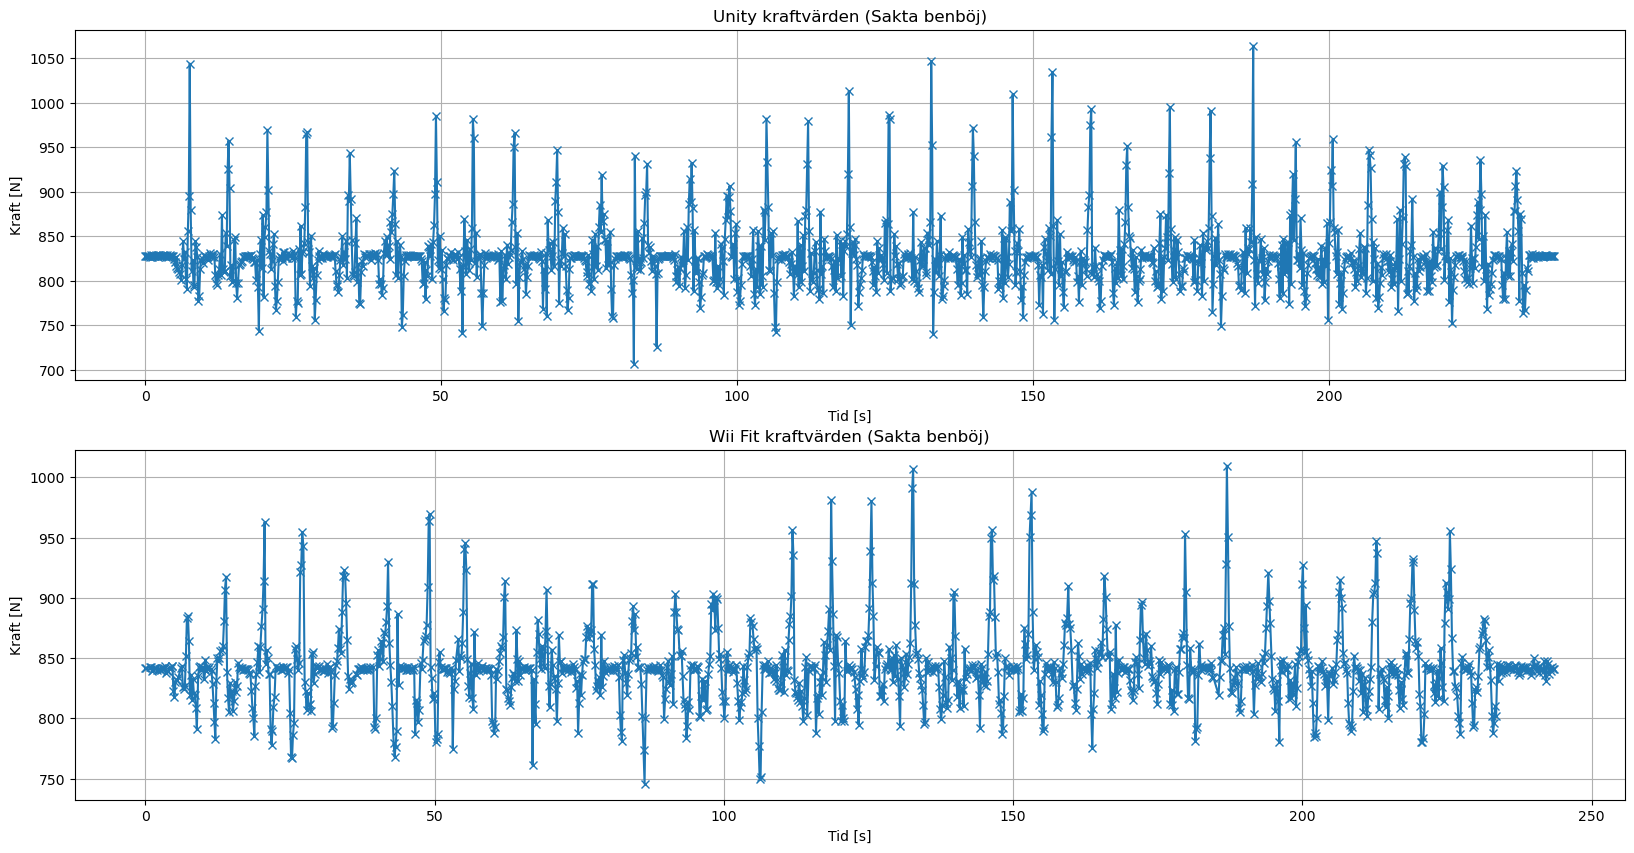

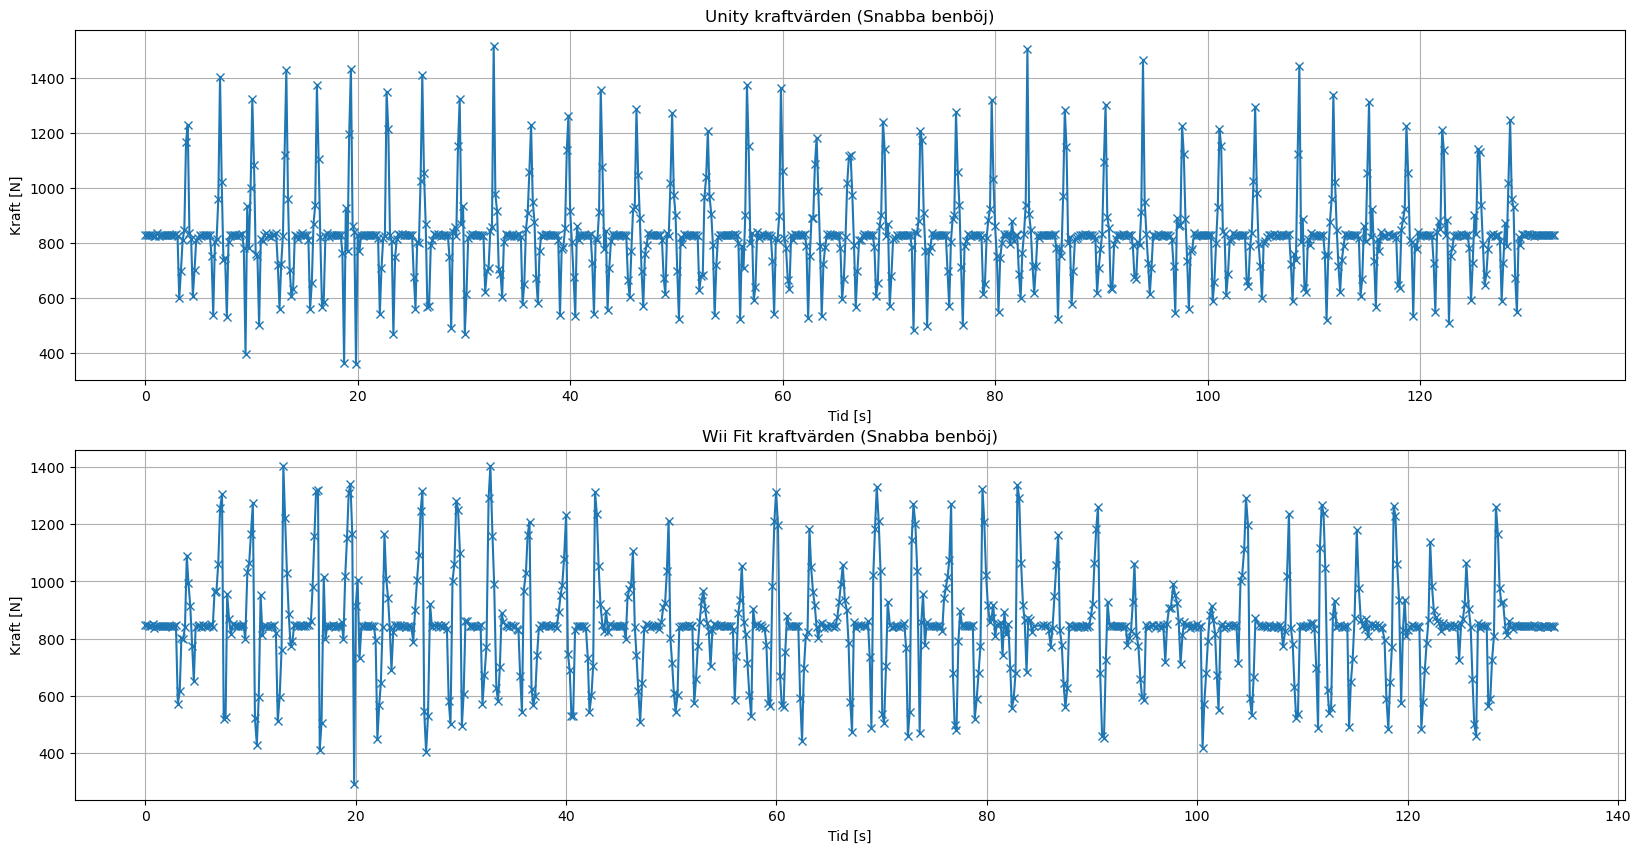

In [196]:

def plotNormalGraphs(df0, df1, title0, title1):
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(20,10))

    ax1.plot(df0['time'], df0['force'], marker="x")
    #ax.plot(originalUnityDF['time'], originalUnityDF['force'], linestyle='dashed', color = "green")
    ax1.set_xlabel("Tid [s]")
    ax1.set_ylabel("Kraft [N]")
    ax1.set_title(title0)
    ax1.grid()

    ax2.plot(df1['time'], df1['force'], marker="x")
    ax2.set_xlabel("Tid [s]")
    ax2.set_ylabel("Kraft [N]")
    ax2.set_title(title1)
    ax2.grid()
    plt.show()
    
plotNormalGraphs(unitySlowDF, wiiFitSlowDF, "Unity kraftvärden (Sakta benböj)", "Wii Fit kraftvärden (Sakta benböj)")
plotNormalGraphs(unityFastDF, wiiFitFastDF, "Unity kraftvärden (Snabba benböj)", "Wii Fit kraftvärden (Snabba benböj)")


Möjligtvis inttresant [[Källa]](https://matplotlib.org/stable/gallery/lines_bars_and_markers/fill_between_demo.html)

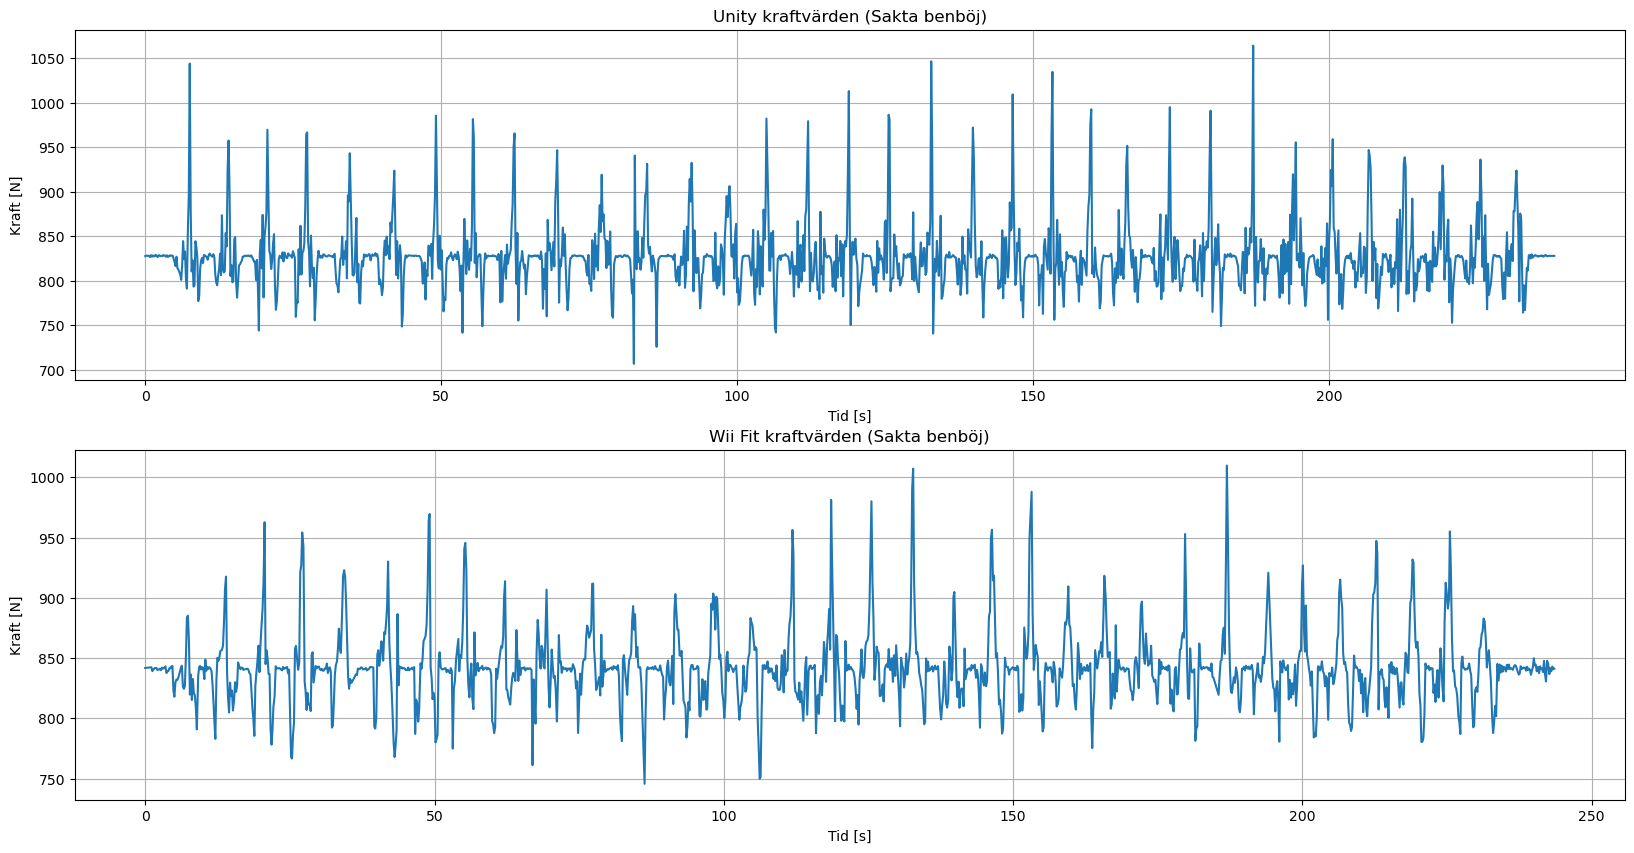

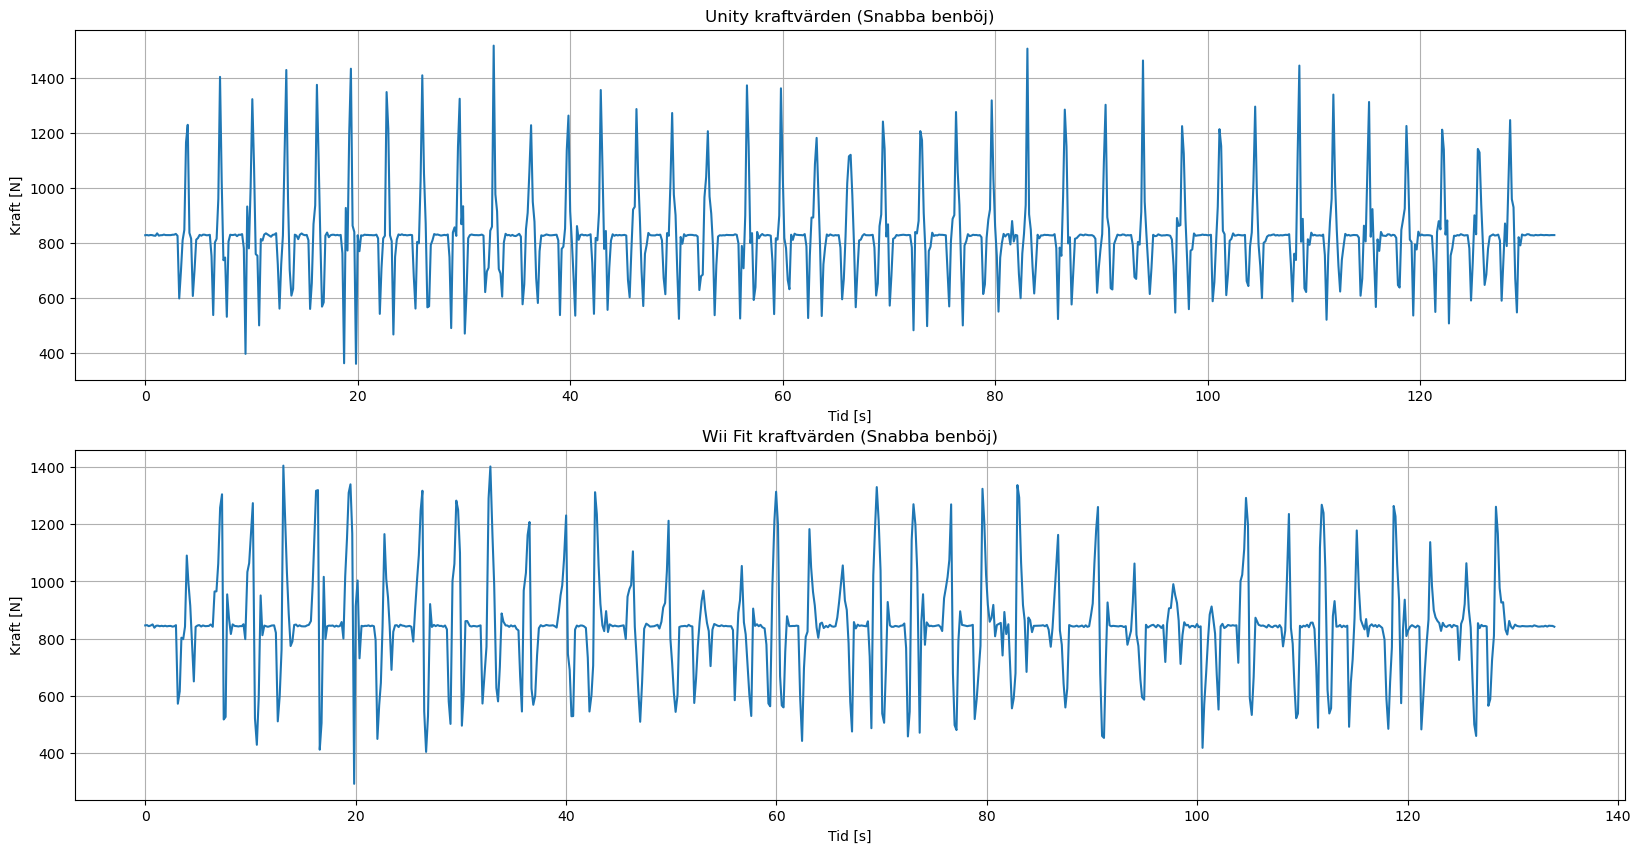

In [197]:

def plotNormalGraphs(df0, df1, title0, title1):
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(20,10))

    ax1.plot(df0['time'], df0['force'])
    ax1.set_xlabel("Tid [s]")
    ax1.set_ylabel("Kraft [N]")
    ax1.set_title(title0)
    ax1.grid()

    ax2.plot(df1['time'], df1['force'])
    ax2.set_xlabel("Tid [s]")
    ax2.set_ylabel("Kraft [N]")
    ax2.set_title(title1)
    ax2.grid()
    plt.show()
    
plotNormalGraphs(unitySlowDF, wiiFitSlowDF, "Unity kraftvärden (Sakta benböj)", "Wii Fit kraftvärden (Sakta benböj)")
plotNormalGraphs(unityFastDF, wiiFitFastDF, "Unity kraftvärden (Snabba benböj)", "Wii Fit kraftvärden (Snabba benböj)")


Om man lägger de på varandra ges följande.

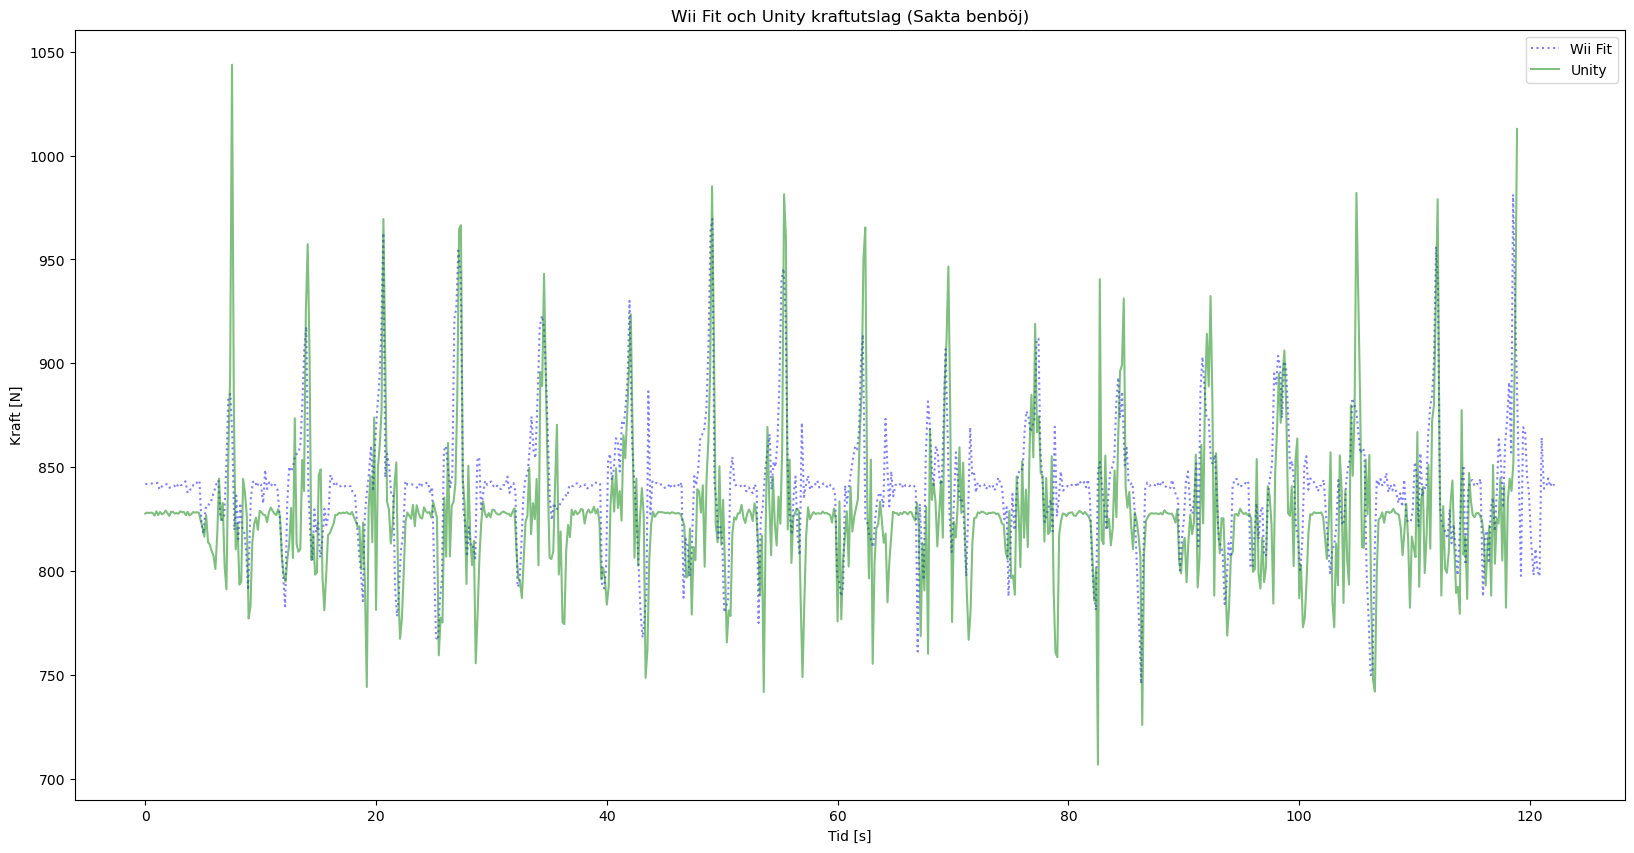

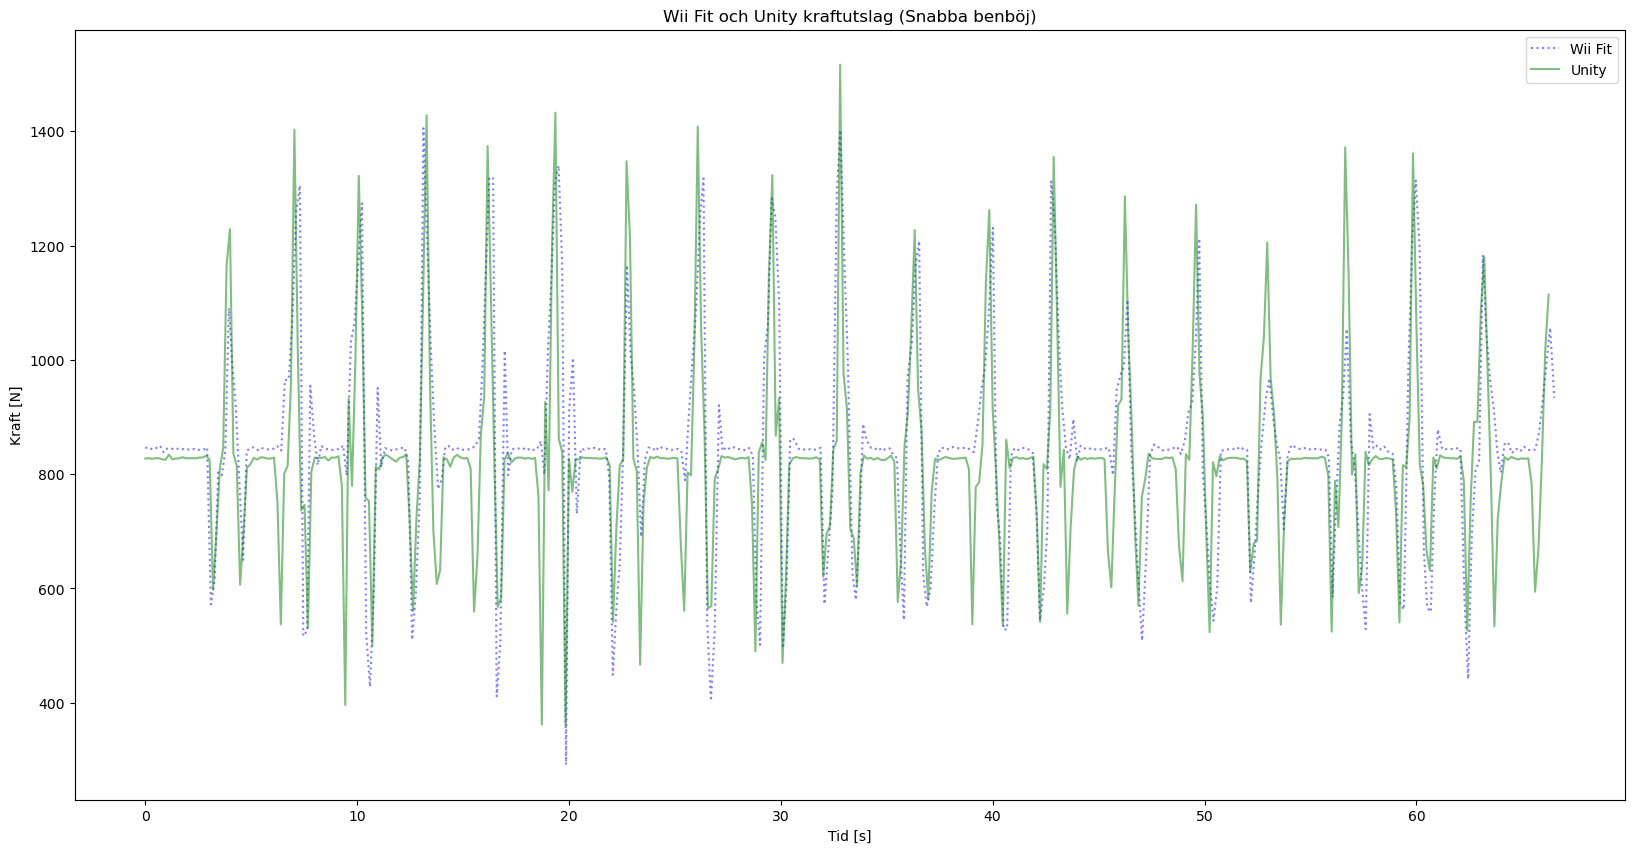

In [198]:
def plotDFsOnTopOfEachoter(df0, df1, title0, title1, type):
    fig, ax = plt.subplots(figsize=(20,10))

    ax.plot(df0['time'][0:int(df0.shape[0]/2)], df0['force'][0:int(df0.shape[0]/2)], label=title0, linestyle="dotted", color="blue", alpha=0.5)
    ax.plot(df1['time'][0:int(df1.shape[0]/2)], df1['force'][0:int(df1.shape[0]/2)], label=title1, linestyle="solid", color="green", alpha=0.5)


    ax.set_title(f"{title0} och {title1} kraftutslag ({type})")
    ax.set_xlabel("Tid [s]")
    ax.set_ylabel("Kraft [N]")
    ax.legend()



    plt.show()
    #plt.plot(data['time'], data['force'])
    #plt.figure().set_size_inches(2000, 10, forward=True)
    #plt.show()
    
    
plotDFsOnTopOfEachoter(wiiFitSlowDF, unitySlowDF, "Wii Fit", "Unity", "Sakta benböj")
plotDFsOnTopOfEachoter(wiiFitFastDF, unityFastDF, "Wii Fit", "Unity", "Snabba benböj")


## Area beräkning

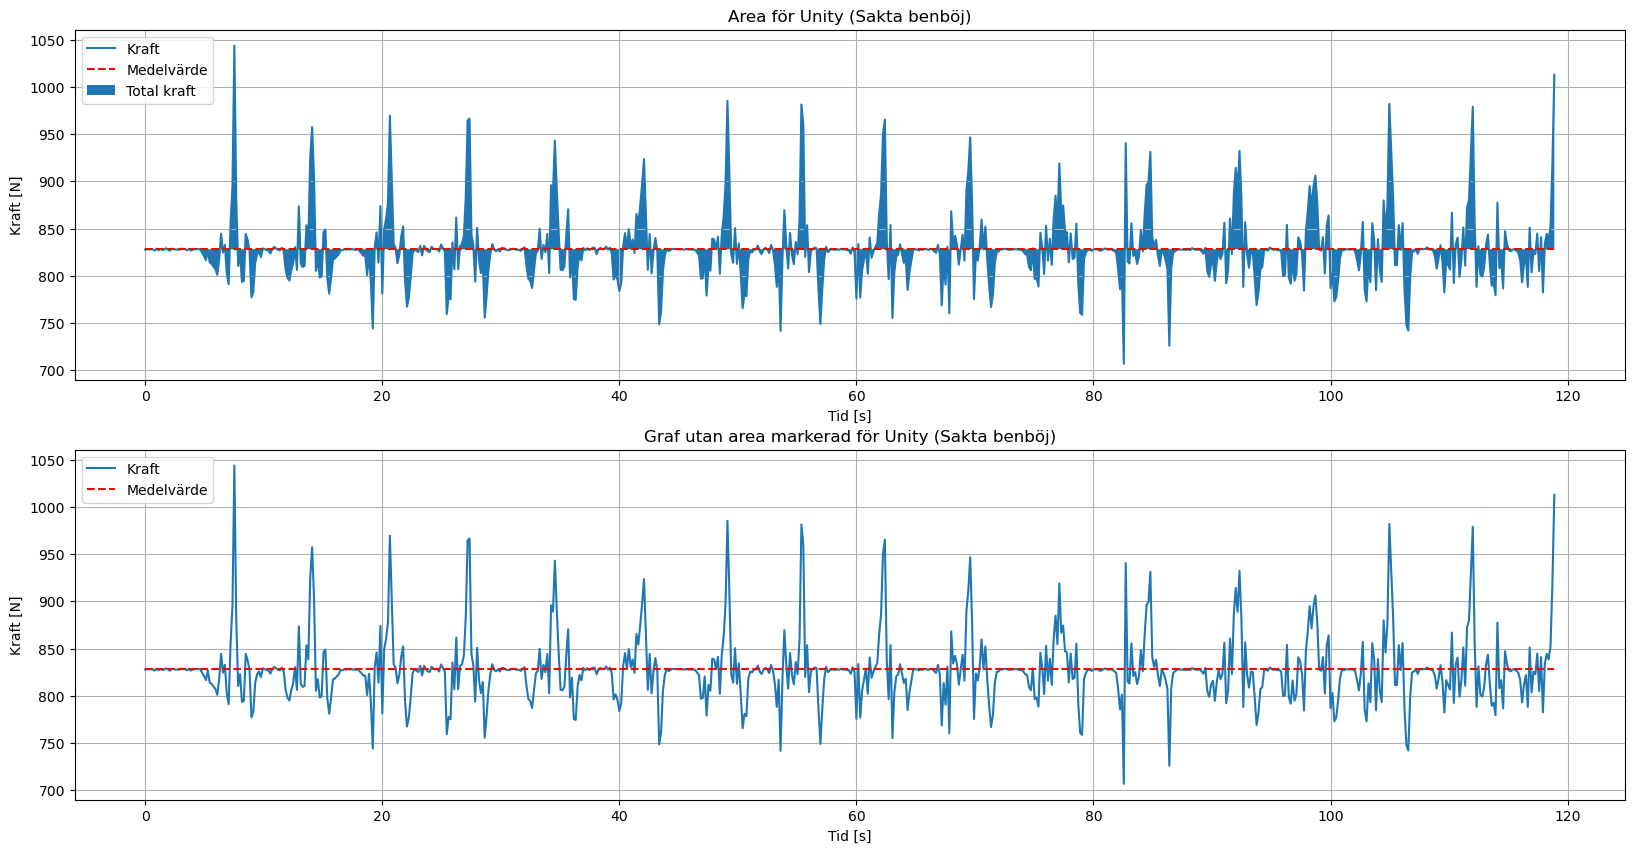

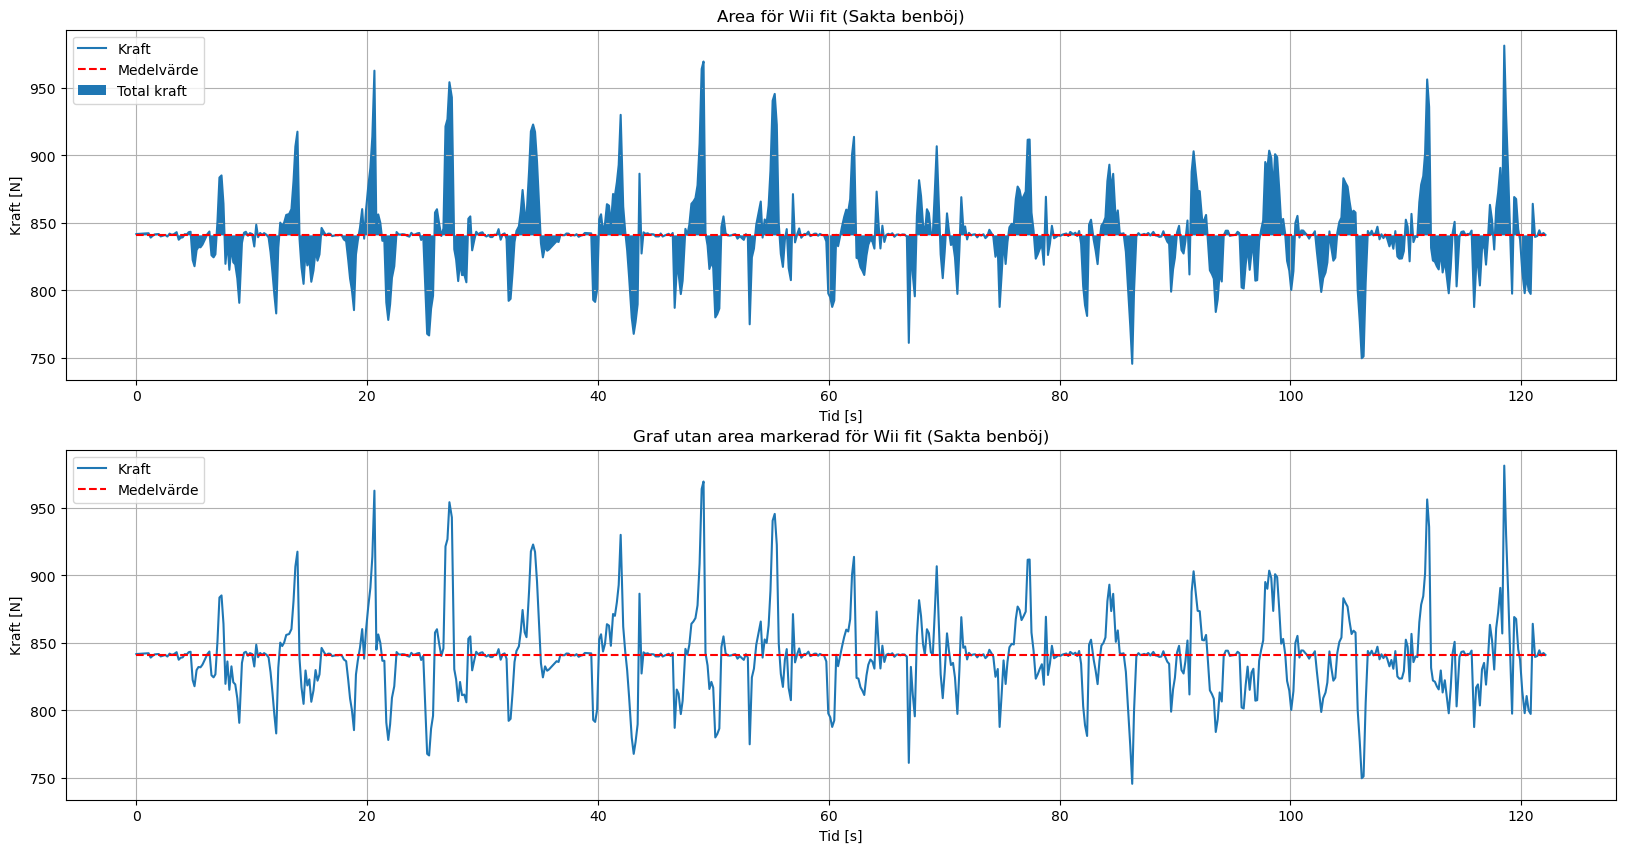

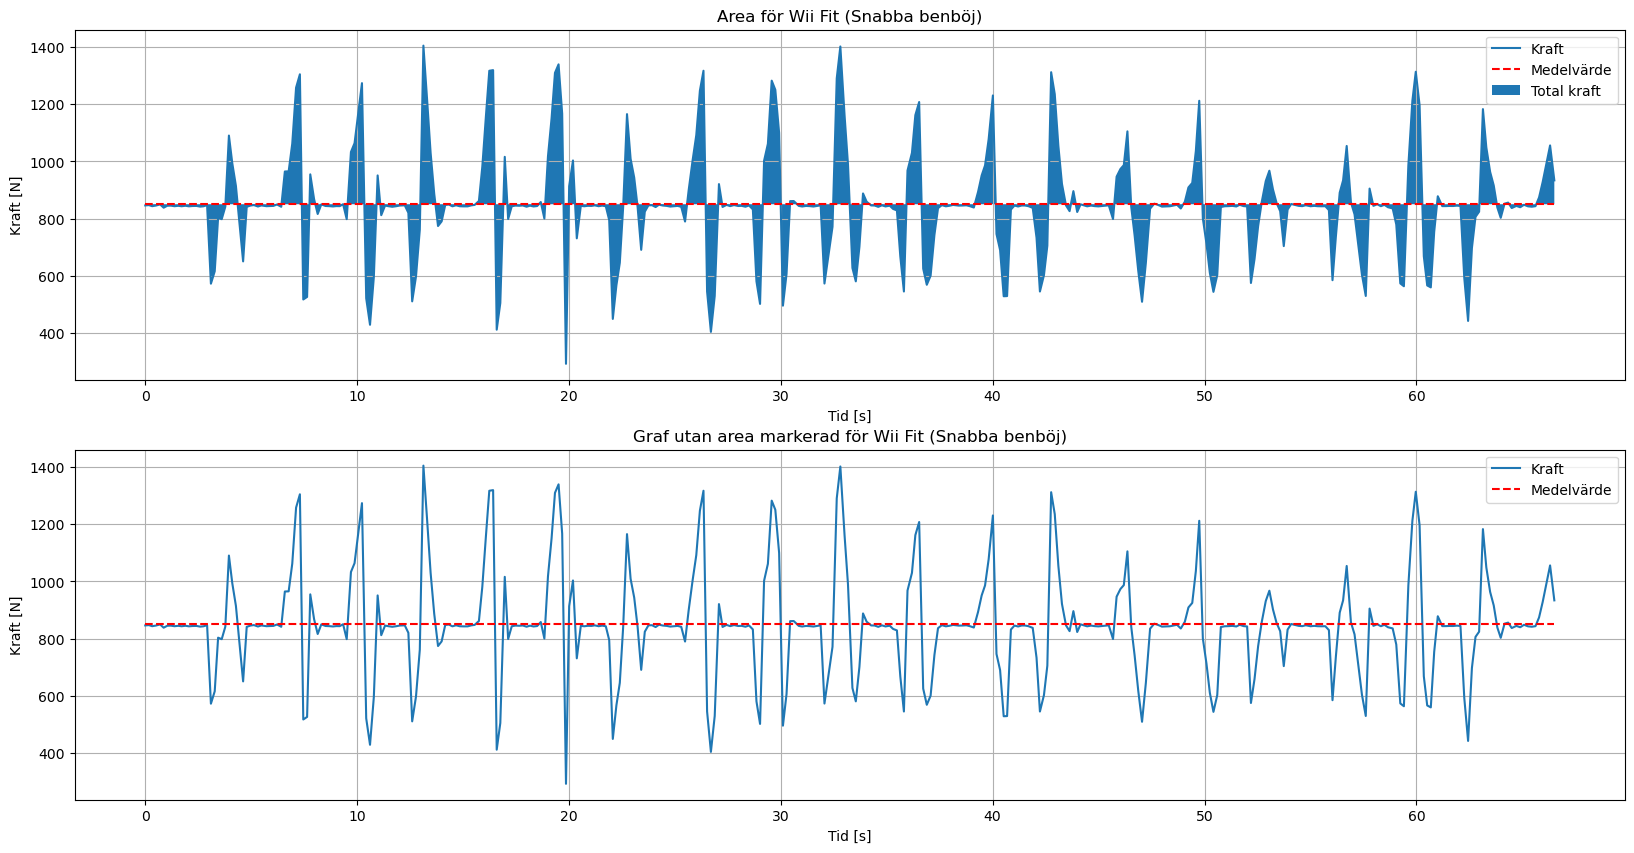

In [199]:
def showSurface(dataframe, title):
    snippetOfGraph = dataframe[0:int(dataframe.shape[0]/2)]
    horizontalLine = np.arange(0, snippetOfGraph.shape[0])

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,10))

    ax1.plot(snippetOfGraph['time'], snippetOfGraph['force'], label="Kraft")
    ax1.hlines(y=snippetOfGraph['force'].mean(), colors=['red'], linestyles=['dashed'], xmin=snippetOfGraph['time'][0], xmax=snippetOfGraph['time'][snippetOfGraph.shape[0]-1], label="Medelvärde")
    ax1.set_xlabel("Tid [s]")
    ax1.set_ylabel("Kraft [N]")
    ax1.fill_between(snippetOfGraph['time'], snippetOfGraph['force'], snippetOfGraph['force'].mean(), label="Total kraft")
    ax1.legend()
    ax1.grid()
    ax1.set_title(f"Area för {title}")

    ax2.plot(snippetOfGraph['time'], snippetOfGraph['force'], label="Kraft")
    ax2.hlines(y=snippetOfGraph['force'].mean(), colors=['red'], linestyles=['dashed'], xmin=snippetOfGraph['time'][0], xmax=snippetOfGraph['time'][snippetOfGraph.shape[0]-1], label="Medelvärde")
    ax2.set_xlabel("Tid [s]")
    ax2.set_ylabel("Kraft [N]")
    ax2.legend()
    ax2.grid()
    ax2.set_title(f"Graf utan area markerad för {title}")
    plt.show()

showSurface(unitySlowDF, "Unity (Sakta benböj)")
#showSurface(unityFastDF, "Unity (Snabba benblj)")

showSurface(wiiFitSlowDF, "Wii fit (Sakta benböj)")
showSurface(wiiFitFastDF, "Wii Fit (Snabba benböj)")

Kod för att testa att area beräkningen är korrekt i senare fall.

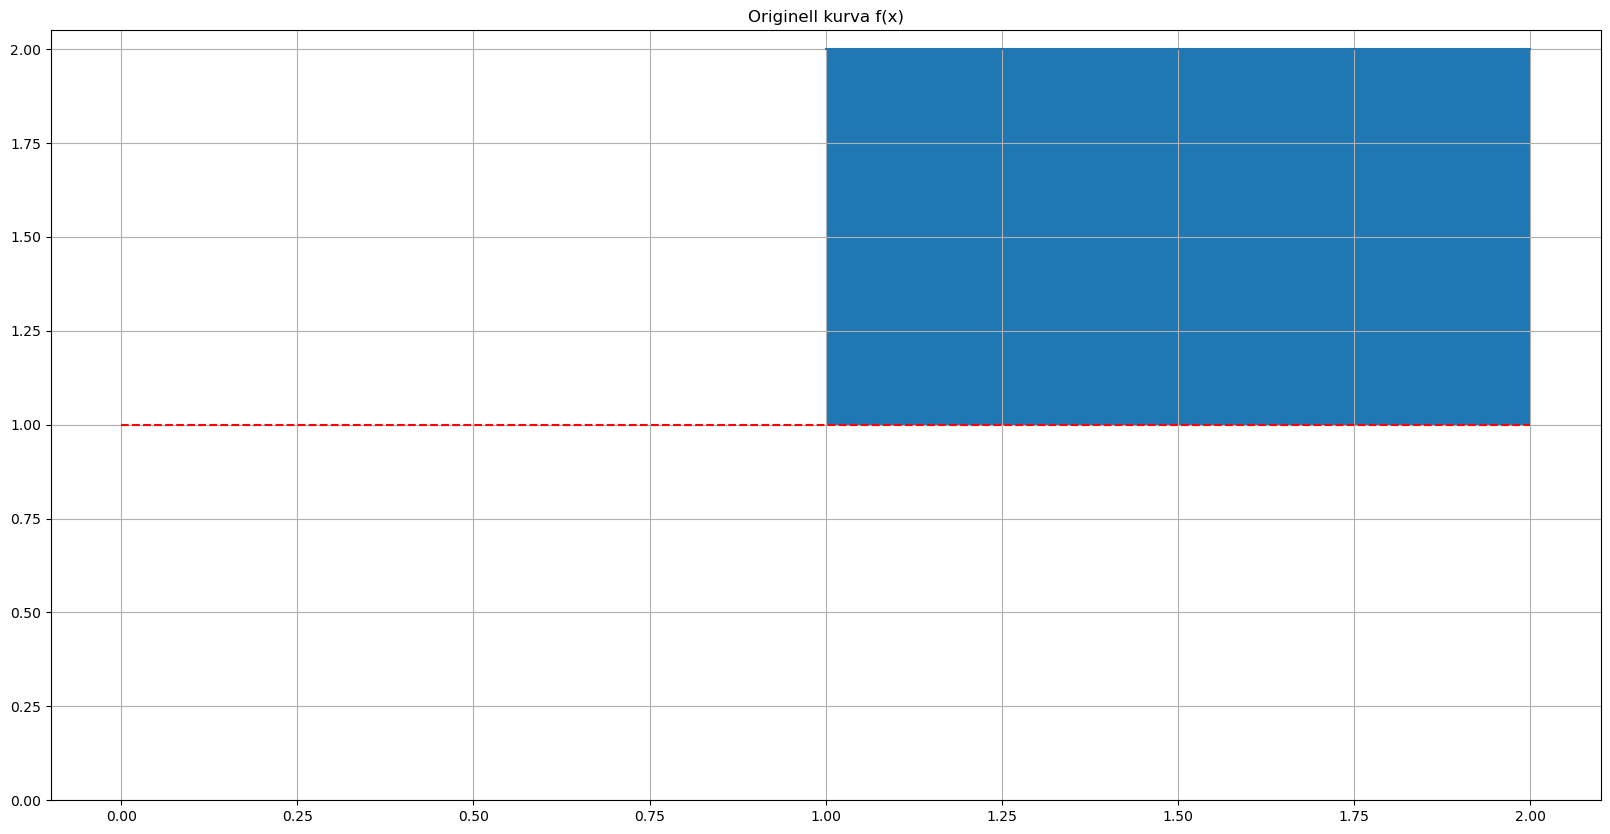

In [201]:
x_line= [1,2]
y_line= [2,2]

horizontalLine_x=[1,2]
horizontalLine_y=[1,1]


fig, axs = plt.subplots(1, figsize=(20,10))

axs.plot(x_line,y_line)
axs.grid()
axs.hlines(y=1,xmin=0, xmax=2, linestyles='dashed', colors='red')
axs.fill_between(x_line,y_line, 1)
axs.set_title("Originell kurva f(x)")
axs.set_ylim(bottom=0)


integralAbove = cumulative_trapezoid(y=y_line, x=x_line, initial=0)
integralBelow = cumulative_trapezoid(y=horizontalLine_y, x=horizontalLine_x, initial=0)

areabetween = integralAbove[len(integralAbove)-1] - integralBelow[len(integralBelow)-1]
#print(f"Marked area: {areabetween}")

integralFirst = cumulative_trapezoid([1,1],[0,1],initial=0)
integralSecond = cumulative_trapezoid([1,1],[1,2],initial=0)

plt.show()

Här beräknas arean mellan **median** sträcket och kraft kurvan som har givits från mätinstrument. Med **median** som axel att utföra integrering över så tas fler punkter, kordinater där de två linjerna korsar varandra, och därmed ges en mera exakt area.

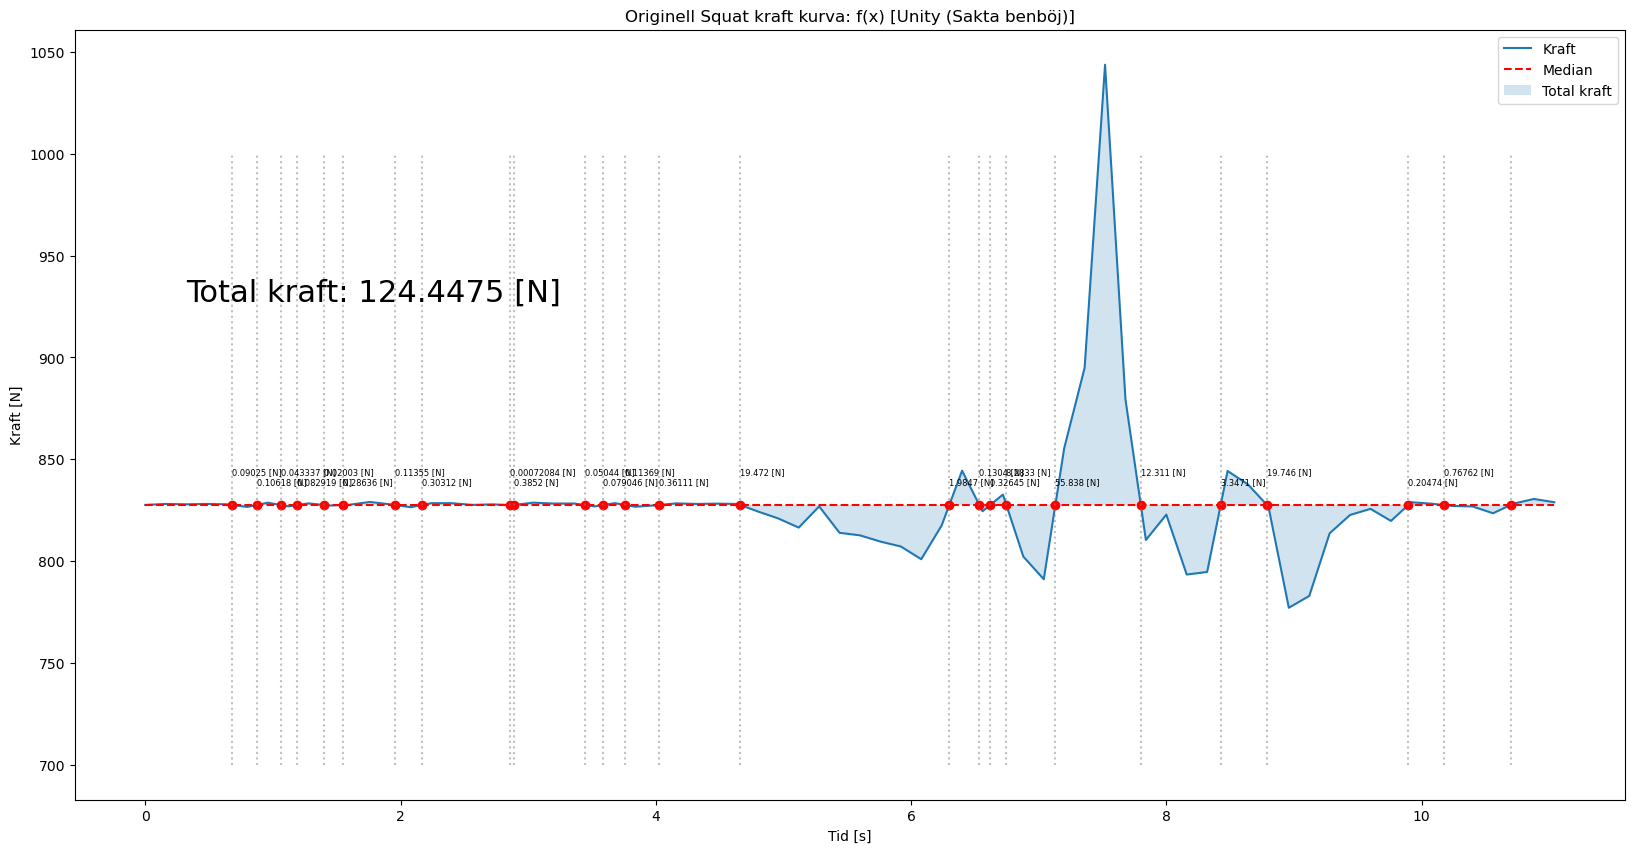

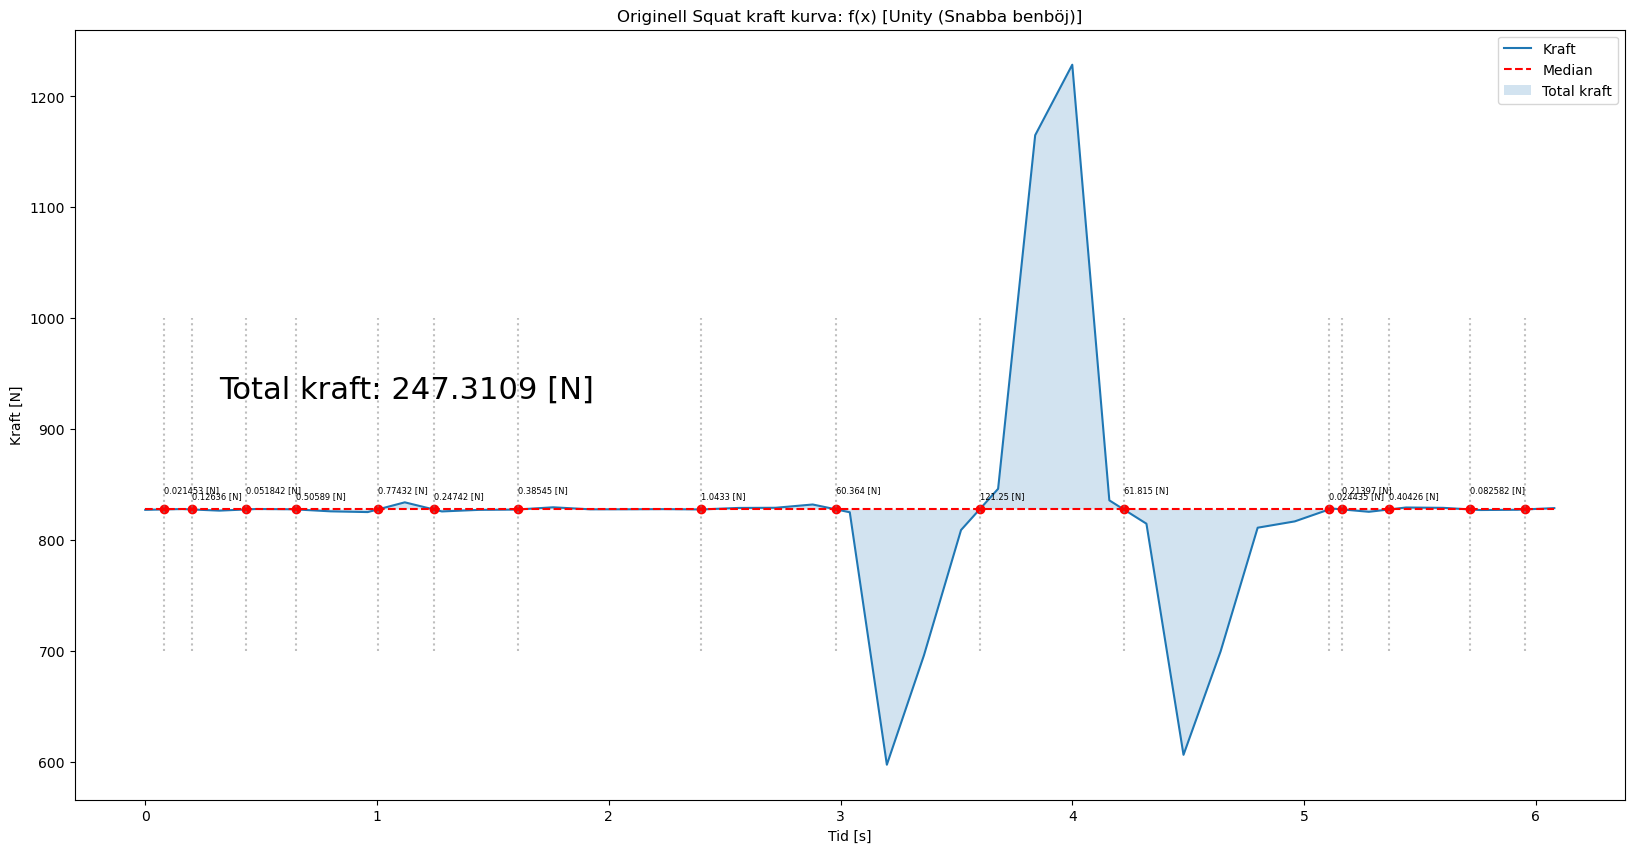

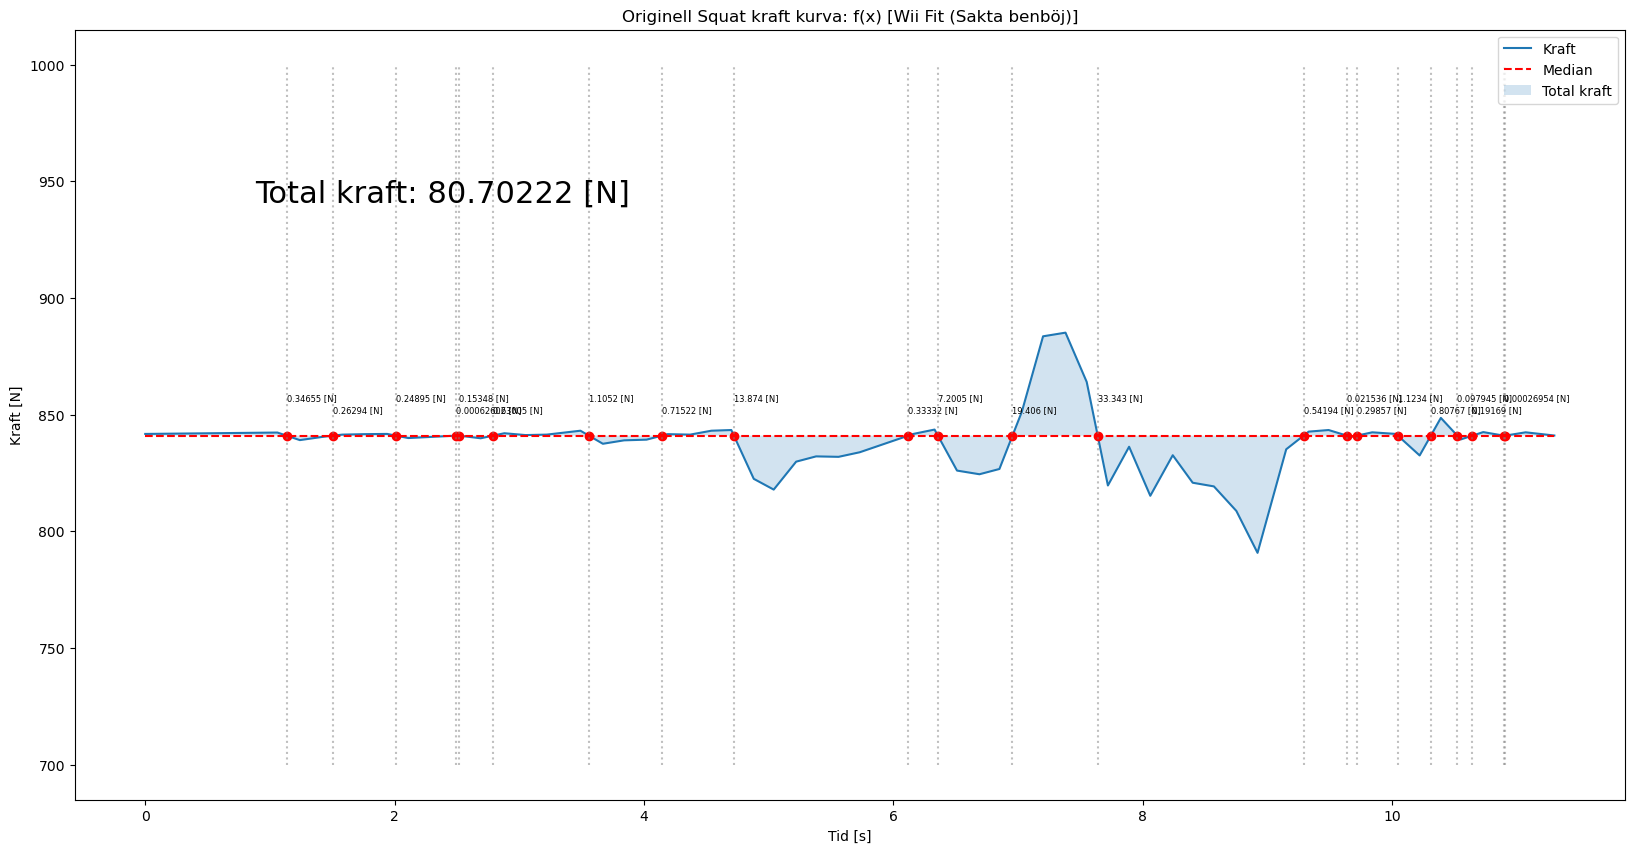

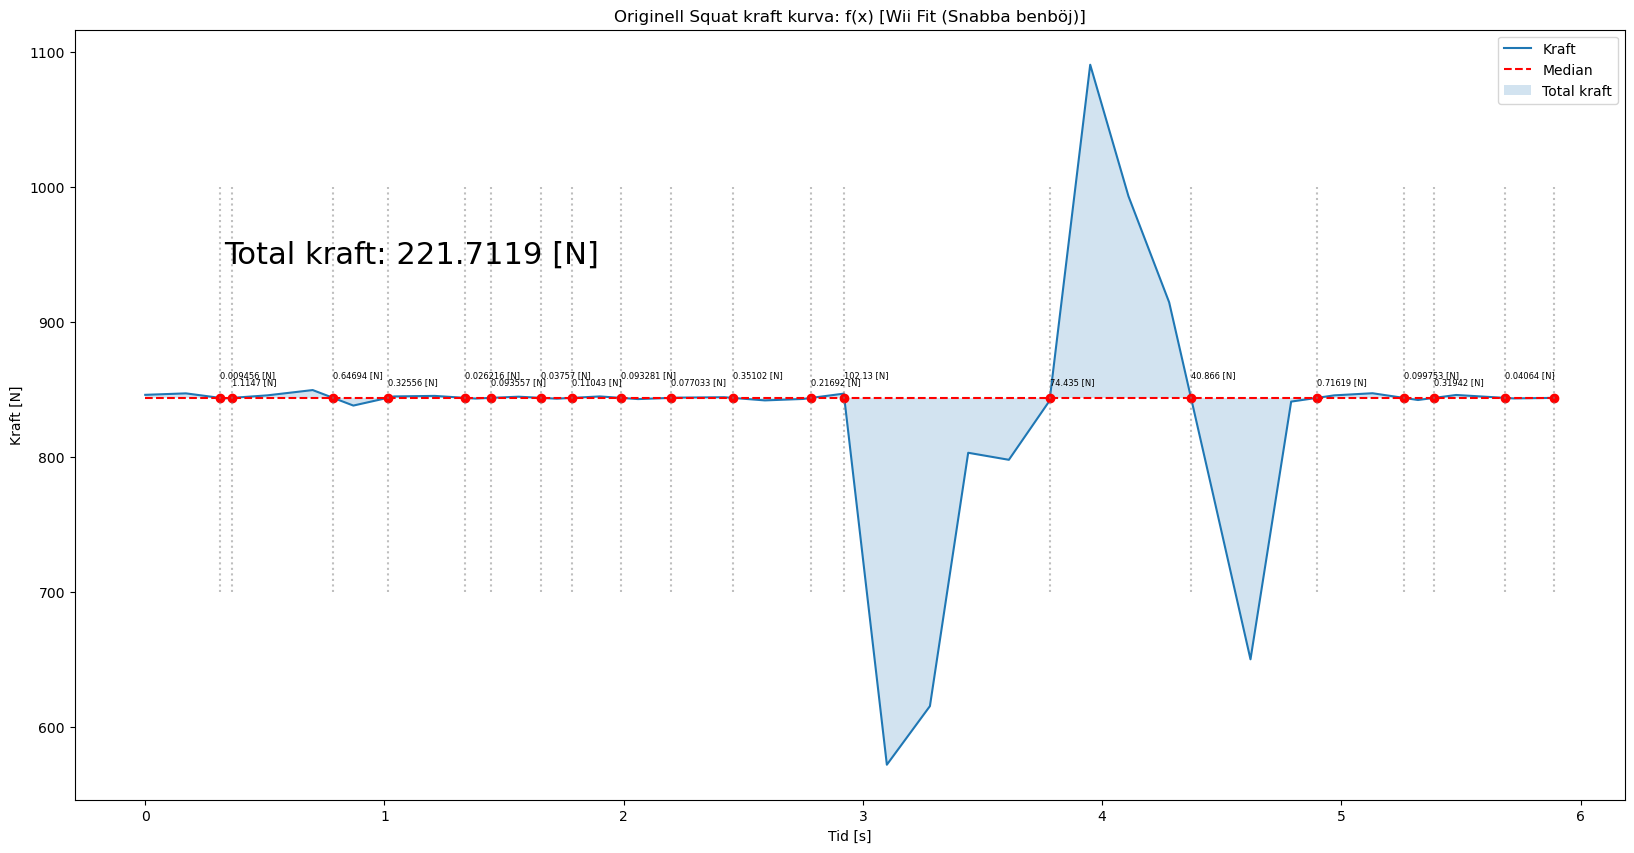

In [214]:
import numpy as np
import matplotlib.pyplot as plt

def getAndShowSurfaceOfDFWithMedian(dataframe, toRange, title, showPrints):

    snippetOfGraph = dataframe[0:toRange]

    fig, (ax1) = plt.subplots(1, 1, figsize=(20,10))

    ax1.plot(snippetOfGraph['time'], snippetOfGraph['force'], label="Kraft")
    ax1.hlines(y=snippetOfGraph['force'].median(), colors=['red'], linestyles=['dashed'], xmin=snippetOfGraph['time'][0], xmax=snippetOfGraph['time'][snippetOfGraph.shape[0]-1], label="Median")
    ax1.set_xlabel("Tid [s]")
    ax1.set_ylabel("Kraft [N]")
    #ax1.grid()
    ax1.set_title(f"Originell Squat kraft kurva: f(x) [{title}]")


    from shapely.geometry import LineString

    medianArr = np.full(snippetOfGraph['force'].shape[0], snippetOfGraph['force'].median())

    line_1 = LineString(np.column_stack((snippetOfGraph['force'],snippetOfGraph['time'])))
    line_2 = LineString(np.column_stack((medianArr,snippetOfGraph['time'])))

    intersection = line_1.intersection(line_2)

    intersection.geoms

    time = []
    force = []
    for geom in intersection.geoms:
        if(type(geom) == LineString):
            for coord in geom.coords:
                time.append(coord[1])
                force.append(coord[0])
        else:    
            time.append(geom.y)
            force.append(geom.x)
    
    #ax1.plot(time, force, 'ro')
    #ax1.vlines(ymax=1000, ymin=700, x=time, linestyles="dotted", colors="gray", alpha=0.5)
    #ax1.fill_between(snippetOfGraph['time'], snippetOfGraph['force'], snippetOfGraph['force'].mean(), label="Total kraft", alpha=0.2)
    #ax1.fill_betweenx(y=np.arange(snippetOfGraph['force'].min(),snippetOfGraph['force'].max(),0.1), x1=time[0], x2=time[1], alpha=0.2, color="gray")


    # Sortera time och force listorna.
    sortedTime = []

    sortedForce = []

    i = 0


    while(len(time) != 0):
        i = time.index(min(time))
        sortedTime.append(min(time))    
        sortedForce.append(force[i])
        
        time.pop(i)
        force.pop(i)
        
    ax1.plot(sortedTime, sortedForce, 'ro')
    ax1.vlines(ymax=1000, ymin=700, x=sortedTime, linestyles="dotted", colors="gray", alpha=0.5)
    ax1.fill_between(snippetOfGraph['time'], snippetOfGraph['force'], snippetOfGraph['force'].median(), label="Total kraft", alpha=0.2)
    #ax1.fill_betweenx(y=np.arange(snippetOfGraph['force'].min(),snippetOfGraph['force'].max(),0.1), x1=time[0], x2=time[1], alpha=0.2, color="gray")


    if(showPrints):
        print("Kraftkurva: F(x) \t\t\t Median G(x) \t\t\t Diff \t\t\t Positiv Diff")

    # Integrera mellan de givna punkterna
    sumForce = 0
    pos = 0
    spacer = 1
    while(pos < len(sortedTime)):
        # Skapa scliecs av force och time variablerna
        if(pos == len(sortedTime)-1):
            break
        
        timeSlice = []
        forceSlice = []
        
        # Första värdet och sista värdet blir givet av sortedTime & sortedForce vilket är där linjerna korsar varann
        timeSlice.append(sortedTime[pos])
        forceSlice.append(sortedForce[pos])



        # Lägg in värden av snippetOfGraph['force] & snippetOfGraph['time'] i slices
        i = 0
        while(True):
            # Lägg till de värden som kommer imellan de två 'intersections' som finns.
            if(snippetOfGraph['time'][i] == sortedTime[pos] or snippetOfGraph['time'][i] < sortedTime[pos]):
                i = i + 1
                continue
            if(snippetOfGraph['time'][i] == sortedTime[pos + 1] or snippetOfGraph['time'][i] > sortedTime[pos + 1]):
                break

            timeSlice.append(snippetOfGraph['time'][i])
            forceSlice.append(snippetOfGraph['force'][i])
            i = i + 1
            
        
        timeSlice.append(sortedTime[pos+1])
        forceSlice.append(sortedForce[pos+1])
        
        #print(f"timeSlice (pos {pos} - {pos + 1}): {timeSlice}")
        

        # Utför en integral med cumulative_trapezoid            
        sliceIntegral1 = cumulative_trapezoid(y=forceSlice, x=timeSlice, initial=0)
        sliceIntegral2 = cumulative_trapezoid(y=np.full(len(forceSlice), fill_value=snippetOfGraph['force'].median()), x=timeSlice, initial=0)
        
        diff = sliceIntegral1[len(sliceIntegral1) - 1] - sliceIntegral2[len(sliceIntegral2) - 1] 
        
        if(showPrints):
            if(diff < 0):
                print(f"{sliceIntegral1[len(sliceIntegral1) - 1]:.1f} [N] \t\t - \t\t {sliceIntegral2[len(sliceIntegral2) - 1]:.1f} [N] \t\t = \t {diff:.1f} [N] \t\t (-){diff*-1:.1} [N]")
            else:
                print(f"{sliceIntegral1[len(sliceIntegral1) - 1]:.1f} [N] \t\t - \t\t {sliceIntegral2[len(sliceIntegral2) - 1]:.1f} [N] \t\t = \t {diff:.1f} [N]")
            
        if(diff < 0):
            diff = diff * -1
        #print(f"Integral values: {sliceIntegral}")
        #print(f"Integral value: {sliceIntegral[len(sliceIntegral)-1]} [N]\n")


        # Ta det sista värdet i arreyen som funktionen returnarar.
        # Som sist addera integralvärdet till en summa.
        ax1.text(sortedTime[pos], snippetOfGraph['force'].median() + 10 + 5 * spacer, f'{diff:.5} [N]', fontsize = 6)
        sumForce = sumForce + diff
        if(spacer == 1):
            spacer = 0
        else:
            spacer = 1
            
        # Gå till nästa punkt.
        pos = pos + 1

    if(showPrints):
        print(f"Sum:\t\t\t\t\t\t\t\t\t\t\t\t{sumForce} [N]")
    ax1.text(snippetOfGraph['time'][2], snippetOfGraph['force'].median() + 100, f'Total kraft: {sumForce:.7} [N]', fontsize = 22)

    ax1.legend()
    plt.show()
    

getAndShowSurfaceOfDFWithMedian(unitySlowDF, 70, "Unity (Sakta benböj)", False)
getAndShowSurfaceOfDFWithMedian(unityFastDF, 39, "Unity (Snabba benböj)", False)

getAndShowSurfaceOfDFWithMedian(wiiFitSlowDF, 60, "Wii Fit (Sakta benböj)",  False)
getAndShowSurfaceOfDFWithMedian(wiiFitFastDF, 35, "Wii Fit (Snabba benböj)",  False)



Här görs samma integrering som ovan fast istället för **median** så används **medelvärde**. Detta var det som originellt användes men det resulterade att flera areaor undveks. Detta var mindre synligt då endast ett benböj observerades men då flera benböj inkluderades i grafen blev ett mångtal areor oberäknade.

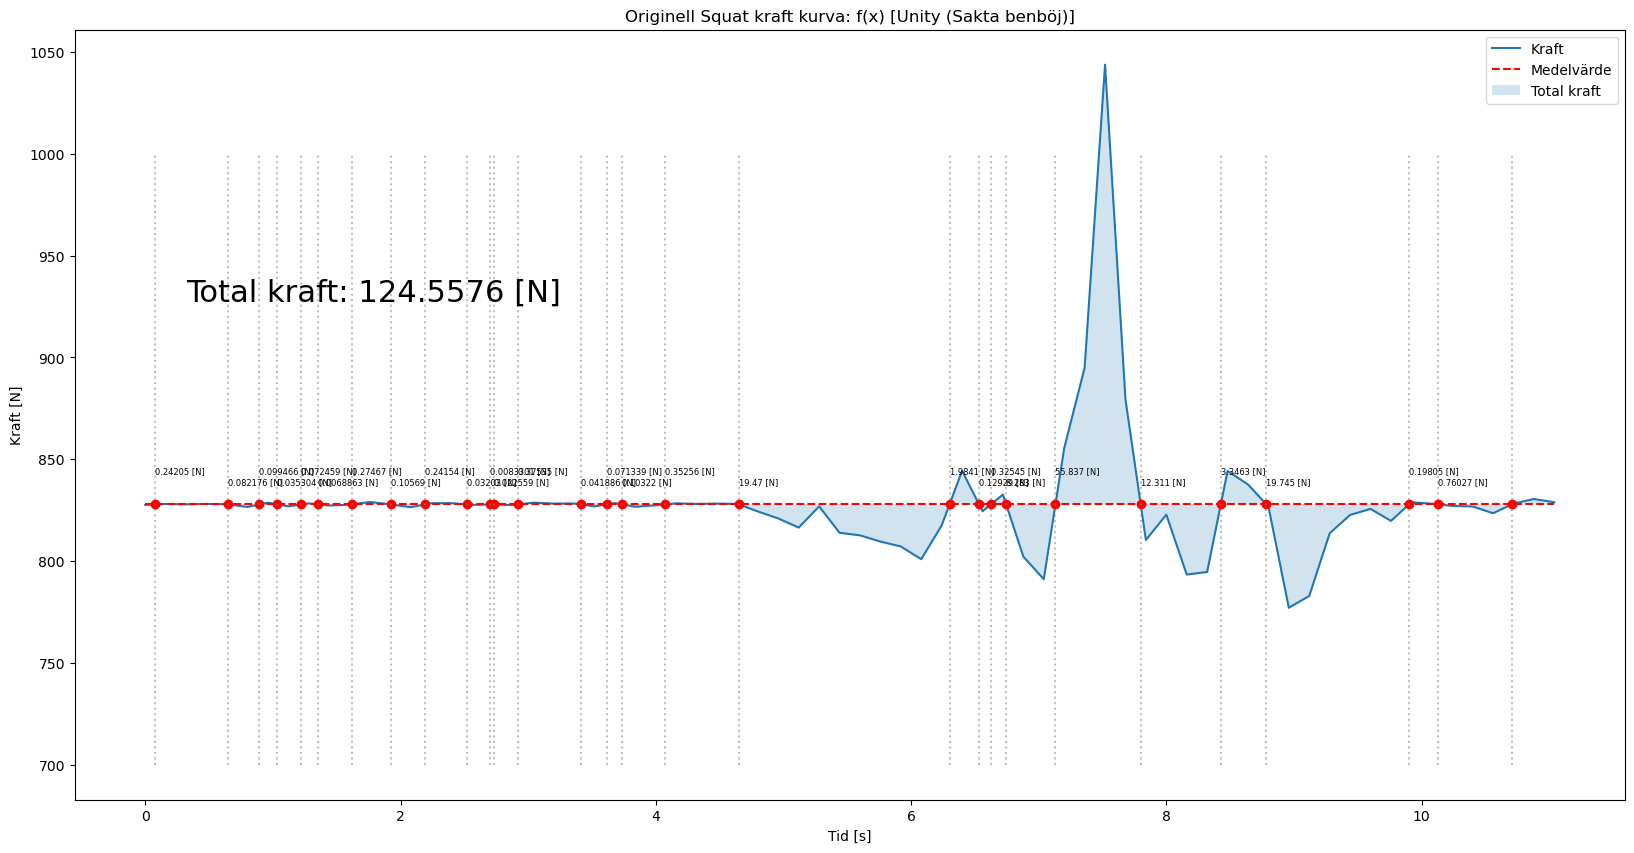

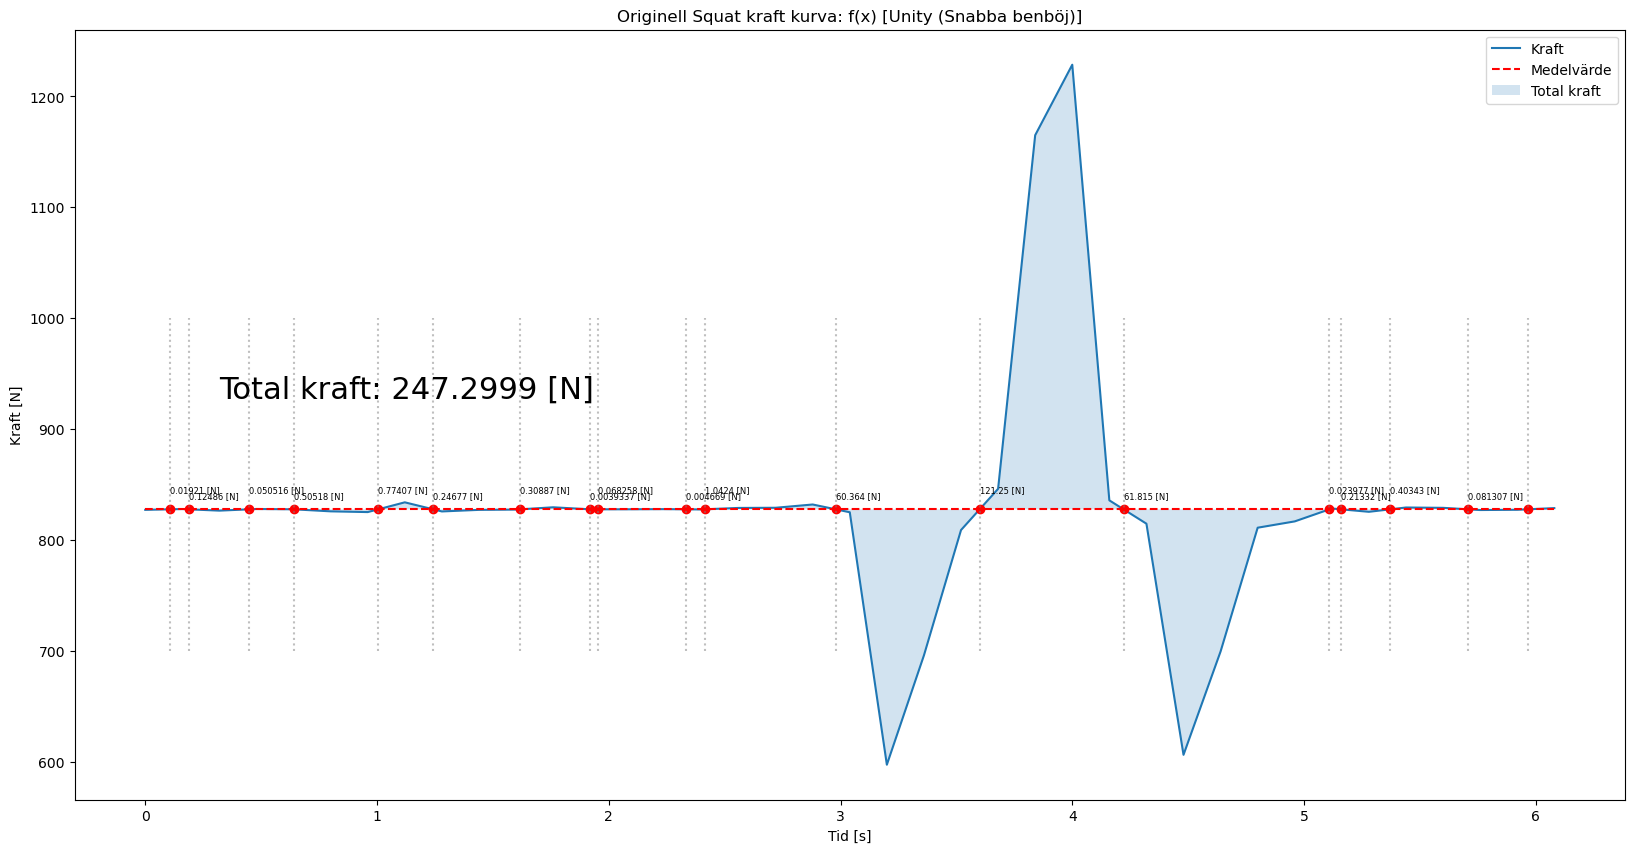

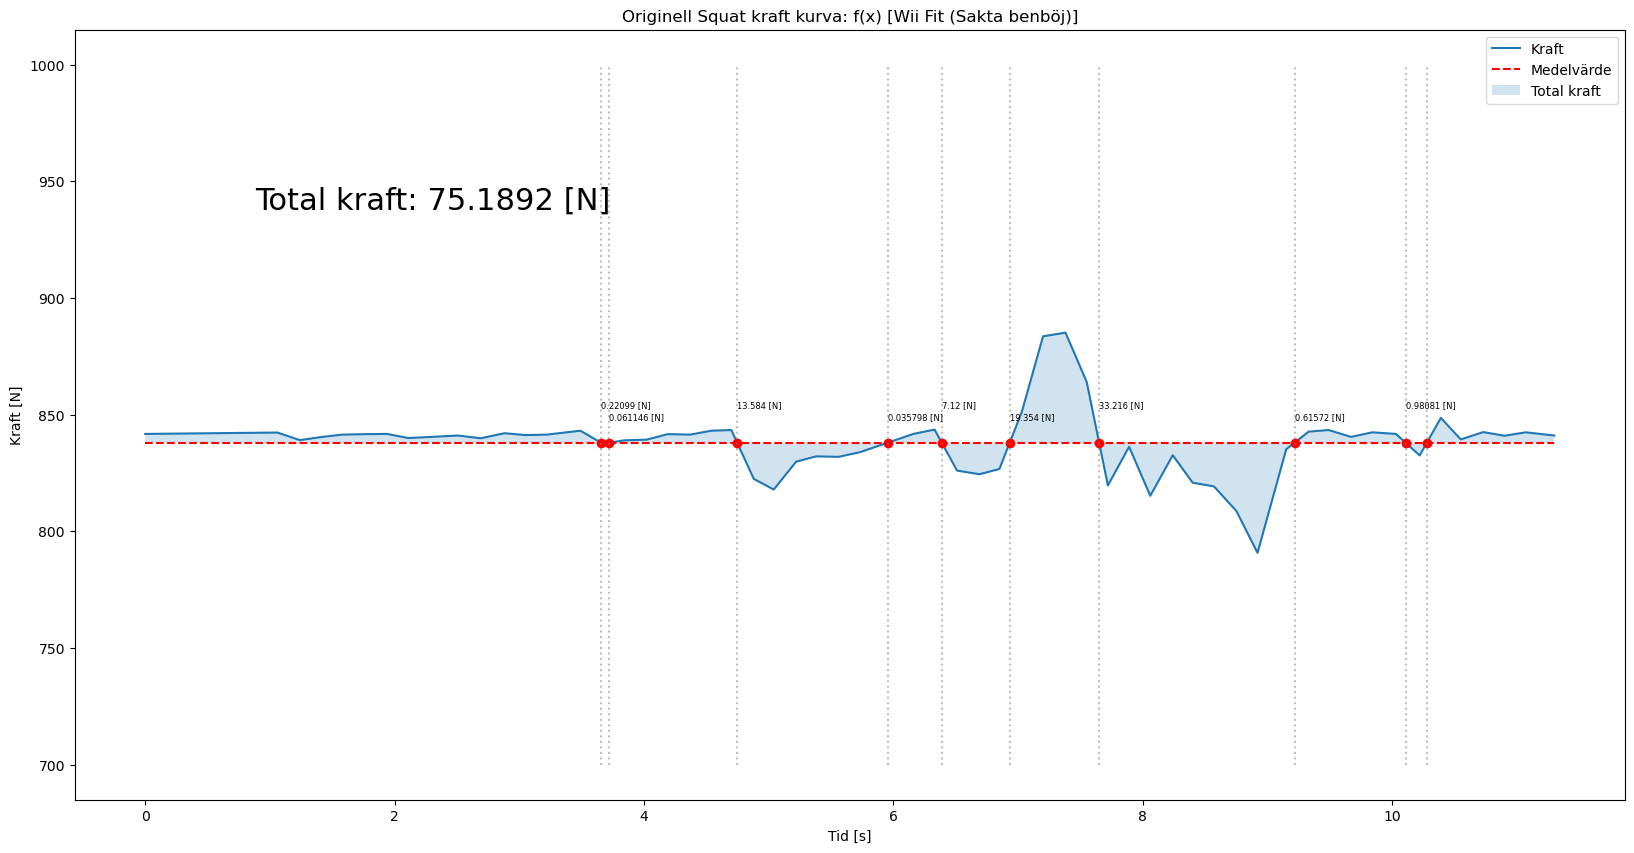

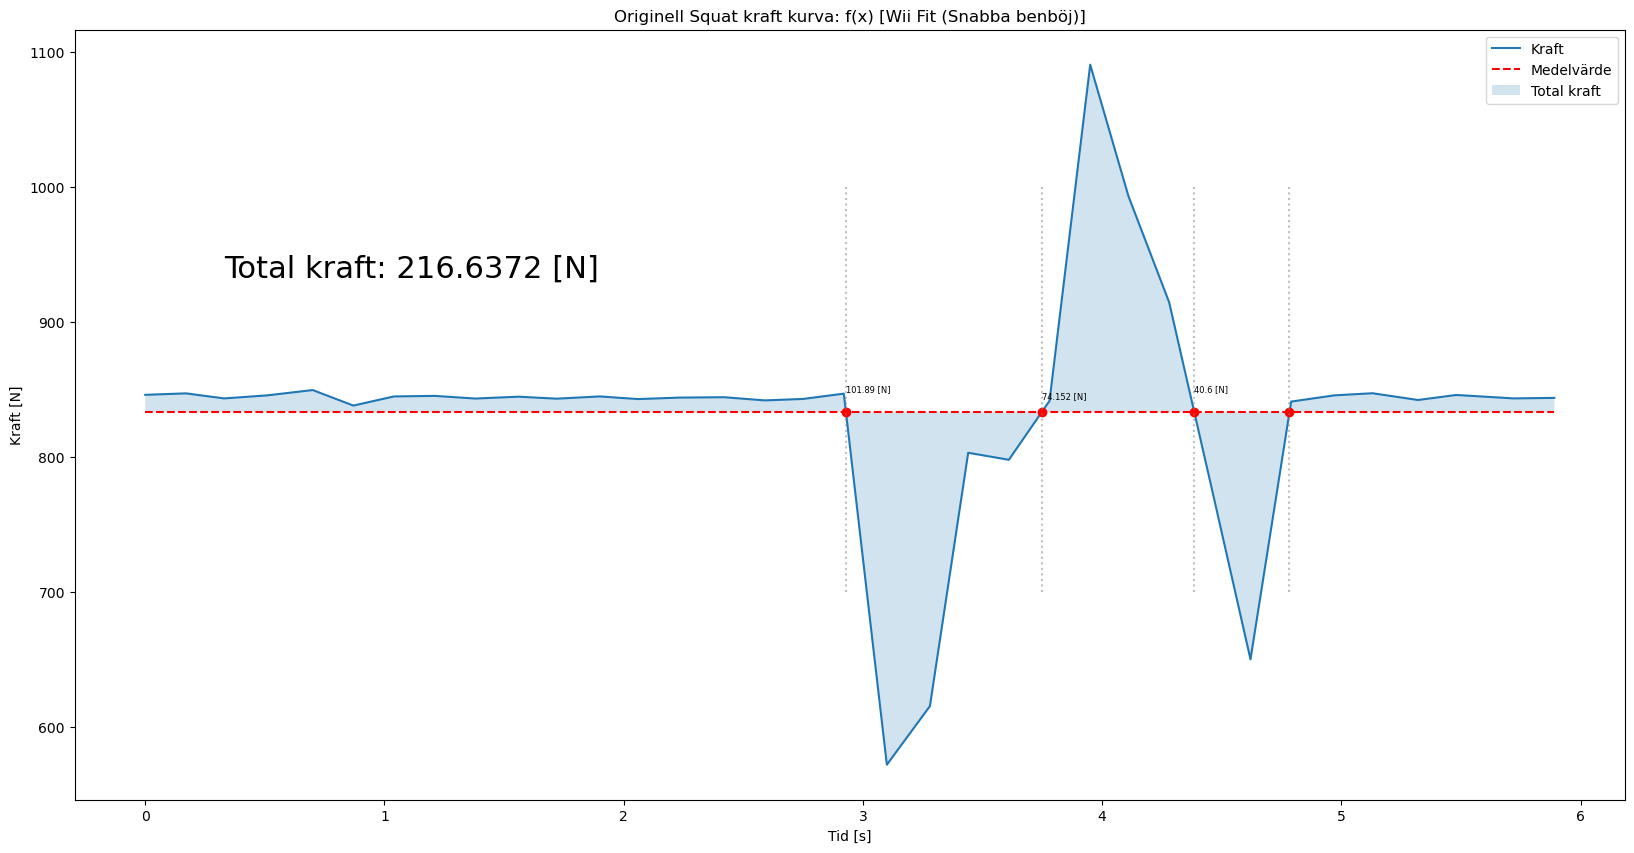

In [221]:
import numpy as np
import matplotlib.pyplot as plt

def getAndShowSurfaceOfDFWithMean(dataframe, toRange, title):

    snippetOfGraph = dataframe[0:toRange]

    fig, (ax1) = plt.subplots(1, 1, figsize=(20,10))

    ax1.plot(snippetOfGraph['time'], snippetOfGraph['force'], label="Kraft")
    ax1.hlines(y=snippetOfGraph['force'].mean(), colors=['red'], linestyles=['dashed'], xmin=snippetOfGraph['time'][0], xmax=snippetOfGraph['time'][snippetOfGraph.shape[0]-1], label="Medelvärde")
    ax1.set_xlabel("Tid [s]")
    ax1.set_ylabel("Kraft [N]")
    #ax1.grid()
    ax1.set_title(f"Originell Squat kraft kurva: f(x) [{title}]")


    from shapely.geometry import LineString

    meanArr = np.full(snippetOfGraph['force'].shape[0], snippetOfGraph['force'].mean())

    line_1 = LineString(np.column_stack((snippetOfGraph['force'],snippetOfGraph['time'])))
    line_2 = LineString(np.column_stack((meanArr,snippetOfGraph['time'])))

    intersection = line_1.intersection(line_2)

    intersection.geoms

    time = []
    force = []
    for geom in intersection.geoms:
        if(type(geom) == LineString):
            for coord in geom.coords:
                time.append(coord[1])
                force.append(coord[0])
        else:    
            time.append(geom.y)
            force.append(geom.x)
    
    #ax1.plot(time, force, 'ro')
    #ax1.vlines(ymax=1000, ymin=700, x=time, linestyles="dotted", colors="gray", alpha=0.5)
    #ax1.fill_between(snippetOfGraph['time'], snippetOfGraph['force'], snippetOfGraph['force'].mean(), label="Total kraft", alpha=0.2)
    #ax1.fill_betweenx(y=np.arange(snippetOfGraph['force'].min(),snippetOfGraph['force'].max(),0.1), x1=time[0], x2=time[1], alpha=0.2, color="gray")


    # Sortera time och force listorna.
    sortedTime = []

    sortedForce = []

    i = 0


    while(len(time) != 0):
        i = time.index(min(time))
        sortedTime.append(min(time))    
        sortedForce.append(force[i])
        
        time.pop(i)
        force.pop(i)
        
    ax1.plot(sortedTime, sortedForce, 'ro')
    ax1.vlines(ymax=1000, ymin=700, x=sortedTime, linestyles="dotted", colors="gray", alpha=0.5)
    ax1.fill_between(snippetOfGraph['time'], snippetOfGraph['force'], snippetOfGraph['force'].mean(), label="Total kraft", alpha=0.2)
    #ax1.fill_betweenx(y=np.arange(snippetOfGraph['force'].min(),snippetOfGraph['force'].max(),0.1), x1=time[0], x2=time[1], alpha=0.2, color="gray")


    # Integrera mellan de givna punkterna
    sumForce = 0
    pos = 0
    spacer = 1
    while(pos < len(sortedTime)):
        # Skapa scliecs av force och time variablerna
        if(pos == len(sortedTime)-1):
            break
        
        timeSlice = []
        forceSlice = []
        
        # Första värdet och sista värdet blir givet av sortedTime & sortedForce vilket är där linjerna korsar varann
        timeSlice.append(sortedTime[pos])
        forceSlice.append(sortedForce[pos])



        # Lägg in värden av snippetOfGraph['force] & snippetOfGraph['time'] i slices
        i = 0
        while(True):
            # Lägg till de värden som kommer imellan de två 'intersections' som finns.
            if(snippetOfGraph['time'][i] == sortedTime[pos] or snippetOfGraph['time'][i] < sortedTime[pos]):
                i = i + 1
                continue
            if(snippetOfGraph['time'][i] == sortedTime[pos + 1] or snippetOfGraph['time'][i] > sortedTime[pos + 1]):
                break

            timeSlice.append(snippetOfGraph['time'][i])
            forceSlice.append(snippetOfGraph['force'][i])
            i = i + 1
            
        
        timeSlice.append(sortedTime[pos+1])
        forceSlice.append(sortedForce[pos+1])
        
        #print(f"timeSlice (pos {pos} - {pos + 1}): {timeSlice}")
        

        # Utför en integral med cumulative_trapezoid    
        sliceIntegral1 = cumulative_trapezoid(y=forceSlice, x=timeSlice, initial=0)
        sliceIntegral2 = cumulative_trapezoid(y=np.full(len(forceSlice), fill_value=snippetOfGraph['force'].median()), x=timeSlice, initial=0)        
        diff = sliceIntegral1[len(sliceIntegral1) - 1] - sliceIntegral2[len(sliceIntegral2) - 1] 
        
        if(diff < 0):
            diff = diff * -1
        
        #print(f"Integral values: {sliceIntegral}")
        #print(f"Integral value: {sliceIntegral[len(sliceIntegral)-1]} [N]\n")


        # Ta det sista värdet i arreyen som funktionen returnarar.
        # Som sist addera integralvärdet till en summa.
        ax1.text(sortedTime[pos], snippetOfGraph['force'].mean() + 10 + 5 * spacer, f'{diff:.5} [N]', fontsize = 6)
        sumForce = sumForce + diff
        if(spacer == 1):
            spacer = 0
        else:
            spacer = 1
            
        # Gå till nästa punkt.
        pos = pos + 1

    ax1.text(snippetOfGraph['time'][2], snippetOfGraph['force'].mean() + 100, f'Total kraft: {sumForce:.7} [N]', fontsize = 22)

    ax1.legend()
    plt.show()

getAndShowSurfaceOfDFWithMean(unitySlowDF, 70, "Unity (Sakta benböj)")
getAndShowSurfaceOfDFWithMean(unityFastDF, 39, "Unity (Snabba benböj)")


getAndShowSurfaceOfDFWithMean(wiiFitSlowDF, 60, "Wii Fit (Sakta benböj)")
getAndShowSurfaceOfDFWithMean(wiiFitFastDF, 35, "Wii Fit (Snabba benböj)")






Använder **'mean'** som mitt-axel.

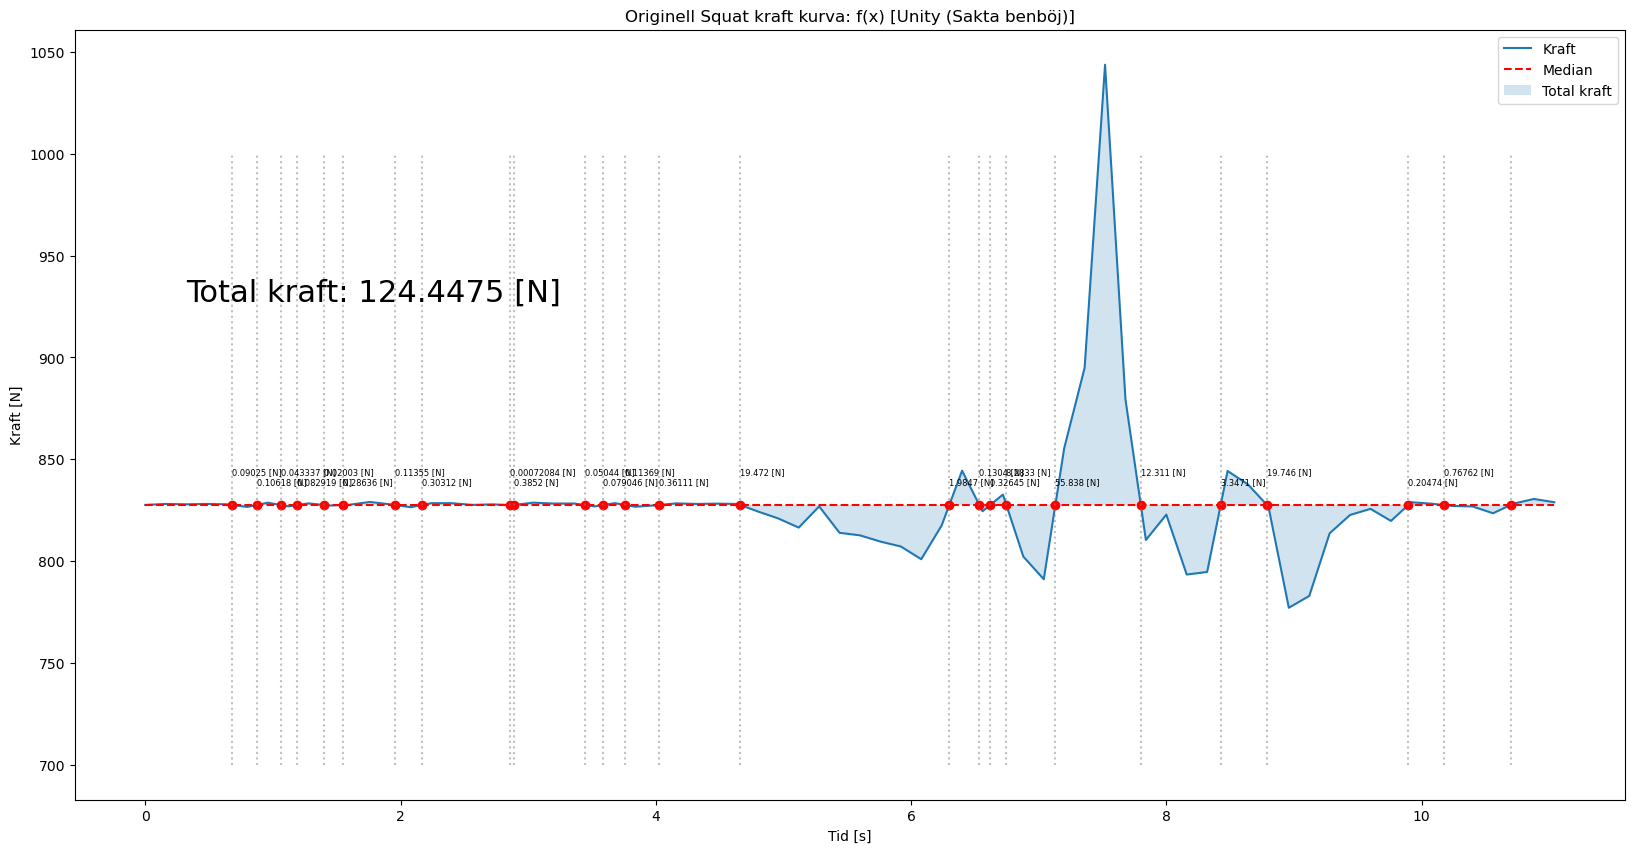

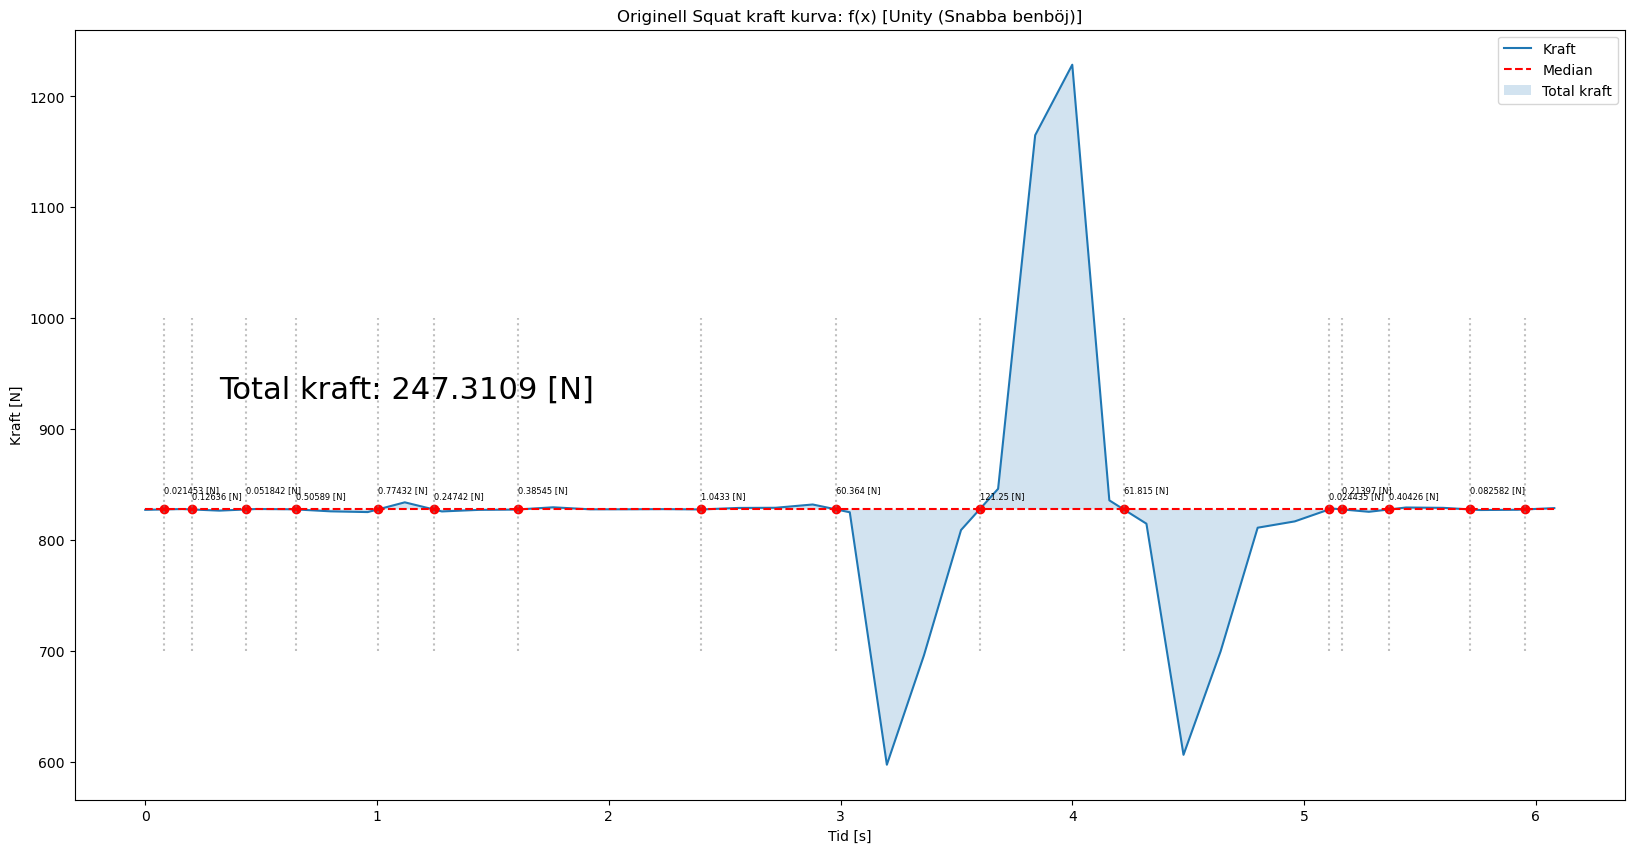

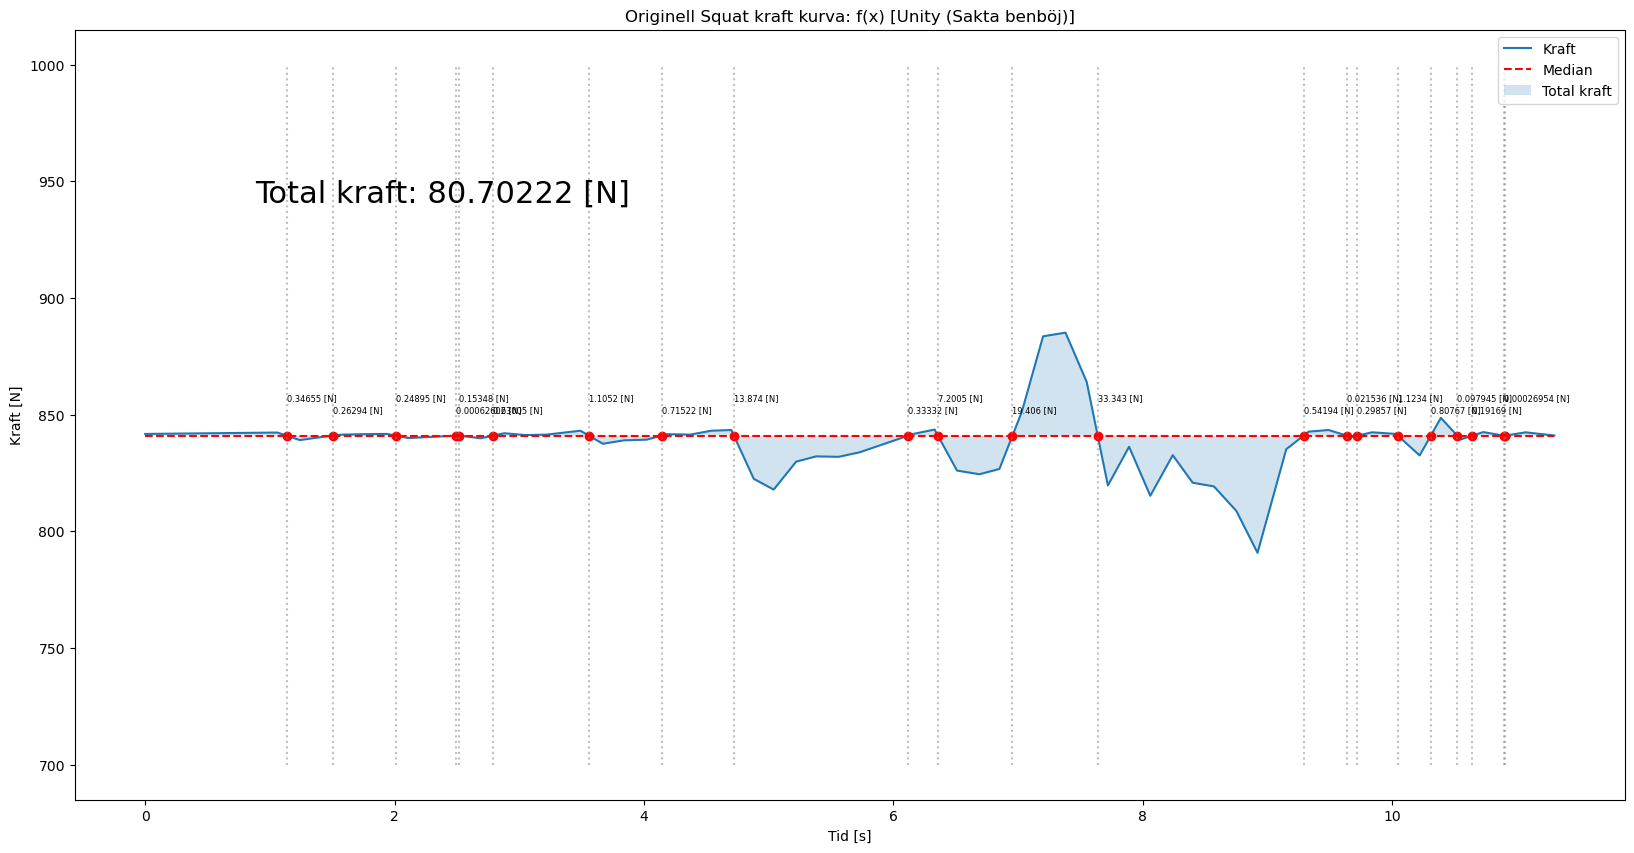

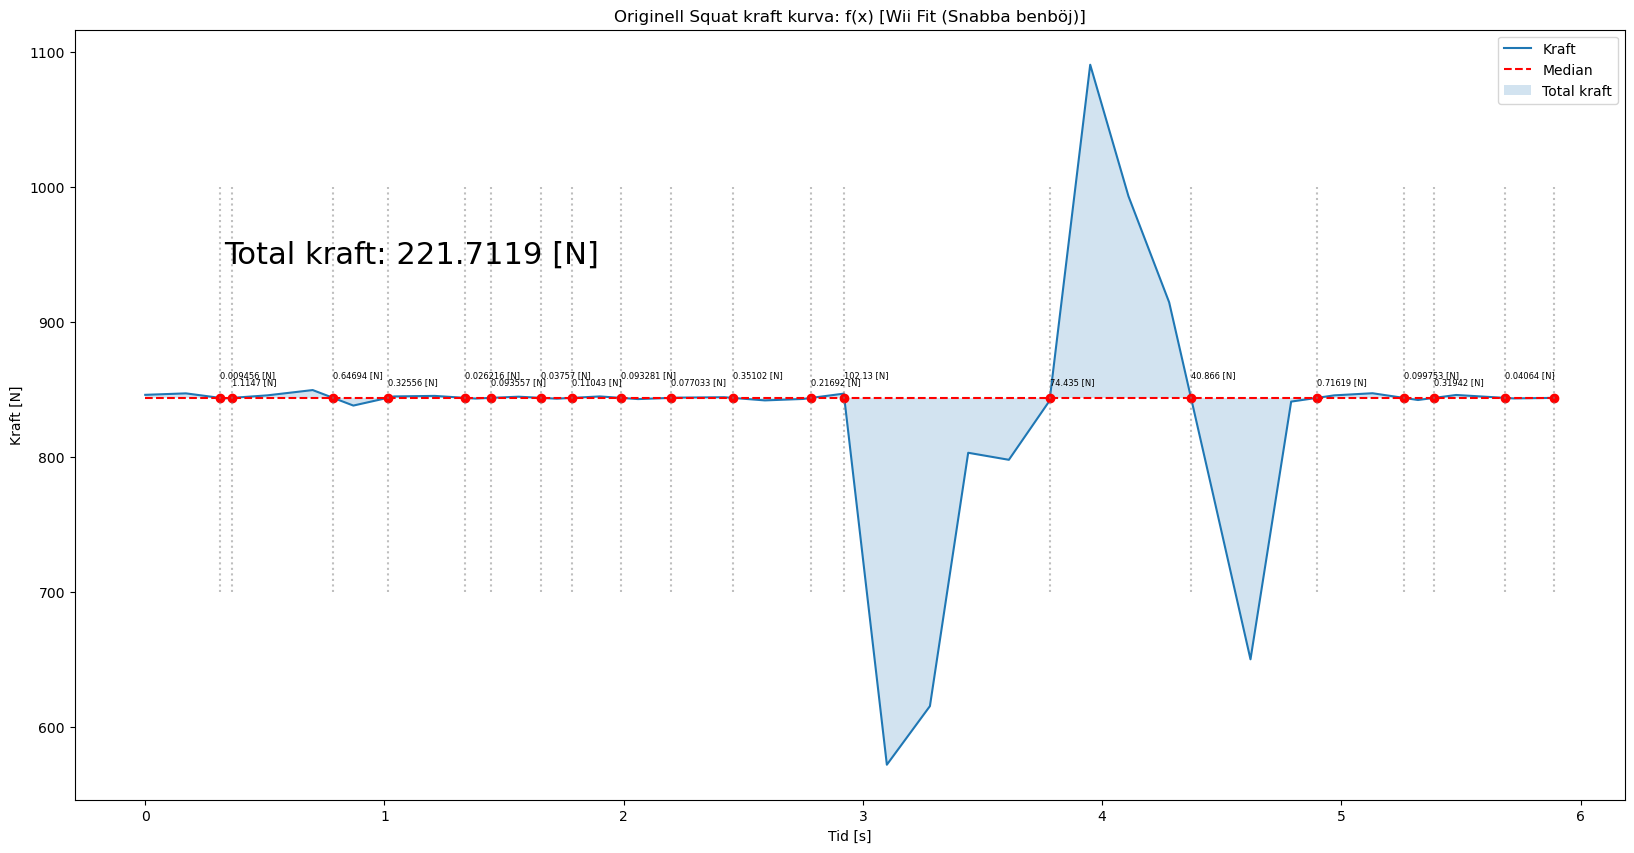

In [224]:
import numpy as np
import matplotlib.pyplot as plt

def getAndShowSurfaceOfDFWithMedian(dataframe, toRange, title):

    snippetOfGraph = dataframe[0:toRange]

    fig, (ax1) = plt.subplots(1, 1, figsize=(20,10))

    ax1.plot(snippetOfGraph['time'], snippetOfGraph['force'], label="Kraft")
    ax1.hlines(y=snippetOfGraph['force'].median(), colors=['red'], linestyles=['dashed'], xmin=snippetOfGraph['time'][0], xmax=snippetOfGraph['time'][snippetOfGraph.shape[0]-1], label="Median")
    ax1.set_xlabel("Tid [s]")
    ax1.set_ylabel("Kraft [N]")
    #ax1.grid()
    ax1.set_title(f"Originell Squat kraft kurva: f(x) [{title}]")


    from shapely.geometry import LineString

    medianArr = np.full(snippetOfGraph['force'].shape[0], snippetOfGraph['force'].median())

    line_1 = LineString(np.column_stack((snippetOfGraph['force'],snippetOfGraph['time'])))
    line_2 = LineString(np.column_stack((medianArr,snippetOfGraph['time'])))

    intersection = line_1.intersection(line_2)

    intersection.geoms

    time = []
    force = []
    for geom in intersection.geoms:
        if(type(geom) == LineString):
            for coord in geom.coords:
                time.append(coord[1])
                force.append(coord[0])
        else:    
            time.append(geom.y)
            force.append(geom.x)
    
    #ax1.plot(time, force, 'ro')
    #ax1.vlines(ymax=1000, ymin=700, x=time, linestyles="dotted", colors="gray", alpha=0.5)
    #ax1.fill_between(snippetOfGraph['time'], snippetOfGraph['force'], snippetOfGraph['force'].mean(), label="Total kraft", alpha=0.2)
    #ax1.fill_betweenx(y=np.arange(snippetOfGraph['force'].min(),snippetOfGraph['force'].max(),0.1), x1=time[0], x2=time[1], alpha=0.2, color="gray")


    # Sortera time och force listorna.
    sortedTime = []

    sortedForce = []

    i = 0


    while(len(time) != 0):
        i = time.index(min(time))
        sortedTime.append(min(time))    
        sortedForce.append(force[i])
        
        time.pop(i)
        force.pop(i)
        
    ax1.plot(sortedTime, sortedForce, 'ro')
    ax1.vlines(ymax=1000, ymin=700, x=sortedTime, linestyles="dotted", colors="gray", alpha=0.5)
    ax1.fill_between(snippetOfGraph['time'], snippetOfGraph['force'], snippetOfGraph['force'].median(), label="Total kraft", alpha=0.2)
    #ax1.fill_betweenx(y=np.arange(snippetOfGraph['force'].min(),snippetOfGraph['force'].max(),0.1), x1=time[0], x2=time[1], alpha=0.2, color="gray")


    # Integrera mellan de givna punkterna
    sumForce = 0
    pos = 0
    spacer = 1
    while(pos < len(sortedTime)):
        # Skapa scliecs av force och time variablerna
        if(pos == len(sortedTime)-1):
            break
        
        timeSlice = []
        forceSlice = []
        
        # Första värdet och sista värdet blir givet av sortedTime & sortedForce vilket är där linjerna korsar varann
        timeSlice.append(sortedTime[pos])
        forceSlice.append(sortedForce[pos])



        # Lägg in värden av snippetOfGraph['force] & snippetOfGraph['time'] i slices
        i = 0
        while(True):
            # Lägg till de värden som kommer imellan de två 'intersections' som finns.
            if(snippetOfGraph['time'][i] == sortedTime[pos] or snippetOfGraph['time'][i] < sortedTime[pos]):
                i = i + 1
                continue
            if(snippetOfGraph['time'][i] == sortedTime[pos + 1] or snippetOfGraph['time'][i] > sortedTime[pos + 1]):
                break

            timeSlice.append(snippetOfGraph['time'][i])
            forceSlice.append(snippetOfGraph['force'][i])
            i = i + 1
            
        
        timeSlice.append(sortedTime[pos+1])
        forceSlice.append(sortedForce[pos+1])
        
        #print(f"timeSlice (pos {pos} - {pos + 1}): {timeSlice}")
        

        # Utför en integral med cumulative_trapezoid    
        sliceIntegral1 = cumulative_trapezoid(y=forceSlice, x=timeSlice, initial=0)
        sliceIntegral2 = cumulative_trapezoid(y=np.full(len(forceSlice), fill_value=snippetOfGraph['force'].median()), x=timeSlice, initial=0)        
        diff = sliceIntegral1[len(sliceIntegral1) - 1] - sliceIntegral2[len(sliceIntegral2) - 1] 
        
        if(diff < 0):
            diff = diff * -1
        
        #print(f"Integral values: {sliceIntegral}")
        #print(f"Integral value: {sliceIntegral[len(sliceIntegral)-1]} [N]\n")


        # Ta det sista värdet i arreyen som funktionen returnarar.
        # Som sist addera integralvärdet till en summa.
        ax1.text(sortedTime[pos], snippetOfGraph['force'].median() + 10 + 5 * spacer, f'{diff:.5} [N]', fontsize = 6)
        sumForce = sumForce + diff
        if(spacer == 1):
            spacer = 0
        else:
            spacer = 1
            
        # Gå till nästa punkt.
        pos = pos + 1

    ax1.text(snippetOfGraph['time'][2], snippetOfGraph['force'].median() + 100, f'Total kraft: {sumForce:.7} [N]', fontsize = 22)

    ax1.legend()
    plt.show()

getAndShowSurfaceOfDFWithMedian(unitySlowDF, 70, "Unity (Sakta benböj)")
getAndShowSurfaceOfDFWithMedian(unityFastDF, 39, "Unity (Snabba benböj)")


getAndShowSurfaceOfDFWithMedian(wiiFitSlowDF, 60, "Unity (Sakta benböj)")
getAndShowSurfaceOfDFWithMedian(wiiFitFastDF, 35, "Wii Fit (Snabba benböj)")



Nedan 'plottas' några simpla grafer.

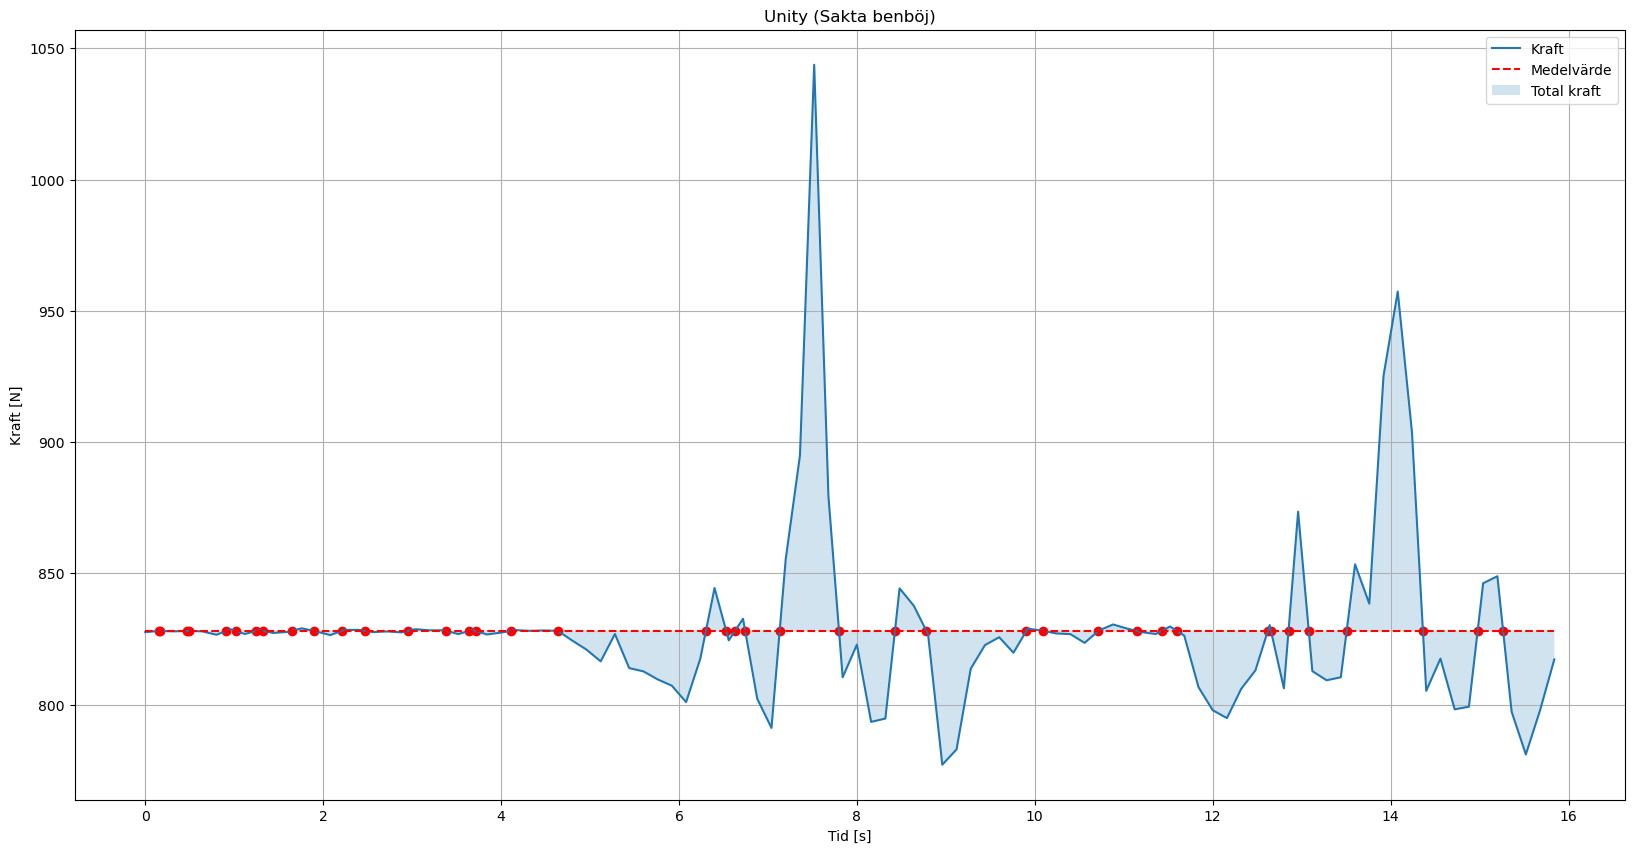

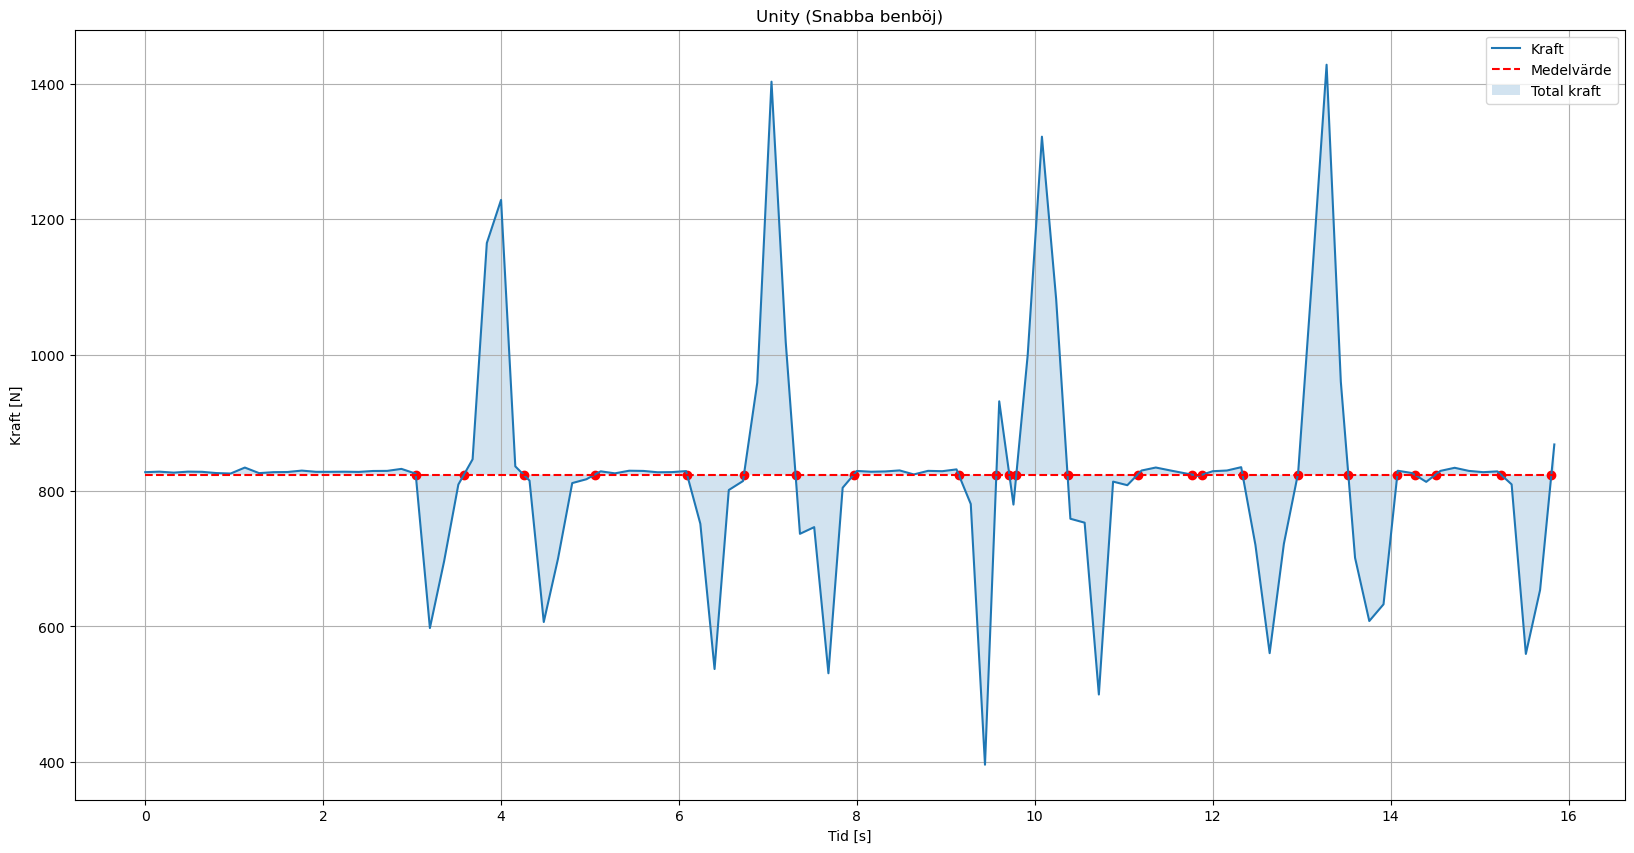

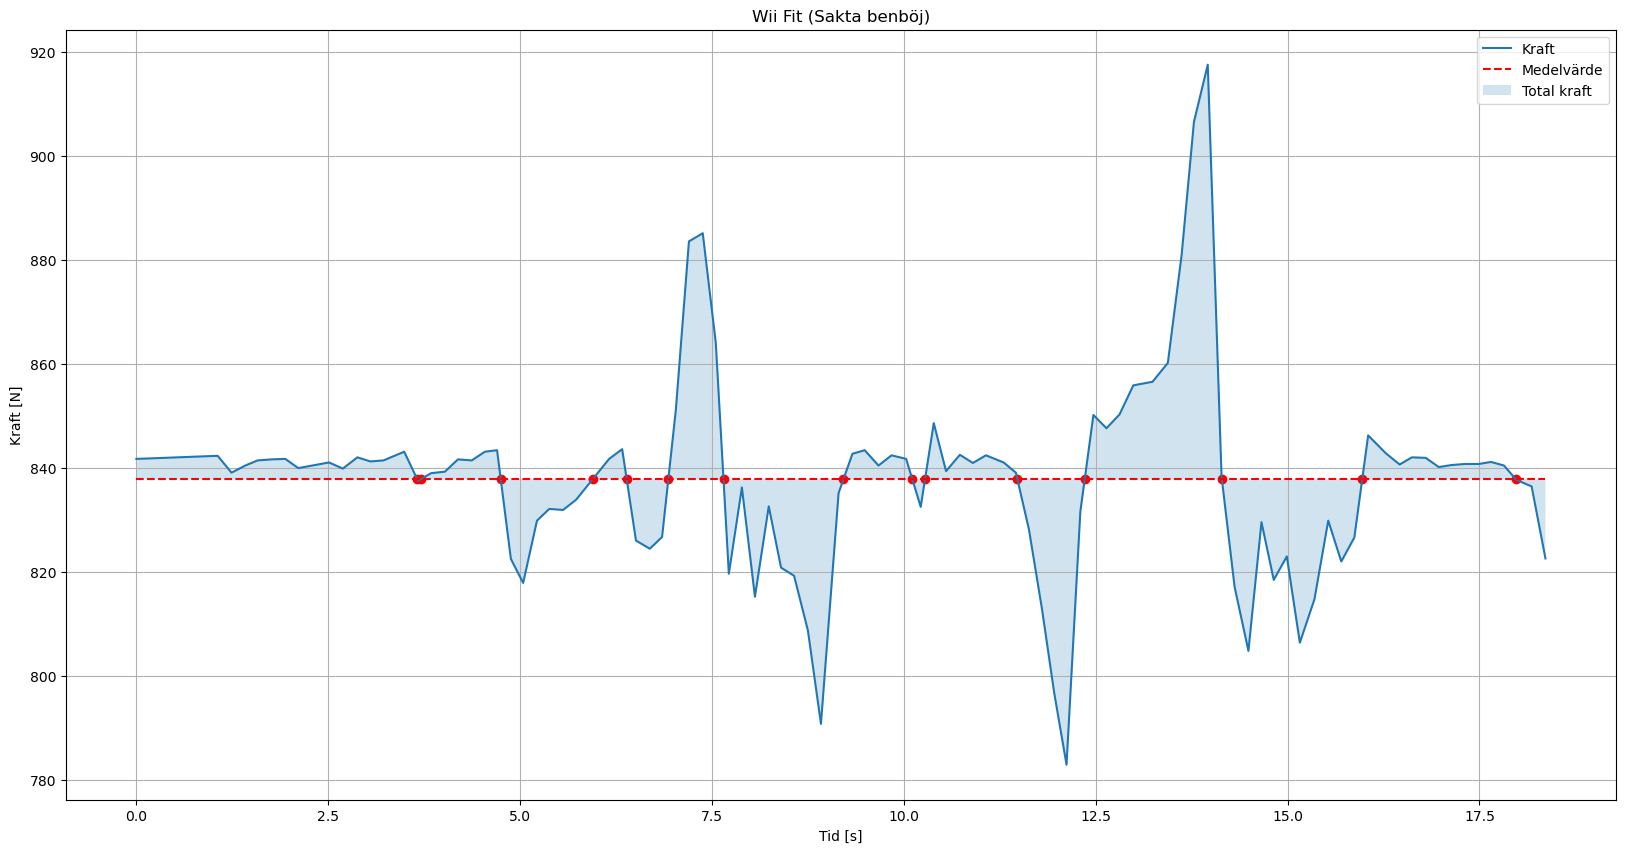

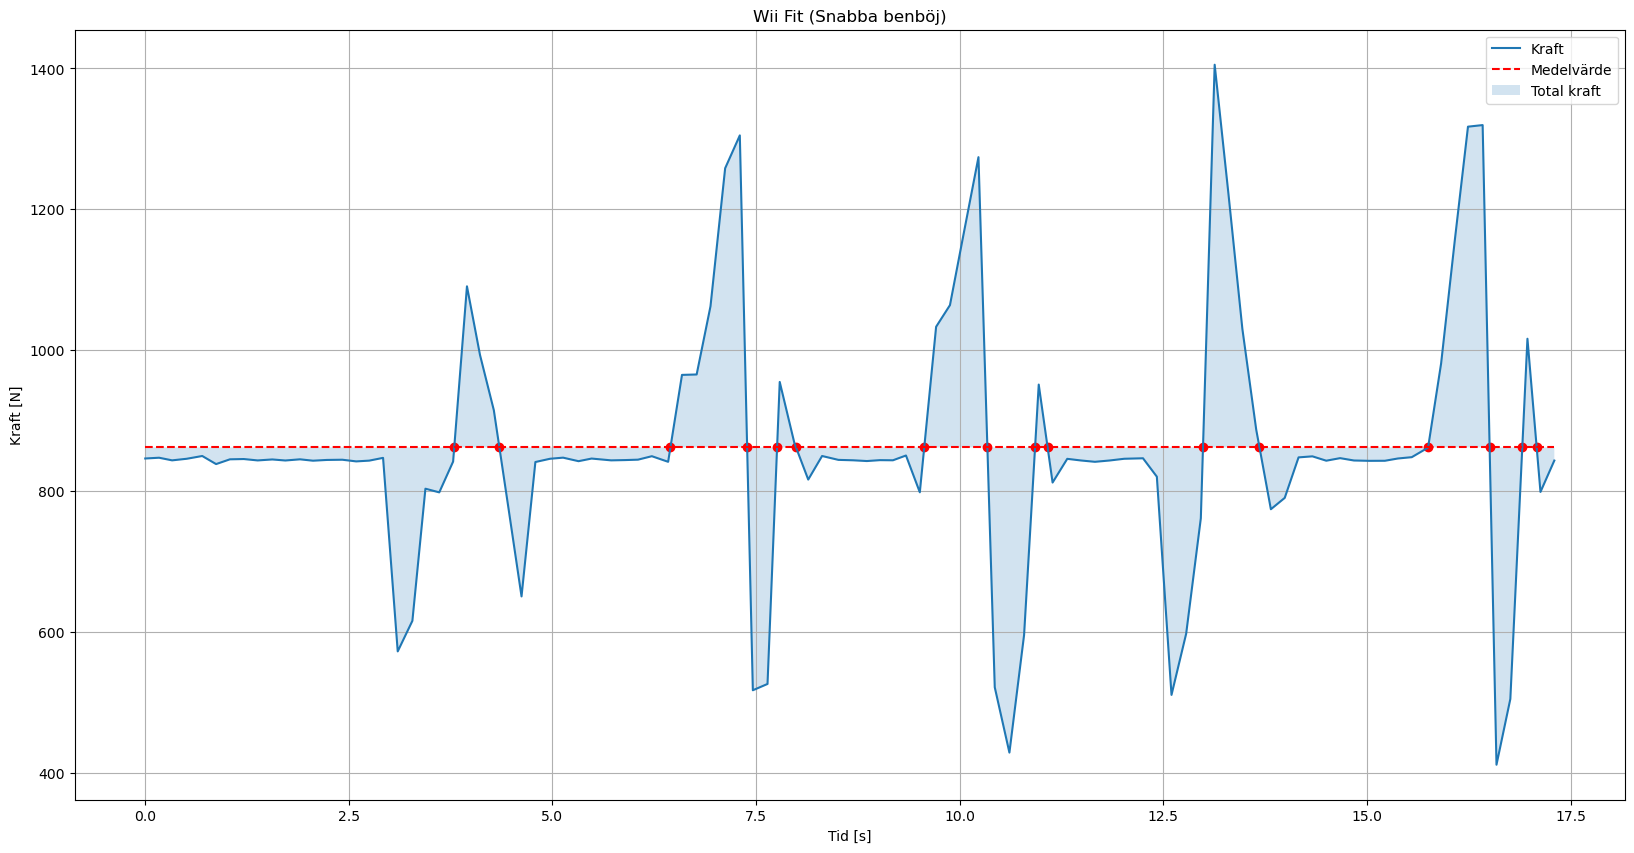

In [226]:
def plotSimpleGraphWithShading(df, rangeTo, title):
    from shapely.geometry import LineString

    snippetOfGraph = df[0:rangeTo]

    fig, (ax1) = plt.subplots(1, 1, figsize=(20,10))

    meanArr = np.full(snippetOfGraph['force'].shape[0], snippetOfGraph['force'].mean())

    line_1 = LineString(np.column_stack((snippetOfGraph['force'],snippetOfGraph['time'])))
    line_2 = LineString(np.column_stack((meanArr,snippetOfGraph['time'])))

    intersection = line_1.intersection(line_2)

    #intersection.geoms
    time = []
    force = []
    for geom in intersection.geoms:
        if(type(geom) == LineString):
            for coord in geom.coords:
                time.append(coord[1])
                force.append(coord[0])
        else:    
            time.append(geom.y)
            force.append(geom.x)
    
    ax1.plot(time, force, 'ro')


    ax1.plot(snippetOfGraph['time'], snippetOfGraph['force'], label="Kraft")
    ax1.hlines(y=snippetOfGraph['force'].mean(), colors=['red'], linestyles=['dashed'], xmin=snippetOfGraph['time'][0], xmax=snippetOfGraph['time'][snippetOfGraph.shape[0]-1], label="Medelvärde")
    ax1.set_xlabel("Tid [s]")
    ax1.set_ylabel("Kraft [N]")
    ax1.fill_between(snippetOfGraph['time'], snippetOfGraph['force'], snippetOfGraph['force'].mean(), label="Total kraft", alpha=0.2)
    ax1.set_title(title)
    ax1.legend()
    ax1.grid()

    plt.show()
    
plotSimpleGraphWithShading(unitySlowDF, 100, "Unity (Sakta benböj)")
plotSimpleGraphWithShading(unityFastDF, 100, "Unity (Snabba benböj)")

plotSimpleGraphWithShading(wiiFitSlowDF, 100, "Wii Fit (Sakta benböj)")
plotSimpleGraphWithShading(wiiFitFastDF, 100, "Wii Fit (Snabba benböj)")


Nedan integreras värdena med **'mean'** som mitt-axel och värdena för var område skrivs även ut i grafen.

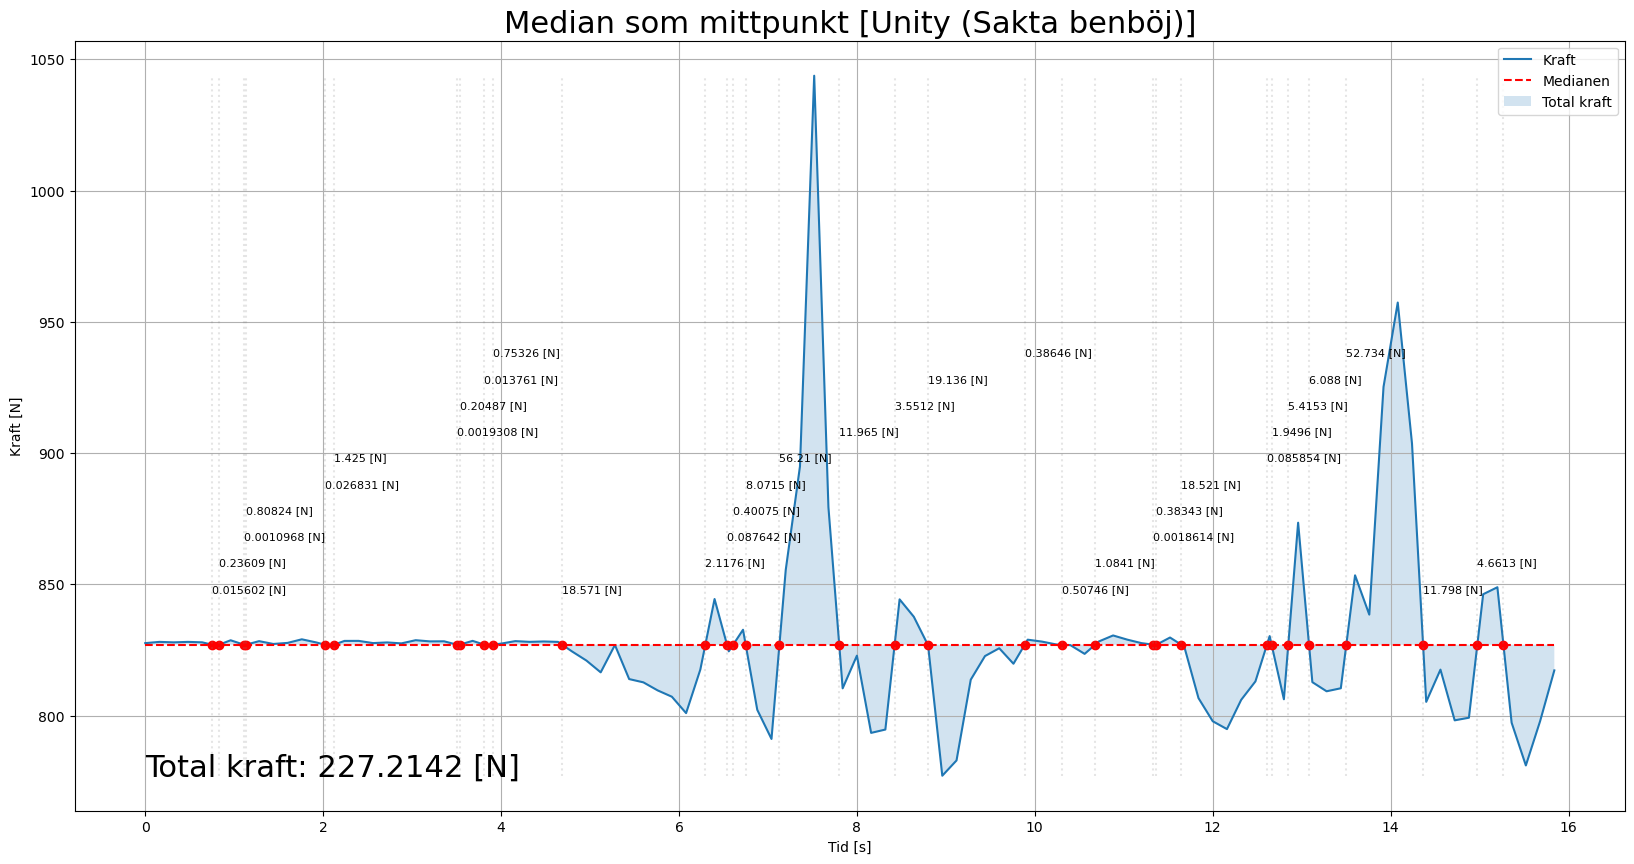

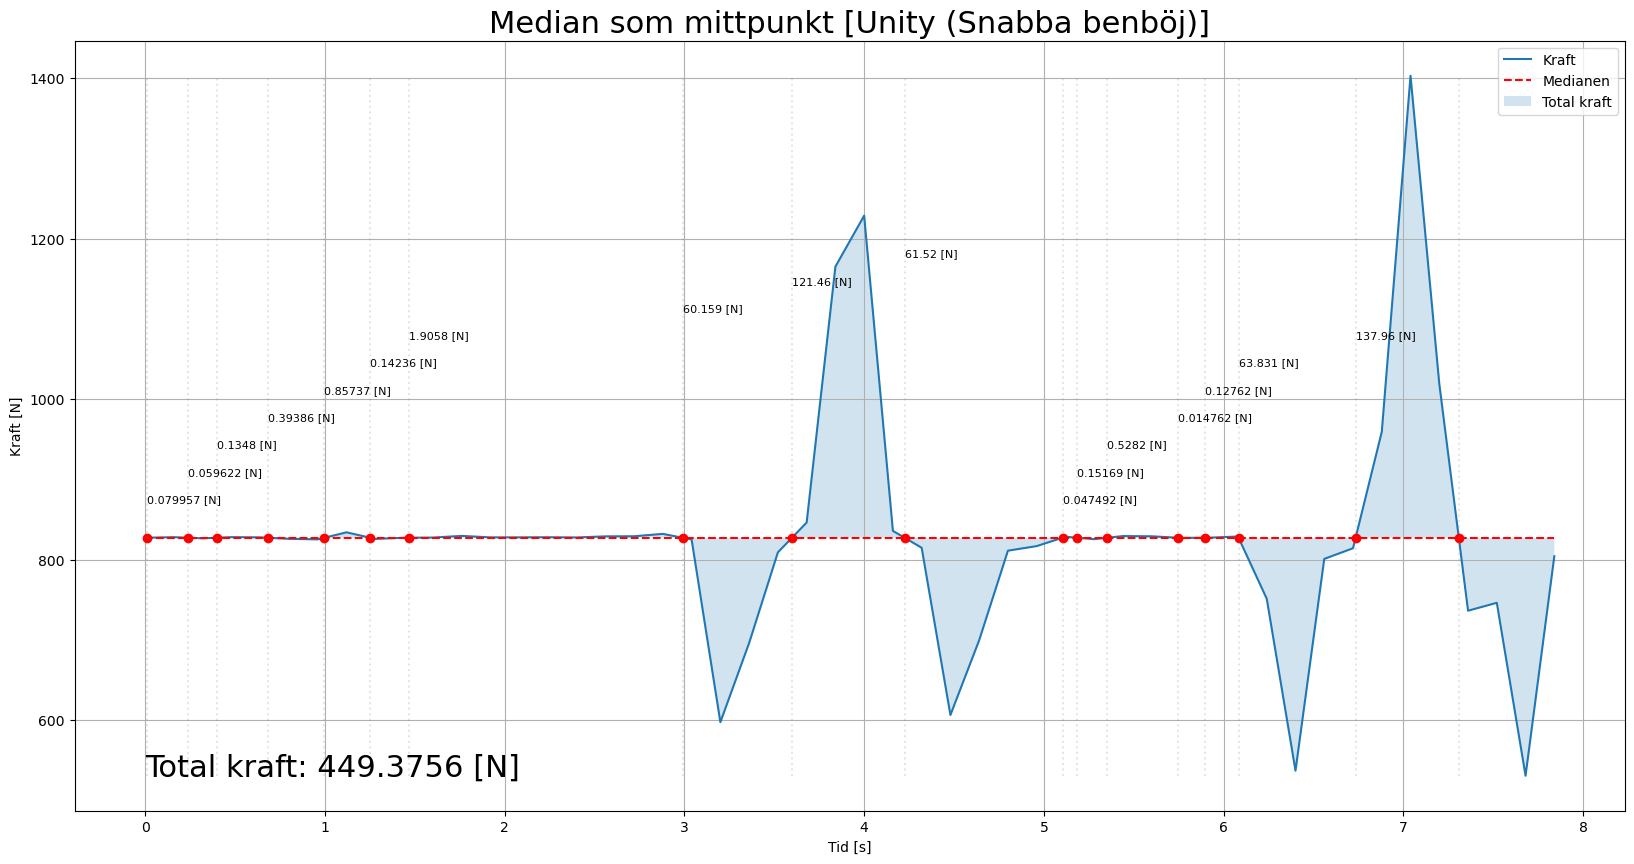

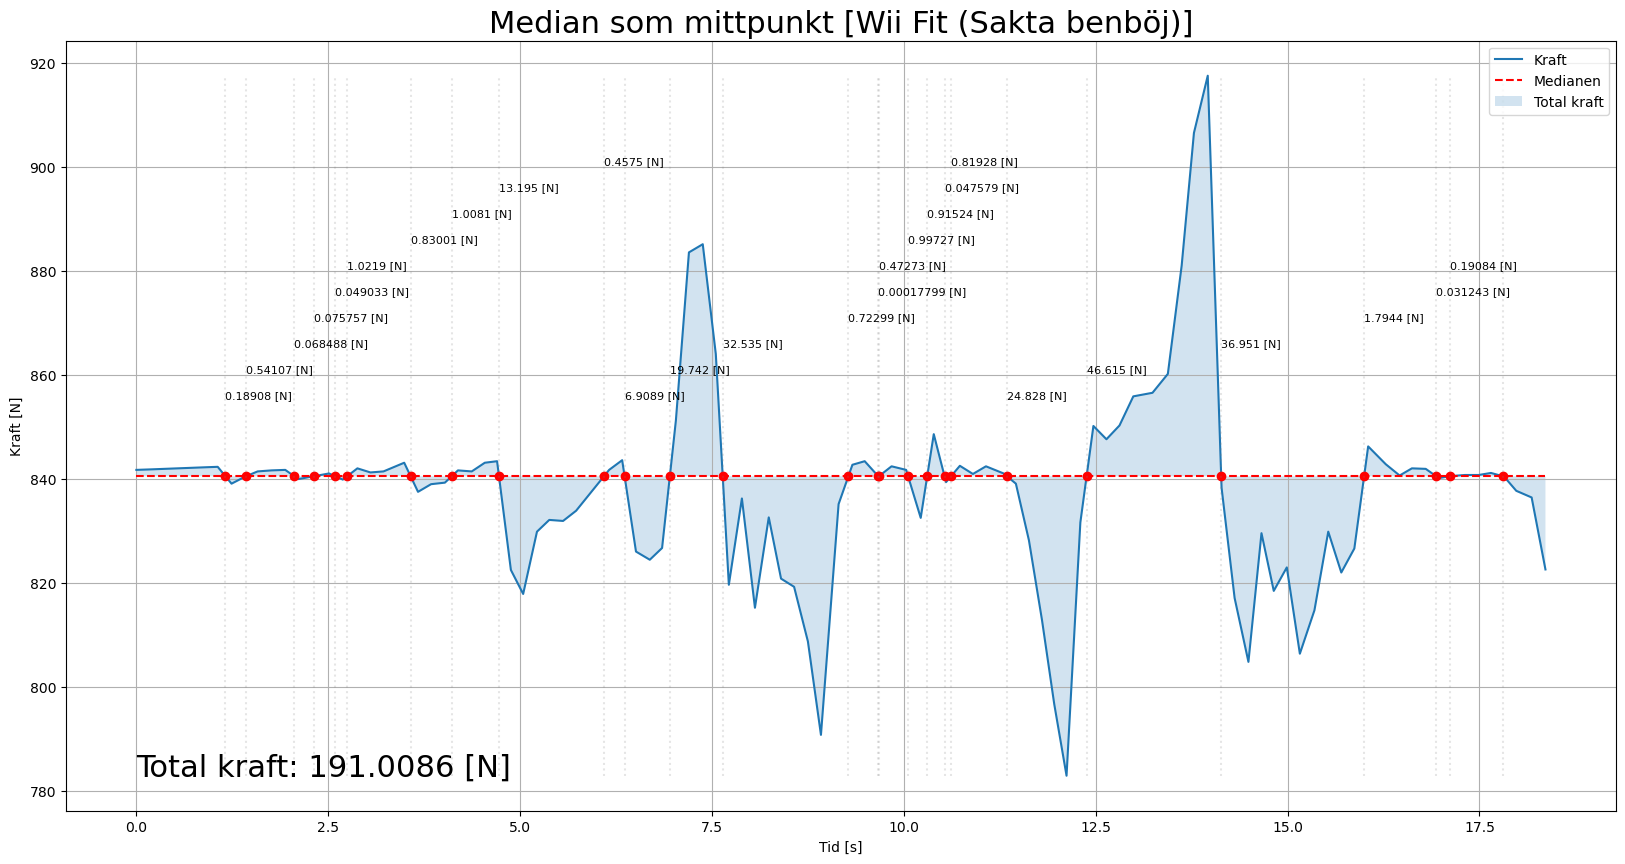

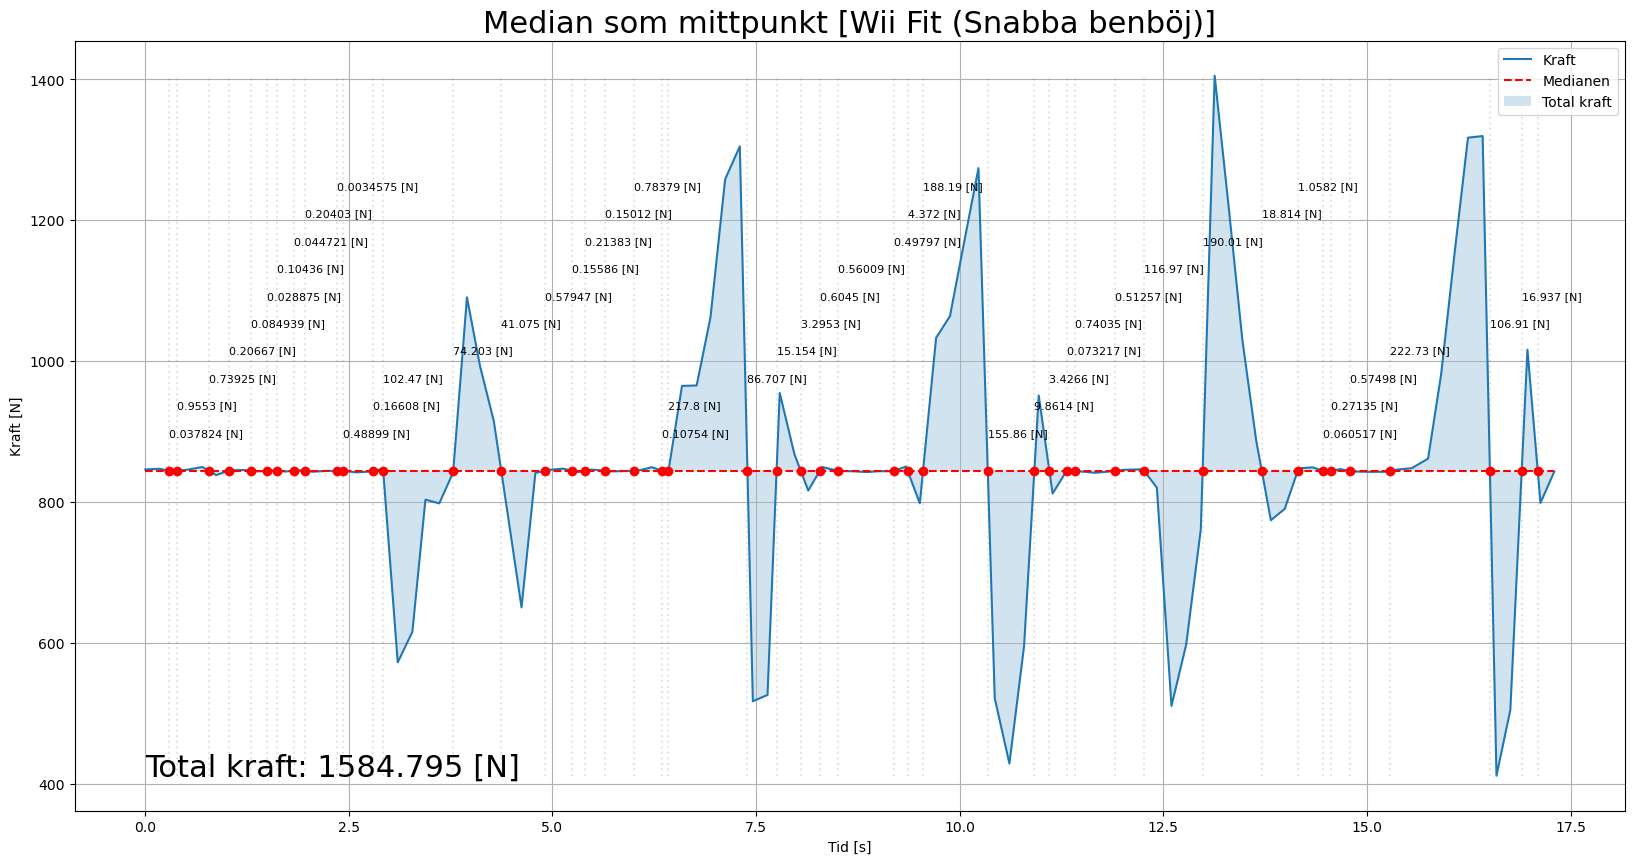

In [245]:
def integrateDFwithMedian(dataframe, title, rangeTo):
    from shapely.geometry import LineString
    
    snippetOfGraph = dataframe[0:rangeTo]

    fig, (ax1) = plt.subplots(1, 1, figsize=(20,10))

    medianArr = np.full(snippetOfGraph['force'].shape[0], snippetOfGraph['force'].median())


    line_1 = LineString(np.column_stack((snippetOfGraph['force'],snippetOfGraph['time'])))
    line_2 = LineString(np.column_stack((medianArr,snippetOfGraph['time'])))

    intersection = line_1.intersection(line_2)

    #intersection.geoms
    time = []
    force = []
    for geom in intersection.geoms:
        if(type(geom) == LineString):
            for coord in geom.coords:
                time.append(coord[1])
                force.append(coord[0])
        else:    
            time.append(geom.y)
            force.append(geom.x)


    ## Bytte mittenlinjen till median istället för mean för att testa
    ax1.plot(snippetOfGraph['time'], snippetOfGraph['force'], label="Kraft")
    ax1.hlines(y=snippetOfGraph['force'].median(), colors=['red'], linestyles=['dashed'], xmin=snippetOfGraph['time'][0], xmax=snippetOfGraph['time'][snippetOfGraph.shape[0]-1], label="Medianen")
    ax1.set_xlabel("Tid [s]")
    ax1.set_ylabel("Kraft [N]")
    ax1.fill_between(snippetOfGraph['time'], snippetOfGraph['force'], snippetOfGraph['force'].median(), label="Total kraft", alpha=0.2)
    ax1.grid()
    ax1.set_title(f"Median som mittpunkt [{title}]", fontsize=22)



    # Sortera time och force listorna.
    sortedTime = []

    sortedForce = []

    i = 0


    while(len(time) != 0):
        i = time.index(min(time))
        sortedTime.append(min(time))    
        sortedForce.append(force[i])
        
        time.pop(i)
        force.pop(i)
        
    ax1.plot(sortedTime, sortedForce, 'ro')
    ax1.vlines(ymax=snippetOfGraph['force'].max(), ymin=snippetOfGraph['force'].min(), x=sortedTime, linestyles="dotted", colors="gray", alpha=0.2)
    #ax1.fill_betweenx(y=np.arange(snippetOfGraph['force'].min(),snippetOfGraph['force'].max(),0.1), x1=time[0], x2=time[1], alpha=0.2, color="gray")


    # Integrera mellan de givna punkterna
    sumForce = 0
    pos = 0
    spacer = 1
    while(pos < len(sortedTime)):
        # Skapa scliecs av force och time variablerna
        if(pos == len(sortedTime)-1):
            break
        
        timeSlice = []
        forceSlice = []
        
        # Första värdet och sista värdet blir givet av sortedTime & sortedForce vilket är där linjerna korsar varann
        timeSlice.append(sortedTime[pos])
        forceSlice.append(sortedForce[pos])



        # Lägg in värden av snippetOfGraph['force] & snippetOfGraph['time'] i slices
        i = 0
        while(True):
            # Lägg till de värden som kommer imellan de två 'intersections' som finns.
            if(snippetOfGraph['time'][i] == sortedTime[pos] or snippetOfGraph['time'][i] < sortedTime[pos]):
                i = i + 1
                continue
            if(snippetOfGraph['time'][i] == sortedTime[pos + 1] or snippetOfGraph['time'][i] > sortedTime[pos + 1]):
                break

            timeSlice.append(snippetOfGraph['time'][i])
            forceSlice.append(snippetOfGraph['force'][i])
            i = i + 1
            
        
        timeSlice.append(sortedTime[pos+1])
        forceSlice.append(sortedForce[pos+1])
        
        #print(f"timeSlice (pos {pos} - {pos + 1}): {timeSlice}")
        

        # Utför en integral med cumulative_trapezoid    
        # Utför en integral med cumulative_trapezoid    
        sliceIntegral1 = cumulative_trapezoid(y=forceSlice, x=timeSlice, initial=0)
        sliceIntegral2 = cumulative_trapezoid(y=np.full(len(forceSlice), fill_value=snippetOfGraph['force'].median()), x=timeSlice, initial=0)        
        diff = sliceIntegral1[len(sliceIntegral1) - 1] - sliceIntegral2[len(sliceIntegral2) - 1] 
        
        if(diff < 0):
            diff = diff * -1
        #print(f"Integral values: {sliceIntegral}")
        #print(f"Integral value: {sliceIntegral[len(sliceIntegral)-1]} [N]\n")


        # Ta det sista värdet i arreyen som funktionen returnarar.
        # Som sist addera integralvärdet till en summa.
        padding = int((snippetOfGraph['force'].max() - snippetOfGraph['force'].min())/25)
        ax1.text(sortedTime[pos], snippetOfGraph['force'].median() + 10 + padding * spacer, f'{diff:.5} [N]', fontsize = 8)
        sumForce = sumForce + diff
        
        if(spacer%10 == 0):
            spacer = 1
        else:
            spacer = spacer + 1
            
        # Gå till nästa punkt.
        pos = pos + 1

    ax1.text(0, snippetOfGraph['force'].min(), f'Total kraft: {sumForce:.7} [N]', fontsize = 22)

    ax1.legend()
    plt.show()

integrateDFwithMedian(unitySlowDF, "Unity (Sakta benböj)", 100)
integrateDFwithMedian(unityFastDF, "Unity (Snabba benböj)", 50)

integrateDFwithMedian(wiiFitSlowDF, "Wii Fit (Sakta benböj)", 100)
integrateDFwithMedian(wiiFitFastDF, "Wii Fit (Snabba benböj)", 100)



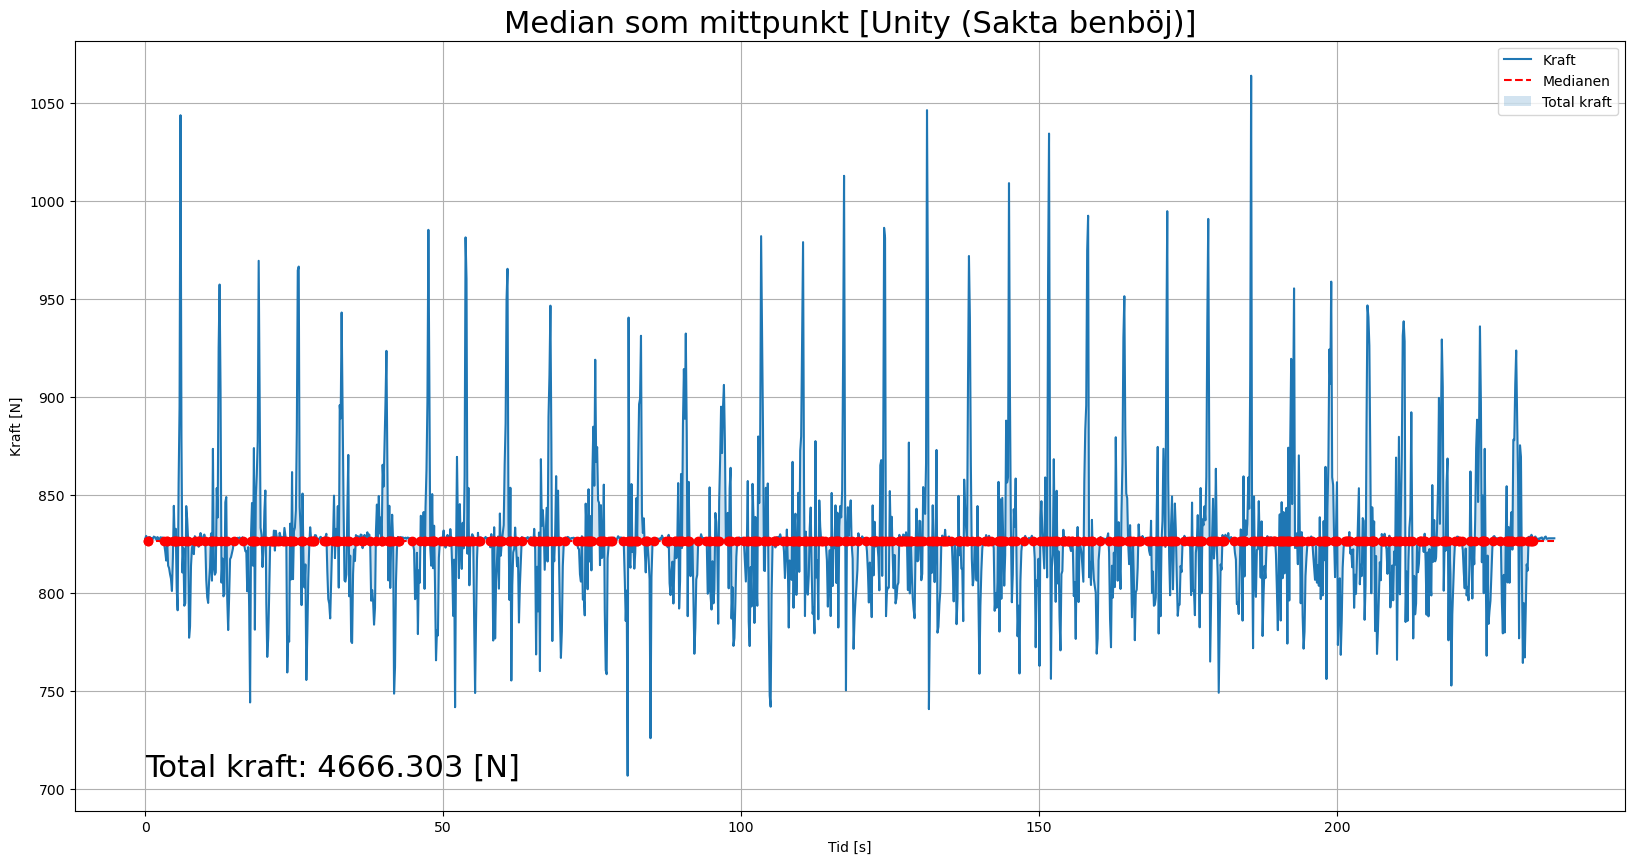

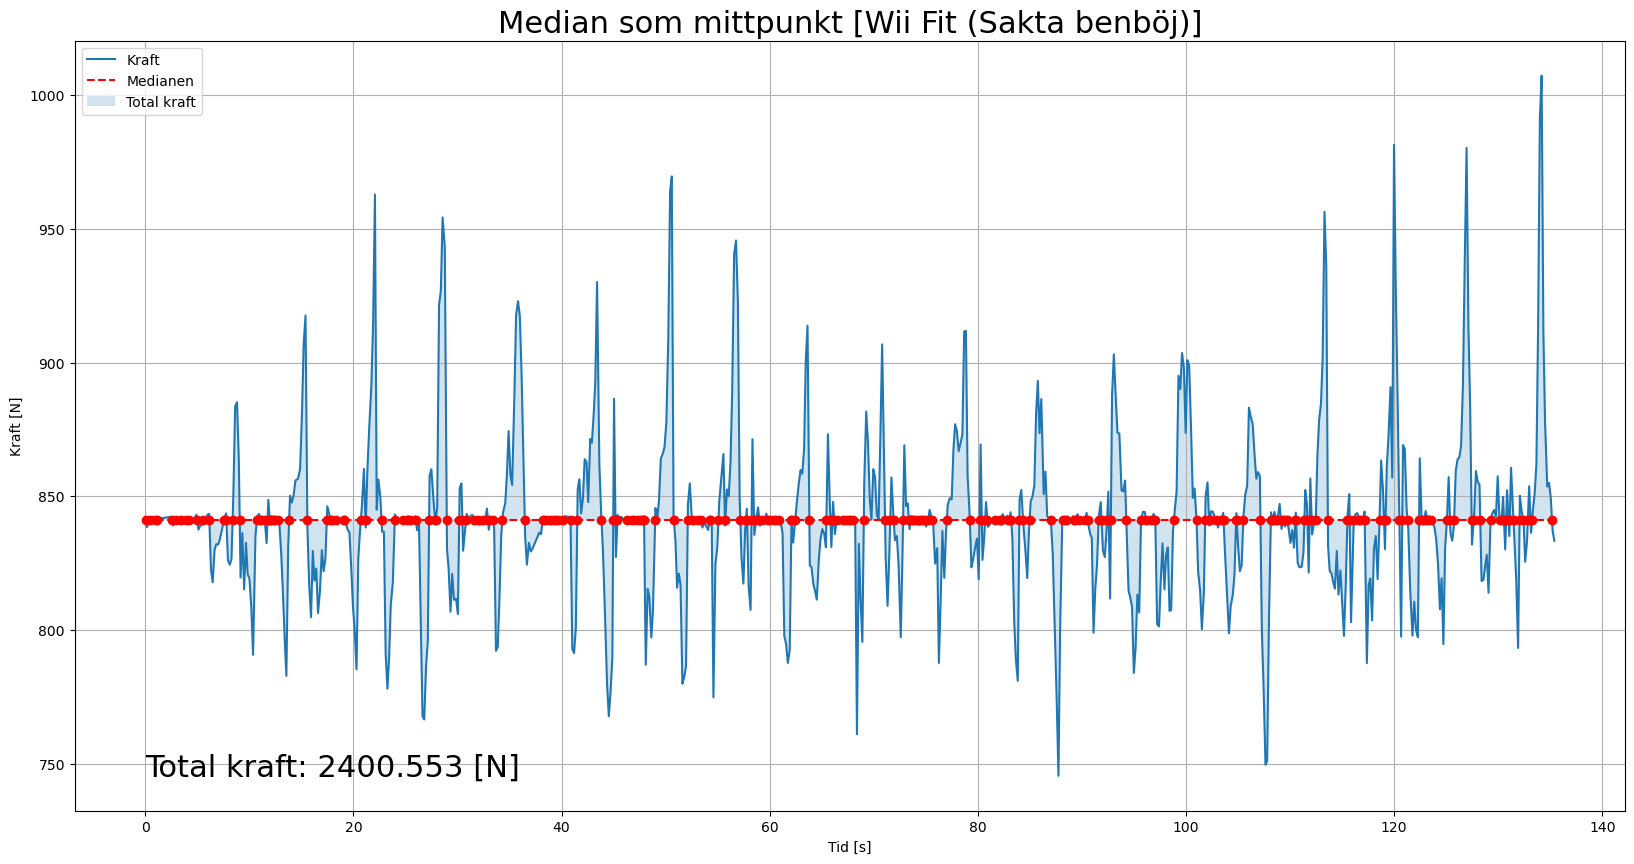

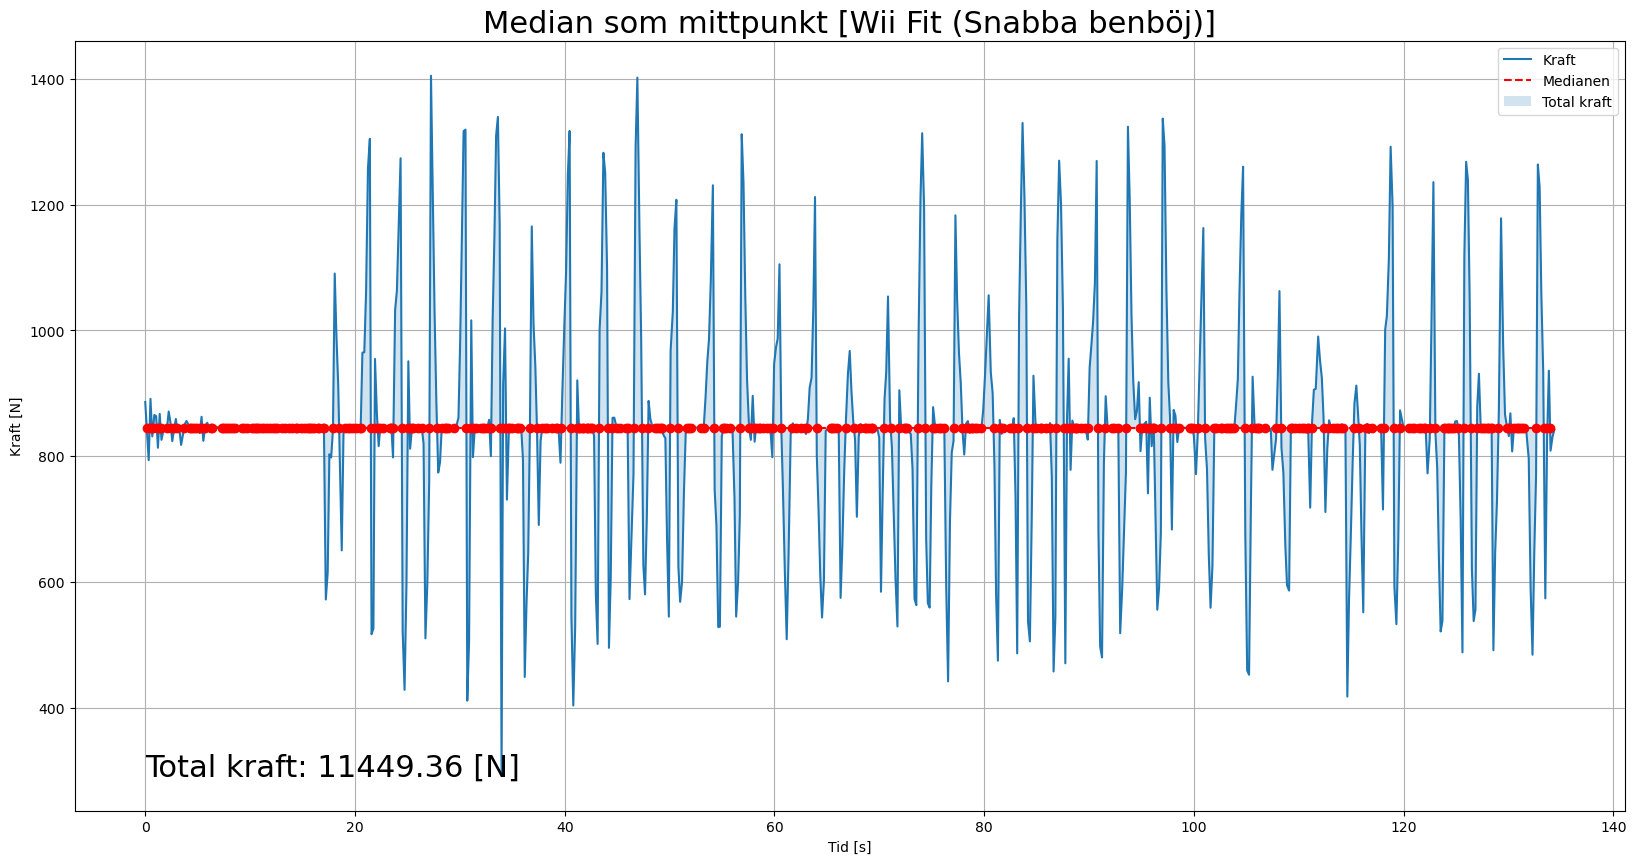

In [268]:


def integrateDFwithMedian(dataframe, title, rangeTo, showText, showLines):
    from shapely.geometry import LineString
    snippetOfGraph = dataframe[0:rangeTo]

    fig, (ax1) = plt.subplots(1, 1, figsize=(20,10))

    medianArr = np.full(snippetOfGraph['force'].shape[0], snippetOfGraph['force'].median())


    line_1 = LineString(np.column_stack((snippetOfGraph['force'],snippetOfGraph['time'])))
    line_2 = LineString(np.column_stack((medianArr,snippetOfGraph['time'])))

    intersection = line_1.intersection(line_2)

    #intersection.geoms
    time = []
    force = []
    for geom in intersection.geoms:
        if(type(geom) == LineString):
            for coord in geom.coords:
                time.append(coord[1])
                force.append(coord[0])
        else:    
            time.append(geom.y)
            force.append(geom.x)


    ## Bytte mittenlinjen till median istället för mean för att testa
    ax1.plot(snippetOfGraph['time'], snippetOfGraph['force'], label="Kraft")
    ax1.hlines(y=snippetOfGraph['force'].median(), colors=['red'], linestyles=['dashed'], xmin=snippetOfGraph['time'][0], xmax=snippetOfGraph['time'][snippetOfGraph.shape[0]-1], label="Medianen")
    ax1.set_xlabel("Tid [s]")
    ax1.set_ylabel("Kraft [N]")
    ax1.fill_between(snippetOfGraph['time'], snippetOfGraph['force'], snippetOfGraph['force'].median(), label="Total kraft", alpha=0.2)
    ax1.grid()
    ax1.set_title(f"Median som mittpunkt [{title}]", fontsize=22)



    # Sortera time och force listorna.
    sortedTime = []

    sortedForce = []

    i = 0


    while(len(time) != 0):
        i = time.index(min(time))
        sortedTime.append(min(time))    
        sortedForce.append(force[i])
        
        time.pop(i)
        force.pop(i)
        
    ax1.plot(sortedTime, sortedForce, 'ro')
    if(showLines == True):
        ax1.vlines(ymax=snippetOfGraph['force'].max(), ymin=snippetOfGraph['force'].min(), x=sortedTime, linestyles="dotted", colors="gray", alpha=0.2)
    #ax1.fill_betweenx(y=np.arange(snippetOfGraph['force'].min(),snippetOfGraph['force'].max(),0.1), x1=time[0], x2=time[1], alpha=0.2, color="gray")


    # Integrera mellan de givna punkterna
    sumForce = 0
    pos = 0
    spacer = 1
    while(pos < len(sortedTime)):
        # Skapa scliecs av force och time variablerna
        if(pos == len(sortedTime)-1):
            break
        
        timeSlice = []
        forceSlice = []
        
        # Första värdet och sista värdet blir givet av sortedTime & sortedForce vilket är där linjerna korsar varann
        timeSlice.append(sortedTime[pos])
        forceSlice.append(sortedForce[pos])



        # Lägg in värden av snippetOfGraph['force] & snippetOfGraph['time'] i slices
        i = 0
        while(True):
            # Lägg till de värden som kommer imellan de två 'intersections' som finns.
            if(snippetOfGraph['time'][i] == sortedTime[pos] or snippetOfGraph['time'][i] < sortedTime[pos]):
                i = i + 1
                continue
            if(snippetOfGraph['time'][i] == sortedTime[pos + 1] or snippetOfGraph['time'][i] > sortedTime[pos + 1]):
                break

            timeSlice.append(snippetOfGraph['time'][i])
            forceSlice.append(snippetOfGraph['force'][i])
            i = i + 1
            
        
        timeSlice.append(sortedTime[pos+1])
        forceSlice.append(sortedForce[pos+1])
        
        #print(f"timeSlice (pos {pos} - {pos + 1}): {timeSlice}")
        

        # Utför en integral med cumulative_trapezoid    
        # Utför en integral med cumulative_trapezoid    
        sliceIntegral1 = cumulative_trapezoid(y=forceSlice, x=timeSlice, initial=0)
        sliceIntegral2 = cumulative_trapezoid(y=np.full(len(forceSlice), fill_value=snippetOfGraph['force'].median()), x=timeSlice, initial=0)        
        diff = sliceIntegral1[len(sliceIntegral1) - 1] - sliceIntegral2[len(sliceIntegral2) - 1] 
        
        if(diff < 0):
            diff = diff * -1
        #print(f"Integral values: {sliceIntegral}")
        #print(f"Integral value: {sliceIntegral[len(sliceIntegral)-1]} [N]\n")


        # Ta det sista värdet i arreyen som funktionen returnarar.
        # Som sist addera integralvärdet till en summa.
        if(showText):
            ax1.text(sortedTime[pos], snippetOfGraph['force'].median() + 10 + 20 * spacer, f'{diff:.5} [N]', fontsize = 8)
        sumForce = sumForce + diff
        
        if(spacer%10 == 0):
            spacer = 1
        else:
            spacer = spacer + 1
            
        # Gå till nästa punkt.
        pos = pos + 1

    ax1.text(0, snippetOfGraph['force'].min(), f'Total kraft: {sumForce:.7} [N]', fontsize = 22)

    ax1.legend()
    plt.show()

integrateDFwithMedian(unitySlowDF, "Unity (Sakta benböj)", unitySlowDF['time'].shape[0], False, False)
#integrateDFwithMedian(unityFastDF, "Unity (Snabba benböj)", unityFastDF['time'].shape[0], False, False)


integrateDFwithMedian(wiiFitSlowDF, "Wii Fit (Sakta benböj)", 760, False, False)
integrateDFwithMedian(wiiFitFastDF, "Wii Fit (Snabba benböj)", 760, False, False)



## Lokal maximi och minipunkter för var benböjs beräkning.

För att få ut derivatan får man gå tillbaks till grunden för vad derivata är.  
y = kx + m => k = Δy / Δx => k = y2- y1 / x2 - x1

[[Källa]](https://stackoverflow.com/questions/69000410/extract-and-plot-the-first-derivative-of-a-curve-in-python-without-knowing-its-f)

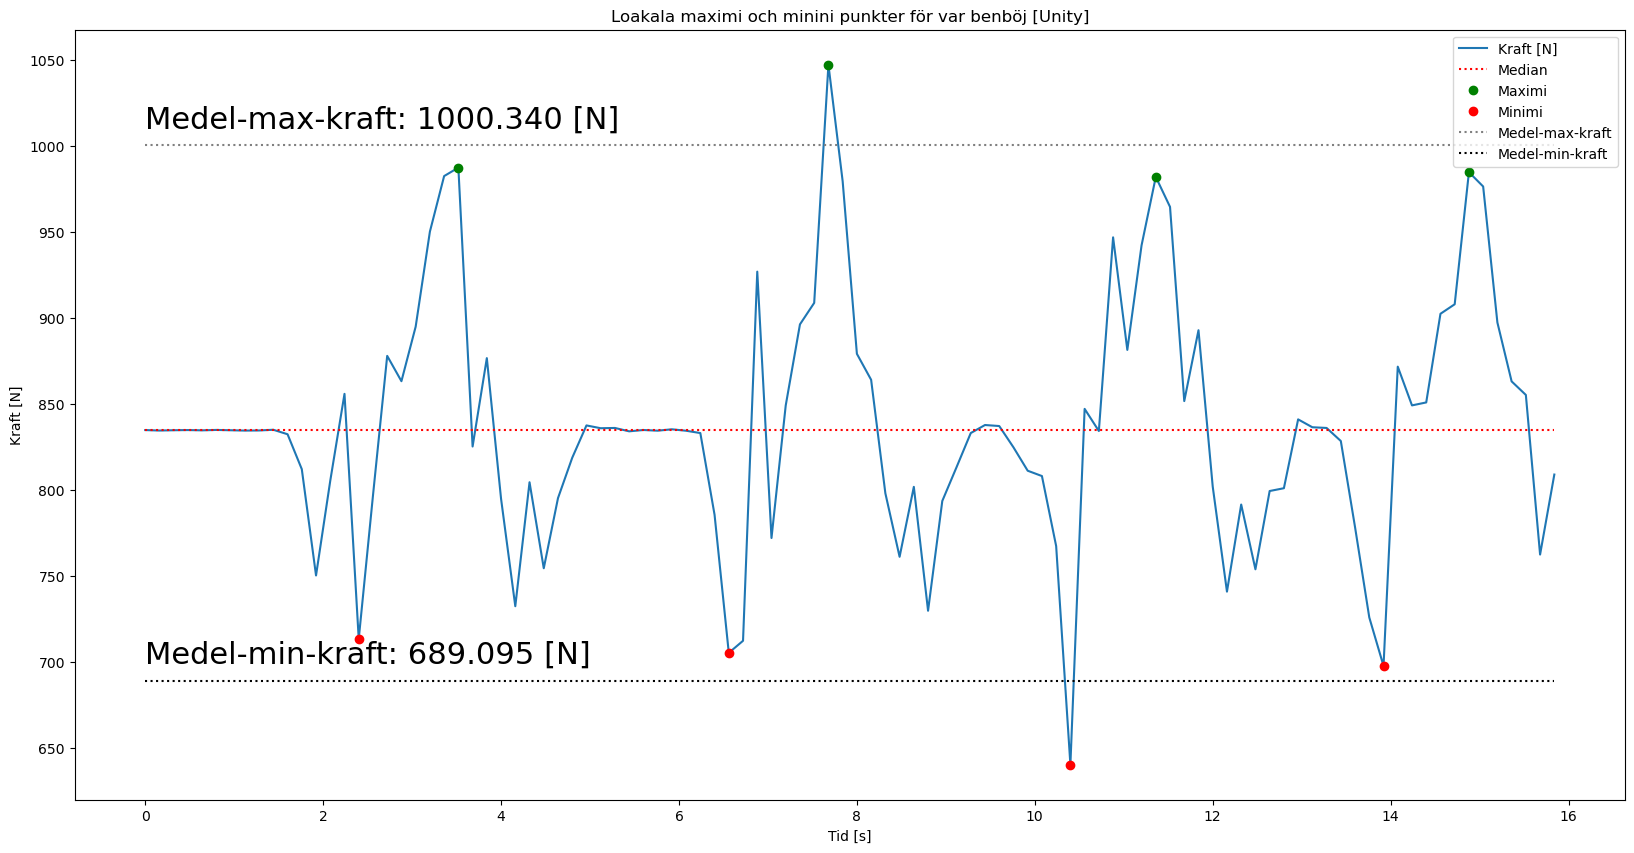

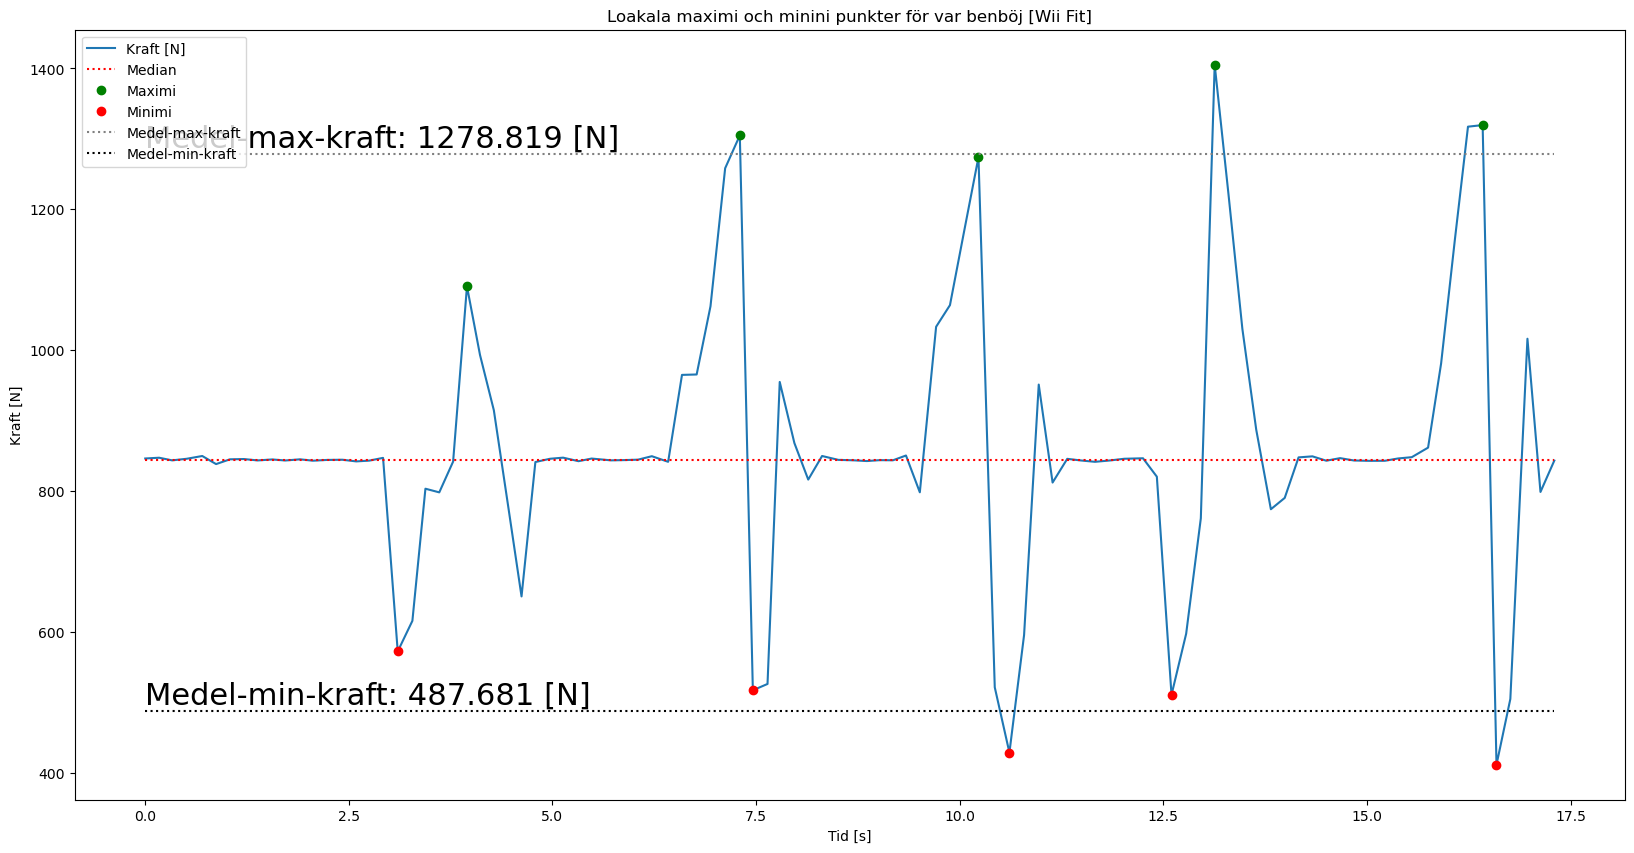

In [227]:
def showMaximaAndMinimaForDataframe(dataframe, rangeTo, title, nrOfSquats):
    sliceOfData = dataframe[0:rangeTo]

    fig, (ax1) = plt.subplots(1, 1, figsize=(20,10))

    ax1.plot(sliceOfData['time'], sliceOfData['force'], label="Kraft [N]")
    ax1.set_title(f"Loakala maximi och minini punkter för var benböj [{title}]")
    ax1.set_xlabel("Tid [s]")
    ax1.set_ylabel("Kraft [N]")
    ax1.hlines(y=sliceOfData['force'].median(), xmin=sliceOfData['time'].min(), xmax=sliceOfData['time'].max(), linestyle="dotted", color="red", label="Median")


    ## För att få ut derivatan får man gå tillbaks till grunden för vad derivata är.
    ## delta y / delta x.

    #difference = sliceOfData.diff()
    #derivative = difference.eval('force/time')
    #ax1.plot(sliceOfData['time'], derivative, 'ro', label="derivative")
    #ax1.vlines(sliceOfData['time'], derivative, colors="gray", alpha=0.5, ymax=1500, linestyles="dotted")
    #ax1.hlines(y=0, xmin=0, xmax=16, colors="gray", alpha=0.5)




    localMaximaForce = []
    localMaximaTime = []

    localMinimaForce = []
    localMinimaTime = []


    i = 1
    while(i < sliceOfData['force'].shape[0]):
        if(i == sliceOfData['force'].shape[0] - 1):
            break

        if(sliceOfData['force'][i] > sliceOfData['force'][i+1] and sliceOfData['force'][i] > sliceOfData['force'][i-1]):
            localMaximaForce.append(sliceOfData['force'][i])
            localMaximaTime.append(sliceOfData['time'][i])
            i = i + 1
            continue
        
        if(sliceOfData['force'][i] < sliceOfData['force'][i+1] and sliceOfData['force'][i] < sliceOfData['force'][i-1]):
            localMinimaForce.append(sliceOfData['force'][i])
            localMinimaTime.append(sliceOfData['time'][i])
            i = i + 1
            continue
        
        i = i + 1


    #ax1.plot(localMaximaTime,localMaximaForce, 'go', label="Maximi")
    #ax1.plot(localMinimaTime,localMinimaForce, 'ro', label="Minimi")

    # Sortera efter storlek
    # Ta ut de 31 största.
    # Markera
    # Gör samma sak med minimi.
    #nrOfSquats = 4


    #Maximi
    dataMaxima = {
        "maxima":localMaximaForce,
        "time":localMaximaTime
    }

    dataframeMaxima = pd.DataFrame(data=dataMaxima)
    dataframeMaxima.sort_values(by="maxima", ascending=False, inplace=True)

    maximaForce = dataframeMaxima['maxima'][0:nrOfSquats]
    maximaTime = dataframeMaxima['time'][0:nrOfSquats]

    ax1.plot(maximaTime,maximaForce, 'go', label="Maximi")

    #Minimi
    dataMinima = {
        "minima":localMinimaForce,
        "time":localMinimaTime
    }

    dataframeMinima = pd.DataFrame(data=dataMinima)
    dataframeMinima.sort_values(by="minima", ascending=True, inplace=True)

    minimaForce = dataframeMinima['minima'][0:nrOfSquats]
    minimaTime = dataframeMinima['time'][0:nrOfSquats]

    ax1.plot(minimaTime,minimaForce, 'ro', label="Minimi")

    averageMaxForce = maximaForce.mean()
    averageMinForce = minimaForce.mean()

    ax1.text(x=0, y=averageMaxForce + 10, s=f"Medel-max-kraft: {averageMaxForce:.3f} [N]", fontsize=22)
    ax1.text(x=0, y=averageMinForce + 10, s=f"Medel-min-kraft: {averageMinForce:.3f} [N]", fontsize=22)

    ax1.hlines(y=averageMaxForce, xmin=sliceOfData['time'].min(), xmax=sliceOfData['time'].max(), linestyles="dotted", label="Medel-max-kraft", colors="gray")
    ax1.hlines(y=averageMinForce, xmin=sliceOfData['time'].min(), xmax=sliceOfData['time'].max(), linestyles="dotted", label="Medel-min-kraft", colors="black" )



    ax1.legend()
    plt.show()
    
    return minimaForce, maximaForce

minimaForceUnity, maximaForceUnity = showMaximaAndMinimaForDataframe(dataframe=unityDF, rangeTo=100, title="Unity", nrOfSquats=4)
minimaForceWiiFit, maxmiaForceWiiFit = showMaximaAndMinimaForDataframe(dataframe=wiiFitDF, rangeTo=100, title="Wii Fit", nrOfSquats=5)



Kod för att finna toppar och bottar

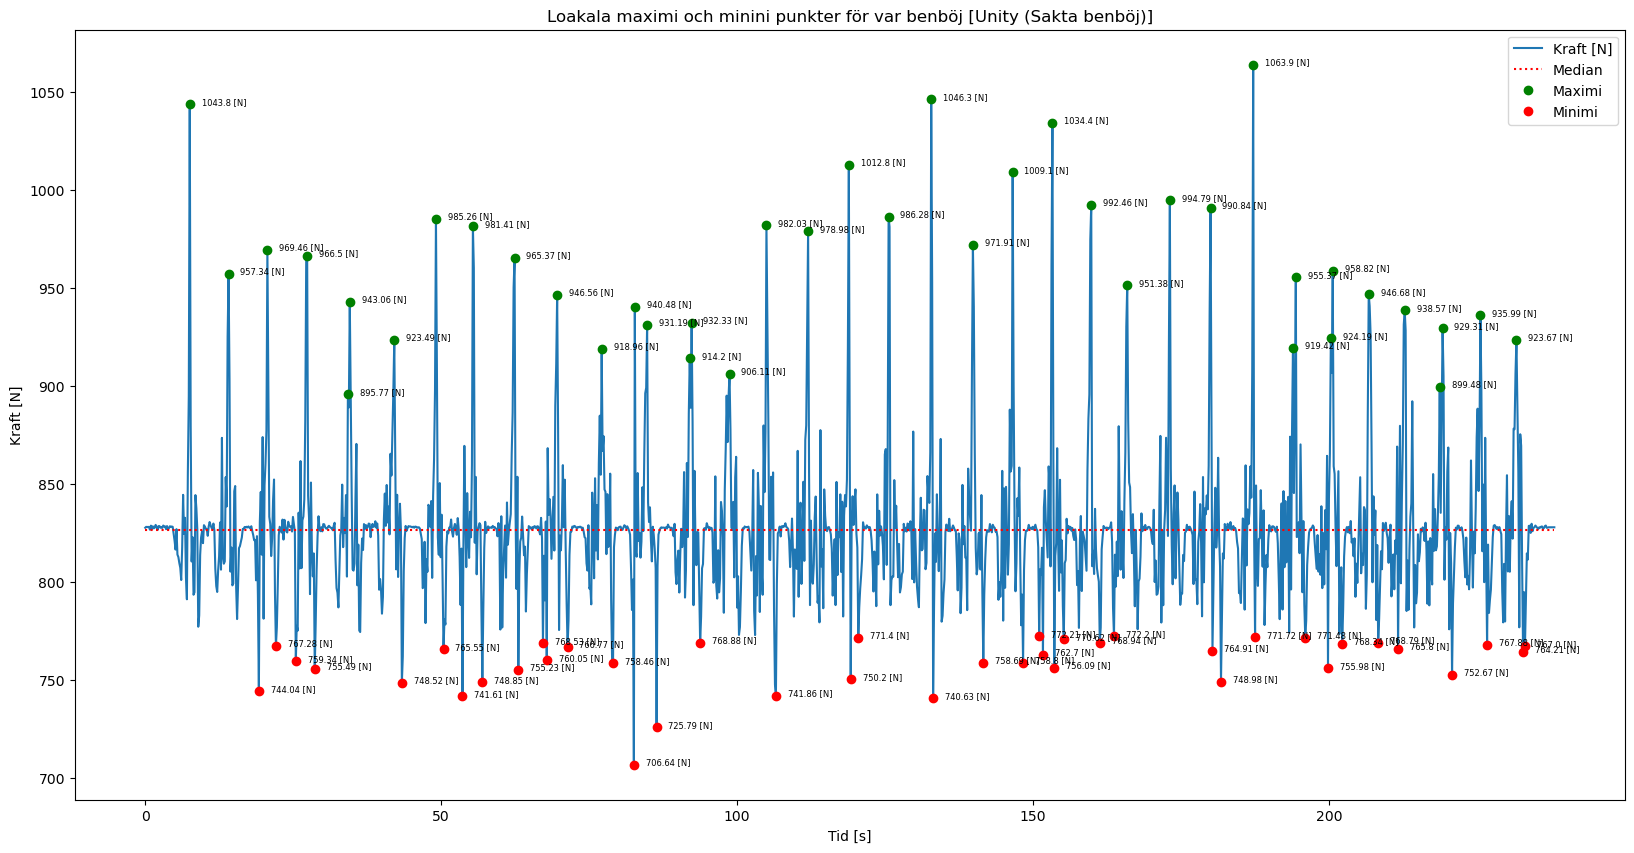

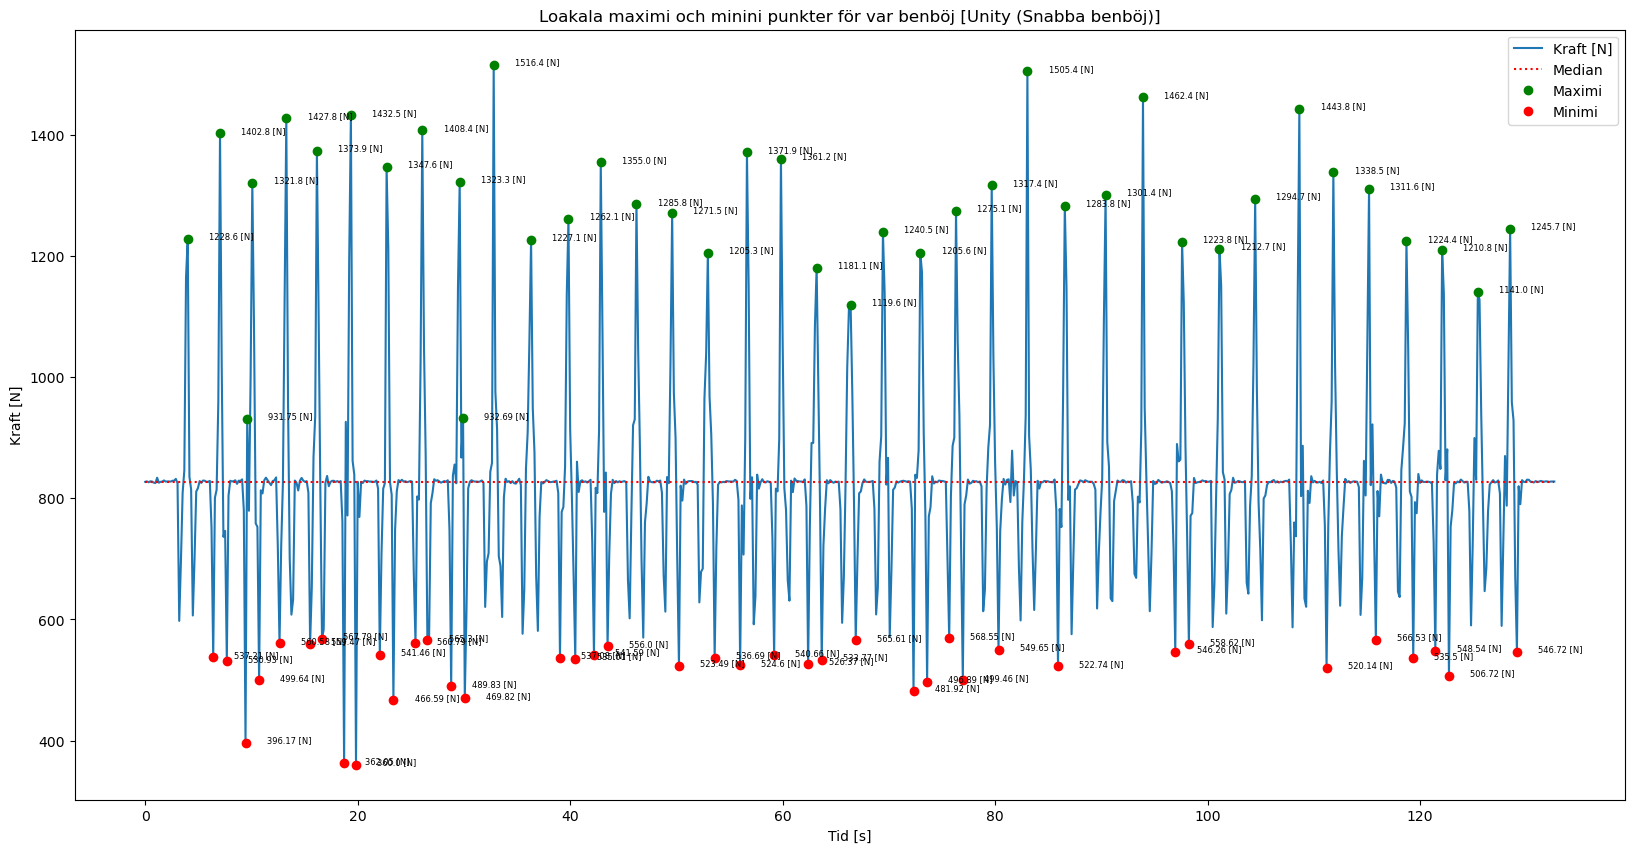

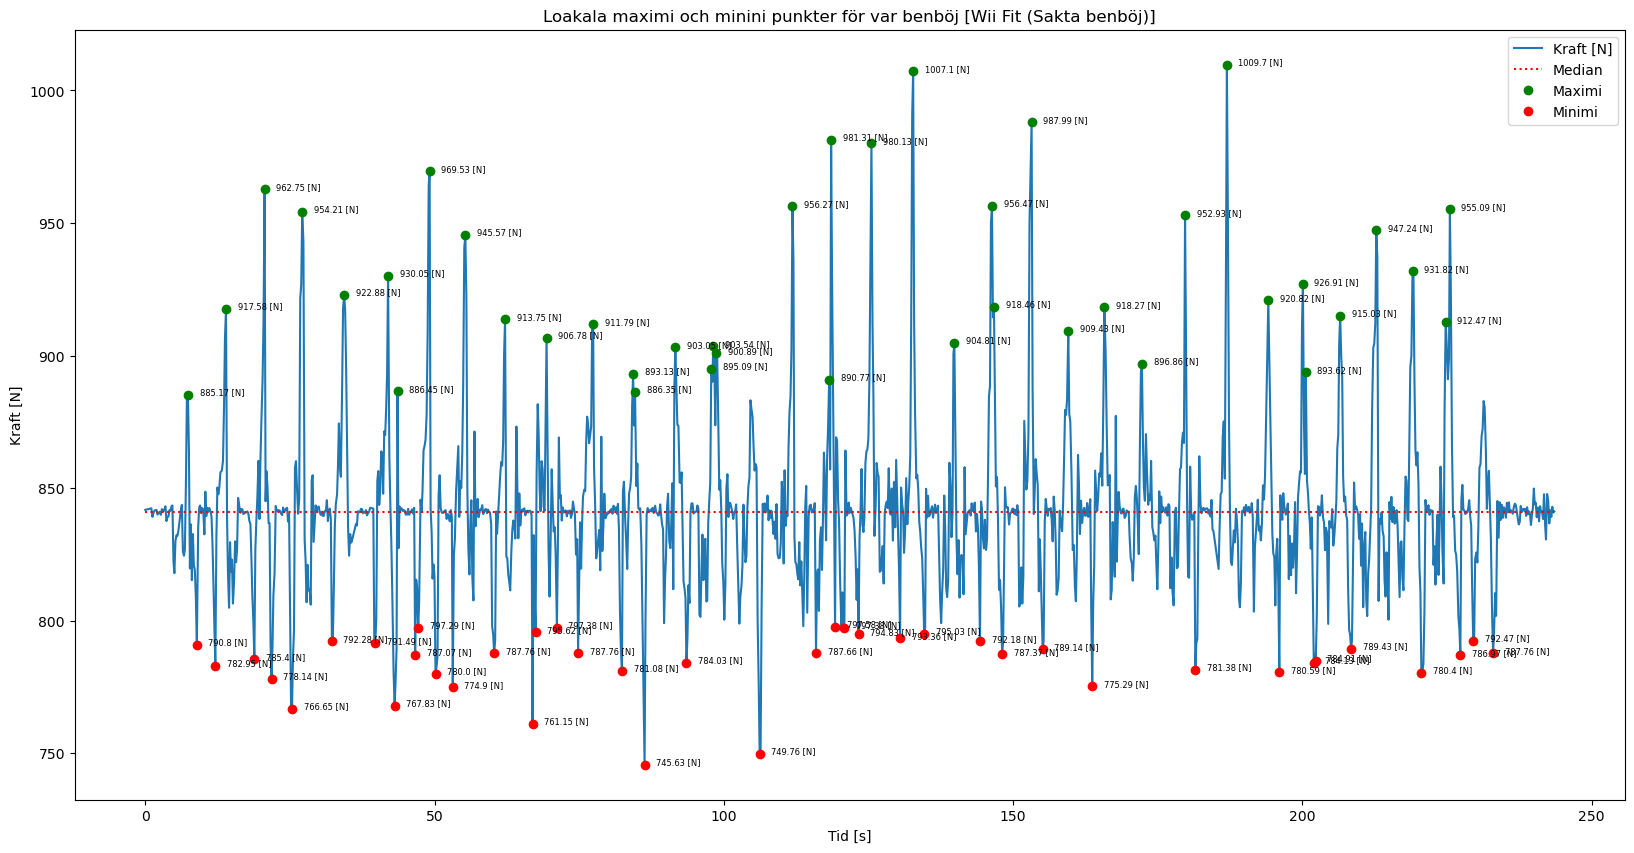

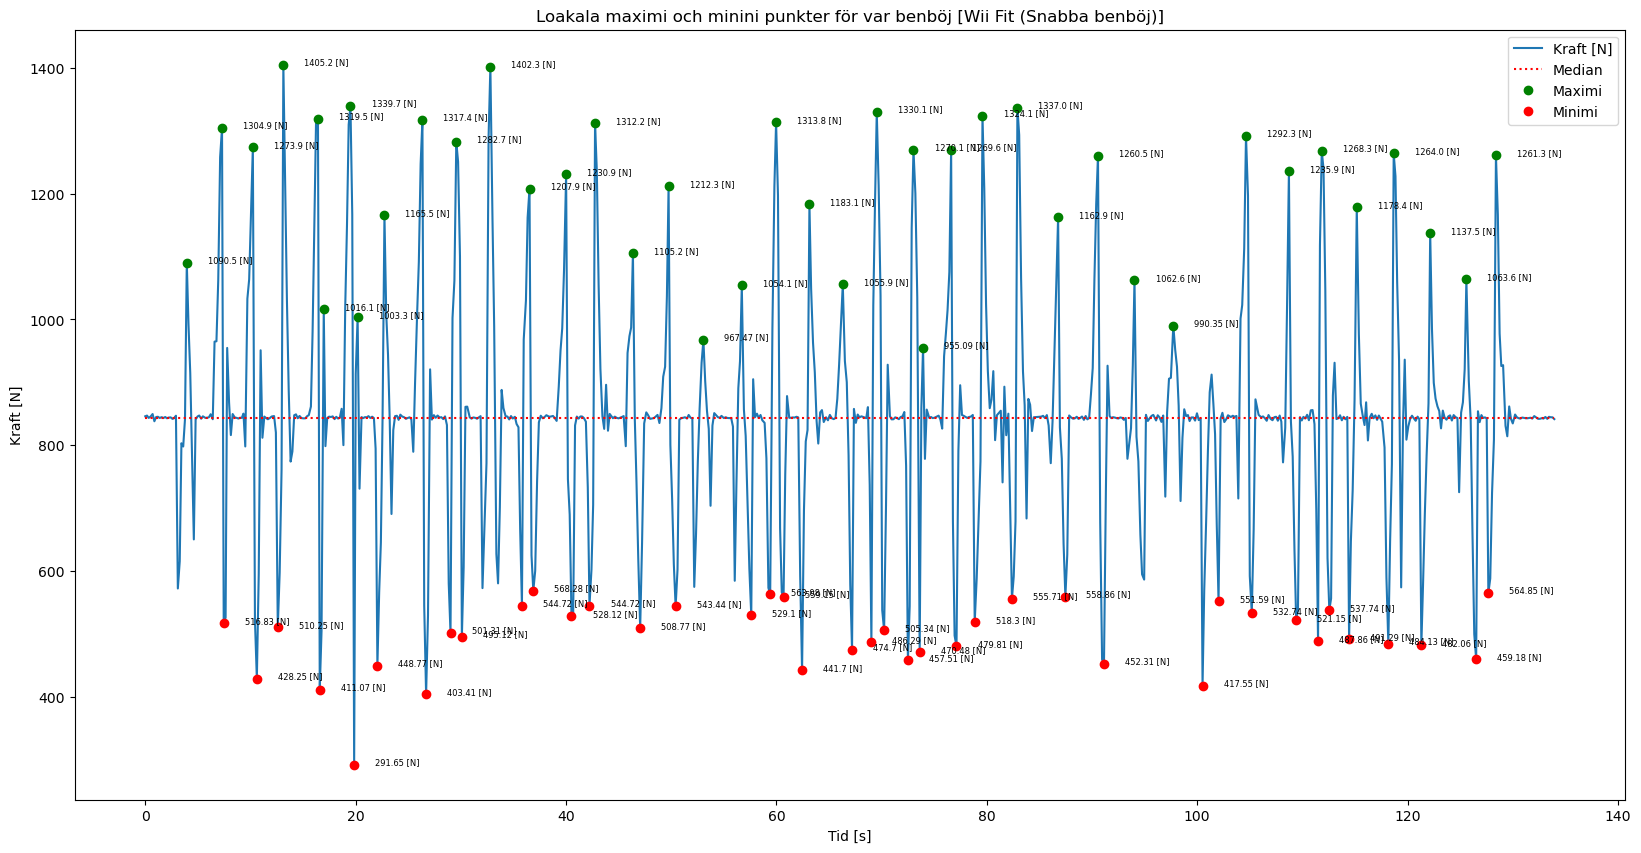

In [246]:
def showMaximaAndMinimaForDataframe(dataframe, rangeTo, title, nrOfSquats):
    sliceOfData = dataframe[0:rangeTo]

    fig, (ax1) = plt.subplots(1, 1, figsize=(20,10))

    ax1.plot(sliceOfData['time'], sliceOfData['force'], label="Kraft [N]")
    ax1.set_title(f"Loakala maximi och minini punkter för var benböj [{title}]")
    ax1.set_xlabel("Tid [s]")
    ax1.set_ylabel("Kraft [N]")
    ax1.hlines(y=sliceOfData['force'].median(), xmin=sliceOfData['time'].min(), xmax=sliceOfData['time'].max(), linestyle="dotted", color="red", label="Median")


    ## För att få ut derivatan får man gå tillbaks till grunden för vad derivata är.
    ## delta y / delta x.

    #difference = sliceOfData.diff()
    #derivative = difference.eval('force/time')
    #ax1.plot(sliceOfData['time'], derivative, 'ro', label="derivative")
    #ax1.vlines(sliceOfData['time'], derivative, colors="gray", alpha=0.5, ymax=1500, linestyles="dotted")
    #ax1.hlines(y=0, xmin=0, xmax=16, colors="gray", alpha=0.5)




    localMaximaForce = []
    localMaximaTime = []

    localMinimaForce = []
    localMinimaTime = []


    i = 1
    while(i < sliceOfData['force'].shape[0]):
        if(i == sliceOfData['force'].shape[0] - 1):
            break

        if(sliceOfData['force'][i] > sliceOfData['force'][i+1] and sliceOfData['force'][i] > sliceOfData['force'][i-1]):
            localMaximaForce.append(sliceOfData['force'][i])
            localMaximaTime.append(sliceOfData['time'][i])
            i = i + 1
            continue
        
        if(sliceOfData['force'][i] < sliceOfData['force'][i+1] and sliceOfData['force'][i] < sliceOfData['force'][i-1]):
            localMinimaForce.append(sliceOfData['force'][i])
            localMinimaTime.append(sliceOfData['time'][i])
            i = i + 1
            continue
        
        i = i + 1


    #ax1.plot(localMaximaTime,localMaximaForce, 'go', label="Maximi")
    #ax1.plot(localMinimaTime,localMinimaForce, 'ro', label="Minimi")

    # Sortera efter storlek
    # Ta ut de 31 största.
    # Markera
    # Gör samma sak med minimi.
    #nrOfSquats = 4

    #ax1.plot(localMaximaTime,localMaximaForce, "ro", label="Lokal Maximi")
    #ax1.plot(localMinimaTime,localMinimaForce, "go", label="Lokal Minimi")

    data0 = {
        "time":localMaximaTime,
        "force":localMaximaForce,
        "maxima":True
    }
    data1 = {
        "time":localMinimaTime,
        "force":localMinimaForce,
        "maxima":False
    }
    
    df0 = pd.DataFrame(data0)
    df1 = pd.DataFrame(data1)
    dfFull = pd.concat([df0,df1])
    dfFull.sort_values(by='time')
    
    minimaForce0 = []
    minimaTime0 = []
    
    #for row in dfFull:
    # Titta om man är vid "near" ett visst värde.
    # Kolla toppar, och bottar. På något vis....   
    

    #Maximi
    dataMaxima = {
        "maxima":localMaximaForce,
        "time":localMaximaTime
    }

    dataframeMaxima = pd.DataFrame(data=dataMaxima)
    dataframeMaxima.sort_values(by="maxima", ascending=False, inplace=True)

    maximaForce = dataframeMaxima['maxima'][0:nrOfSquats]
    maximaTime = dataframeMaxima['time'][0:nrOfSquats]

    ax1.plot(maximaTime,maximaForce, 'go', label="Maximi")

    #Minimi
    dataMinima = {
        "minima":localMinimaForce,
        "time":localMinimaTime
    }

    dataframeMinima = pd.DataFrame(data=dataMinima)
    dataframeMinima.sort_values(by="minima", ascending=True, inplace=True)

    minimaForce = dataframeMinima['minima'][0:nrOfSquats]
    minimaTime = dataframeMinima['time'][0:nrOfSquats]

    ax1.plot(minimaTime,minimaForce, 'ro', label="Minimi")

    
    for time, force in zip(minimaTime, minimaForce):
        ax1.text(time+2, force, f'{force:.5} [N]', fontsize = 6)

    for time, force in zip(maximaTime, maximaForce):
        ax1.text(time+2, force, f'{force:.5} [N]', fontsize = 6)
        

    #averageMaxForce = maximaForce.mean()
    #averageMinForce = minimaForce.mean()

    #ax1.text(x=0, y=averageMaxForce + 10, s=f"Medel-max-kraft: {averageMaxForce:.3f} [N]", fontsize=22)
    #ax1.text(x=0, y=averageMinForce + 10, s=f"Medel-min-kraft: {averageMinForce:.3f} [N]", fontsize=22)

    #ax1.hlines(y=averageMaxForce, xmin=sliceOfData['time'].min(), xmax=sliceOfData['time'].max(), linestyles="dotted", label="Medel-max-kraft", colors="gray")
    #ax1.hlines(y=averageMinForce, xmin=sliceOfData['time'].min(), xmax=sliceOfData['time'].max(), linestyles="dotted", label="Medel-min-kraft", colors="black" )



    ax1.legend()
    plt.show()

#showMaximaAndMinimaForDataframe(dataframe=unityDF, rangeTo=200, title="Unity", nrOfSquats=9)
showMaximaAndMinimaForDataframe(dataframe=unitySlowDF, rangeTo=len(unitySlowDF['time']), title="Unity (Sakta benböj)", nrOfSquats=40)
showMaximaAndMinimaForDataframe(dataframe=unityFastDF, rangeTo=len(unityFastDF['time']), title="Unity (Snabba benböj)", nrOfSquats=40)

showMaximaAndMinimaForDataframe(dataframe=wiiFitSlowDF, rangeTo=len(wiiFitSlowDF['time']), title="Wii Fit (Sakta benböj)", nrOfSquats=40)
showMaximaAndMinimaForDataframe(dataframe=wiiFitFastDF, rangeTo=len(wiiFitFastDF['time']), title="Wii Fit (Snabba benböj)", nrOfSquats=40)





Kod för att finna plattåer

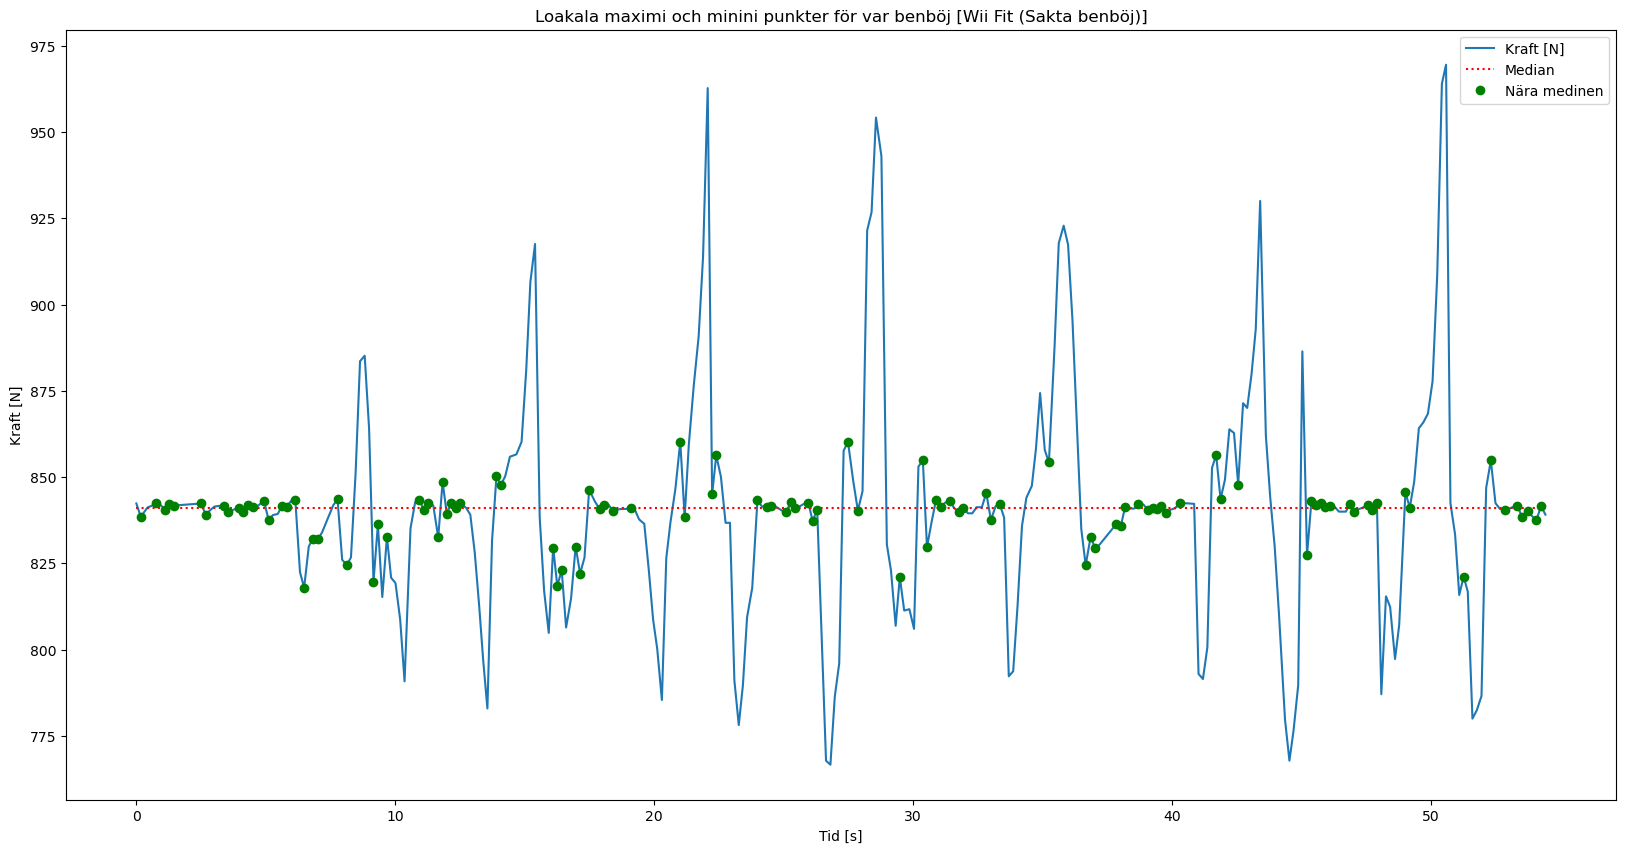

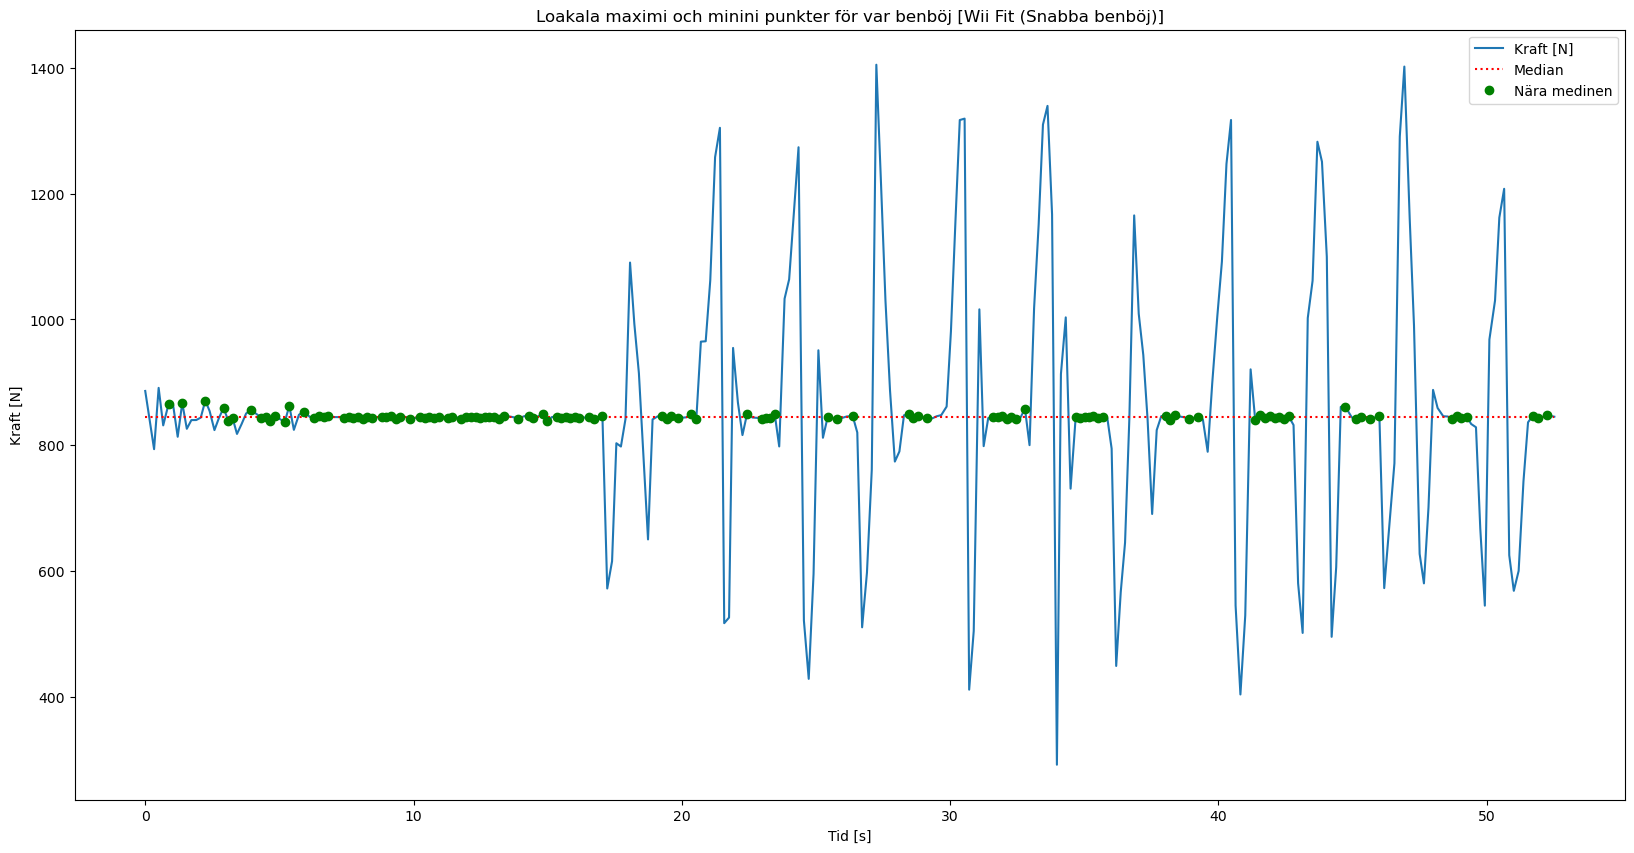

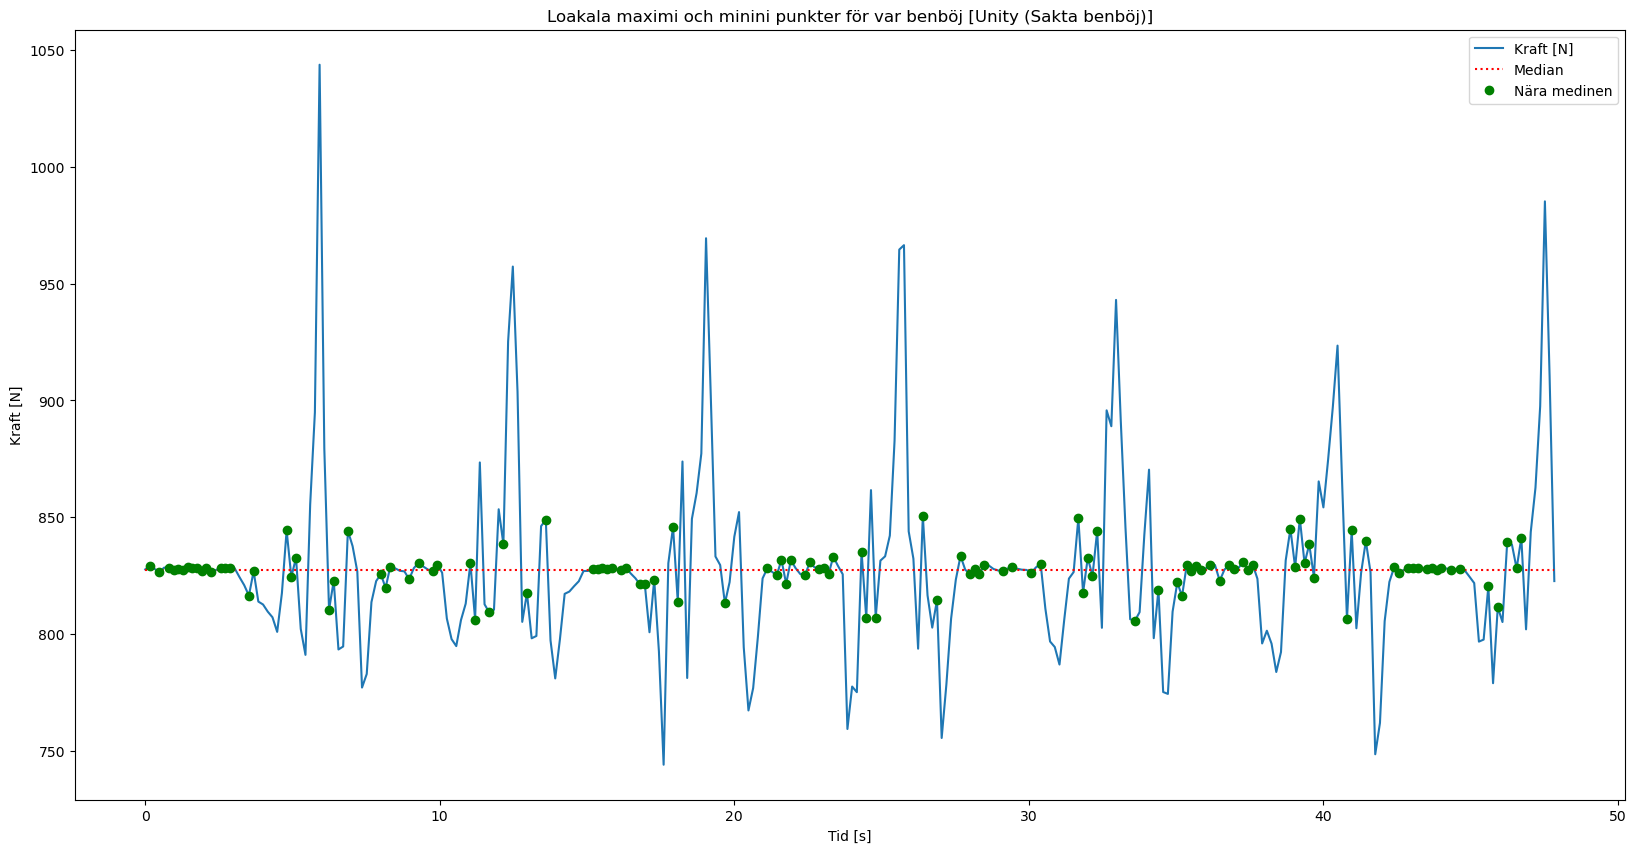

In [270]:
#Import math Library
import math

def showMaximaAndMinimaForDataframe(dataframe, rangeTo, title, nrOfSquats):
    sliceOfData = dataframe[0:rangeTo]

    fig, (ax1) = plt.subplots(1, 1, figsize=(20,10))

    ax1.plot(sliceOfData['time'], sliceOfData['force'], label="Kraft [N]")
    ax1.set_title(f"Loakala maximi och minini punkter för var benböj [{title}]")
    ax1.set_xlabel("Tid [s]")
    ax1.set_ylabel("Kraft [N]")
    ax1.hlines(y=sliceOfData['force'].median(), xmin=sliceOfData['time'].min(), xmax=sliceOfData['time'].max(), linestyle="dotted", color="red", label="Median")


    ## För att få ut derivatan får man gå tillbaks till grunden för vad derivata är.
    ## delta y / delta x.

    #difference = sliceOfData.diff()
    #derivative = difference.eval('force/time')
    #ax1.plot(sliceOfData['time'], derivative, 'ro', label="derivative")
    #ax1.vlines(sliceOfData['time'], derivative, colors="gray", alpha=0.5, ymax=1500, linestyles="dotted")
    #ax1.hlines(y=0, xmin=0, xmax=16, colors="gray", alpha=0.5)




    localMaximaForce = []
    localMaximaTime = []

    localMinimaForce = []
    localMinimaTime = []


    i = 1
    while(i < sliceOfData['force'].shape[0]):
        if(i == sliceOfData['force'].shape[0] - 1):
            break

        if(sliceOfData['force'][i] > sliceOfData['force'][i+1] and sliceOfData['force'][i] > sliceOfData['force'][i-1]):
            localMaximaForce.append(sliceOfData['force'][i])
            localMaximaTime.append(sliceOfData['time'][i])
            i = i + 1
            continue
        
        if(sliceOfData['force'][i] < sliceOfData['force'][i+1] and sliceOfData['force'][i] < sliceOfData['force'][i-1]):
            localMinimaForce.append(sliceOfData['force'][i])
            localMinimaTime.append(sliceOfData['time'][i])
            i = i + 1
            continue
        
        i = i + 1


    #ax1.plot(localMaximaTime,localMaximaForce, 'go', label="Maximi")
    #ax1.plot(localMinimaTime,localMinimaForce, 'ro', label="Minimi")

    # Sortera efter storlek
    # Ta ut de 31 största.
    # Markera
    # Gör samma sak med minimi.
    #nrOfSquats = 4


    ## Detta ska okommenteras om man vill se alla punkter
    # ax1.plot(localMaximaTime,localMaximaForce, "ro", label="Lokal Maximi")
    # ax1.plot(localMinimaTime,localMinimaForce, "go", label="Lokal Minimi")

    data0 = {
        "time":localMaximaTime,
        "force":localMaximaForce,
        "maxima":True
    }
    data1 = {
        "time":localMinimaTime,
        "force":localMinimaForce,
        "maxima":False
    }
    
    df0 = pd.DataFrame(data0)
    df1 = pd.DataFrame(data1)
    dfFull = pd.concat([df0,df1])
    dfFull.sort_values(by='time')
    
    minimaForce0 = []
    minimaTime0 = []
    
    #for row in dfFull:
    # Titta om man är vid "near" ett visst värde.
    # Kolla toppar, och bottar. På något vis....   
    

    #Maximi
    dataMaxima = {
        "maxima":localMaximaForce,
        "time":localMaximaTime
    }

    dataframeMaxima = pd.DataFrame(data=dataMaxima)
    dataframeMaxima.sort_values(by="maxima", ascending=False, inplace=True)

    maximaForce = dataframeMaxima['maxima'][0:nrOfSquats]
    maximaTime = dataframeMaxima['time'][0:nrOfSquats]

    #ax1.plot(maximaTime,maximaForce, 'go', label="Maximi")

    #Minimi
    dataMinima = {
        "minima":localMinimaForce,
        "time":localMinimaTime
    }

    dataframeMinima = pd.DataFrame(data=dataMinima)
    dataframeMinima.sort_values(by="minima", ascending=True, inplace=True)

    minimaForce = dataframeMinima['minima'][0:nrOfSquats]
    minimaTime = dataframeMinima['time'][0:nrOfSquats]


    ## Test för att se om det går att hitta om det är nära Medianen.
    closeToMedianPointsForce = []
    closeToMedianPointsTime = []
    i = 0
    tolerance = 23
    while(i < len(dataframeMinima['minima'])):
        if(math.isclose(dataframeMinima['minima'][i], sliceOfData['force'].mean(), abs_tol=tolerance)):
            closeToMedianPointsForce.append(dataframeMinima['minima'][i])
            closeToMedianPointsTime.append(dataframeMinima['time'][i])
        i = i + 1
    
    i = 0
    while(i < len(dataframeMaxima['maxima'])):
        if(math.isclose(dataframeMaxima['maxima'][i], sliceOfData['force'].mean(), abs_tol=tolerance)):
            closeToMedianPointsForce.append(dataframeMaxima['maxima'][i])
            closeToMedianPointsTime.append(dataframeMaxima['time'][i])
        i = i + 1
    
    ax1.plot(closeToMedianPointsTime,closeToMedianPointsForce, 'go', label="Nära medinen")
                
    #ax1.plot(minimaTime,minimaForce, 'ro', label="Minimi")

    #averageMaxForce = maximaForce.mean()
    #averageMinForce = minimaForce.mean()

    #ax1.text(x=0, y=averageMaxForce + 10, s=f"Medel-max-kraft: {averageMaxForce:.3f} [N]", fontsize=22)
    #ax1.text(x=0, y=averageMinForce + 10, s=f"Medel-min-kraft: {averageMinForce:.3f} [N]", fontsize=22)

    #ax1.hlines(y=averageMaxForce, xmin=sliceOfData['time'].min(), xmax=sliceOfData['time'].max(), linestyles="dotted", label="Medel-max-kraft", colors="gray")
    #ax1.hlines(y=averageMinForce, xmin=sliceOfData['time'].min(), xmax=sliceOfData['time'].max(), linestyles="dotted", label="Medel-min-kraft", colors="black" )



    ax1.legend()
    plt.show()

#showMaximaAndMinimaForDataframe(dataframe=unityDF, rangeTo=200, title="Unity", nrOfSquats=9)
showMaximaAndMinimaForDataframe(dataframe=wiiFitSlowDF, rangeTo=300, title="Wii Fit (Sakta benböj)", nrOfSquats=4)
showMaximaAndMinimaForDataframe(dataframe=wiiFitFastDF, rangeTo=300, title="Wii Fit (Snabba benböj)", nrOfSquats=4)
showMaximaAndMinimaForDataframe(dataframe=unitySlowDF, rangeTo=300, title="Unity (Sakta benböj)", nrOfSquats=4)
#showMaximaAndMinimaForDataframe(dataframe=unityFastDF, rangeTo=100, title="Unity (Snabba benböj) ", nrOfSquats=4)




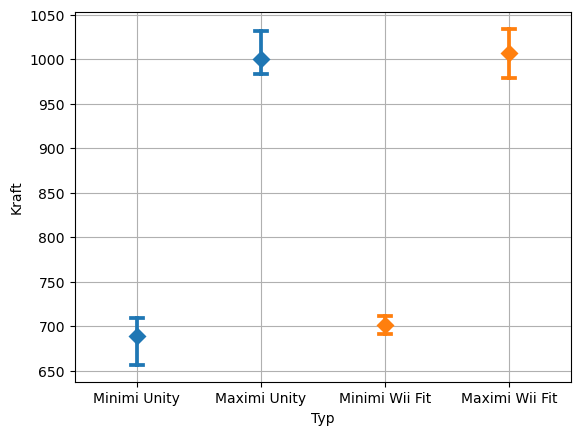

In [24]:
def concatIntoDF(minimaForce, maximaForce, name):
    data0 = {
        "Typ":f"Minimi {name}",
        "Kraft":minimaForce,
    }

    data1 = {
        "Typ":f"Maximi {name}",
        "Kraft":maximaForce,
    }

    plottedDataFrame0 = pd.DataFrame(data=data0)
    plottedDataFrame1 = pd.DataFrame(data=data1)

    plottedDataFrame = pd.concat([plottedDataFrame0, plottedDataFrame1])
    return plottedDataFrame


def showPointPlot(minimaForce0, maximaForce0, minimaForce1, maximaForce1):
    plottedUnityDataFrame = concatIntoDF(minimaForce0, maximaForce0, "Unity")
    plottedWiiFitDataFrame = concatIntoDF(minimaForce1, maximaForce1, "Wii Fit")


    fig, ax =plt.subplots(1,1)
    sns.pointplot(data=plottedUnityDataFrame, x="Typ", y="Kraft", linestyles='none', markers='D', capsize=.1, legend=True)
    sns.pointplot(data=plottedWiiFitDataFrame, x="Typ", y="Kraft", linestyles='none', markers='D', capsize=.1, legend=True)
    plt.grid()
    
    
showPointPlot(minimaForceUnity, maximaForceUnity, minimaForceWiiFit, maxmiaForceWiiFit)
